In [1]:
# ==== BLOCO 1: Montar Drive e carregar o parquet ====
from google.colab import drive
drive.mount('/content/drive')

import os, glob, pandas as pd

BASE_DIR = '/content/drive/MyDrive/seguro_rural'   # ajuste se necessário
FILENAME = 'psr_2006_2025.parquet'
PSR_PATH = os.path.join(BASE_DIR, FILENAME)

if not os.path.exists(PSR_PATH):
    print(f"Arquivo não encontrado em {PSR_PATH}. Buscando no MyDrive…")
    candidates = glob.glob('/content/drive/MyDrive/**/psr_2006_2025.parquet', recursive=True)
    if not candidates:
        raise FileNotFoundError("psr_2006_2025.parquet não encontrado no seu MyDrive.")
    PSR_PATH = candidates[0]

print(f"Arquivo encontrado: {PSR_PATH}")

# Lê o parquet (pyarrow é padrão no Colab)
df = pd.read_parquet(PSR_PATH)

# Garante dtype de datas, se existirem
date_cols = ['DT_PROPOSTA','DT_INICIO_VIGENCIA','DT_FIM_VIGENCIA','DT_APOLICE']
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

print(f"Shape: {df.shape} | Colunas: {len(df.columns)}")
df.head(3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arquivo encontrado: /content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet
Shape: (1712384, 68) | Colunas: 68


,NM_RAZAO_SOCIAL,CD_PROCESSO_SUSEP,NR_PROPOSTA,ID_PROPOSTA,DT_PROPOSTA,DT_INICIO_VIGENCIA,DT_FIM_VIGENCIA,NM_SEGURADO,NR_DOCUMENTO_SEGURADO,NM_MUNICIPIO_PROPRIEDADE,...,METR_AREA_MEDIA,METR_SUBVENCAO_RELATIVA,MES_APOLICE,NR_DOCUMENTO_SEGURADO_NORM,CHAVE_SEGURADO,PRESENCA_SEGURADO_ANO,FLAG_PREMIO_NULO,FLAG_PREMIO_NEGATIVO,FLAG_GARANTIA_NULA,FLAG_GARANTIA_INVALIDA
0,aliança_do_brasil_seguros_s/a.,15414901479201927,50405357,1045544,2019-08-29,2019-08-29,2020-08-28,jose_procopio_bezerra_neto,***53043172,rio_verde,...,0.001726,NaN,9,53043172,53043172,True,True,False,True,False
1,aliança_do_brasil_seguros_s/a.,15414901479201927,50405359,1038777,2019-08-29,2019-08-29,2020-08-28,joao_augusto_dedemo_prado,***47332869,veríssimo,...,0.001273,NaN,9,47332869,47332869,True,True,False,True,False
2,aliança_do_brasil_seguros_s/a.,15414901479201927,50405361,1038713,2019-08-29,2019-08-29,2020-08-28,joao_augusto_dedemo_prado,***47332869,veríssimo,...,0.001500,NaN,9,47332869,47332869,True,True,False,True,False


In [2]:
# ==== BLOCO 2: Seleção de features, tipagem e DT_REF ====

import pandas as pd
import numpy as np

TARGET = 'VALOR_INDENIZAÇÃO'

FEATURES = [
    'ANO_APOLICE','MES_APOLICE','DIAS_PROPOSTA_ANTES_VIGENCIA','DIAS_VIGENCIA',
    'NR_AREA_TOTAL','NR_ANIMAL','NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL',
    'NivelDeCobertura','NR_PRODUTIVIDADE_ESTIMADA','NR_PRODUTIVIDADE_SEGURADA',
    'DIF_PROD','RAZAO_PROD','NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE',
    'NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE'
]

DROP_ALWAYS = [
    'NM_RAZAO_SOCIAL','CD_PROCESSO_SUSEP','NR_PROPOSTA','ID_PROPOSTA','NM_SEGURADO',
    'NR_DOCUMENTO_SEGURADO','NR_DOCUMENTO_SEGURADO_NORM','CHAVE_SEGURADO','NR_APOLICE',
    'CD_GEOCMU','EVENTO_PREPONDERANTE','DIAS_APOLICE_DEPOIS','APOLICE_INCONSISTENTE',
    'ERRO_PROPOSTA','ERRO_VIGENCIA','ERRO_VIGENCIA_EXCESSO','FLAG_PREMIO_ZERO',
    'FLAG_RELACAO_PREMIO_SEGURADO','FLAG_SUBVENCAO_EXCESSO','FLAG_PRODUT_ESTIMADA_OUTLIER',
    'FLAG_PRODUT_SEGURADA_OUTLIER','FLAG_APOLICE_INCONSISTENTE','FLAG_ERRO_PROPOSTA',
    'FLAG_ERRO_VIGENCIA','FLAG_ERRO_VIGENCIA_EXCESSO','FLAG_PREMIO_NULO','FLAG_PREMIO_NEGATIVO',
    'FLAG_GARANTIA_NULA','FLAG_GARANTIA_INVALIDA','LATITUDE','LONGITUDE','NR_GRAU_LAT',
    'NR_MIN_LAT','NR_SEG_LAT','NR_GRAU_LONG','NR_MIN_LONG','NR_SEG_LONG'
]

DROP_CAUTION = [
    'METR_SINISTRALIDADE','METR_TAXA_PREMIO','METR_AREA_MEDIA','METR_SUBVENCAO_RELATIVA',
    'VL_PREMIO_LIQUIDO','PE_TAXA','VL_LIMITE_GARANTIA','VL_SUBVENCAO_FEDERAL'
]

# colunas auxiliares que manteremos (não entram no treino como feature)
AUX_KEEP = [
    'DT_PROPOSTA','DT_INICIO_VIGENCIA','DT_FIM_VIGENCIA','DT_APOLICE',
    'CHAVE_SEGURADO','VL_LIMITE_GARANTIA'
]

# Subconjunto de colunas a manter
keep_cols = list(dict.fromkeys(FEATURES + [TARGET] + AUX_KEEP))
keep_cols = [c for c in keep_cols if c in df.columns]

# Aplicar recorte e dropar colunas proibidas se estiverem presentes
cols_drop = [c for c in DROP_ALWAYS + DROP_CAUTION if c in keep_cols]
df_model = df[keep_cols].drop(columns=cols_drop, errors='ignore')

# Tipagem numérica segura
num_to_cast = ['NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE','NR_AREA_TOTAL','NR_ANIMAL',
               'NR_PRODUTIVIDADE_ESTIMADA','NR_PRODUTIVIDADE_SEGURADA',
               'DIAS_PROPOSTA_ANTES_VIGENCIA','DIAS_VIGENCIA','DIF_PROD','RAZAO_PROD']
for c in num_to_cast:
    if c in df_model.columns:
        df_model[c] = pd.to_numeric(df_model[c], errors='coerce')

# Inteiros (se existirem)
for c in ['ANO_APOLICE','MES_APOLICE']:
    if c in df_model.columns:
        df_model[c] = pd.to_numeric(df_model[c], errors='coerce').astype('Int64')

# Categóricas
cat_cols = ['NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL','NivelDeCobertura',
            'NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE']
for c in cat_cols:
    if c in df_model.columns:
        df_model[c] = df_model[c].astype('category')

# TARGET numérico
if TARGET in df_model.columns:
    df_model[TARGET] = pd.to_numeric(df_model[TARGET], errors='coerce')

# Construir DT_REF (preferência: DT_APOLICE > DT_FIM_VIGENCIA > DT_INICIO_VIGENCIA > DT_PROPOSTA)
def _first_valid_dt(row):
    for c in ['DT_APOLICE','DT_FIM_VIGENCIA','DT_INICIO_VIGENCIA','DT_PROPOSTA']:
        if c in row and pd.notnull(row[c]):
            return row[c]
    return pd.NaT

dt_candidates = [c for c in ['DT_APOLICE','DT_FIM_VIGENCIA','DT_INICIO_VIGENCIA','DT_PROPOSTA'] if c in df_model.columns]
if dt_candidates:
    df_model['DT_REF'] = pd.to_datetime(df_model.apply(_first_valid_dt, axis=1), errors='coerce')
    df_model['ANO_REF'] = df_model['DT_REF'].dt.year.astype('Int64')
else:
    df_model['DT_REF'] = pd.NaT
    df_model['ANO_REF'] = pd.Series([pd.NA]*len(df_model), dtype='Int64')

print("Shape após recorte:", df_model.shape)
print("Features finais (cand.):", [c for c in FEATURES if c in df_model.columns])
df_model.head(3)


Shape após recorte: (1712384, 24)
Features finais (cand.): ['ANO_APOLICE', 'MES_APOLICE', 'DIAS_PROPOSTA_ANTES_VIGENCIA', 'DIAS_VIGENCIA', 'NR_AREA_TOTAL', 'NR_ANIMAL', 'NM_CLASSIF_PRODUTO', 'NM_CULTURA_GLOBAL', 'NivelDeCobertura', 'NR_PRODUTIVIDADE_ESTIMADA', 'NR_PRODUTIVIDADE_SEGURADA', 'DIF_PROD', 'RAZAO_PROD', 'NM_MUNICIPIO_PROPRIEDADE', 'SG_UF_PROPRIEDADE', 'NR_DECIMAL_LATITUDE', 'NR_DECIMAL_LONGITUDE']


,ANO_APOLICE,MES_APOLICE,DIAS_PROPOSTA_ANTES_VIGENCIA,DIAS_VIGENCIA,NR_AREA_TOTAL,NR_ANIMAL,NM_CLASSIF_PRODUTO,NM_CULTURA_GLOBAL,NivelDeCobertura,NR_PRODUTIVIDADE_ESTIMADA,...,SG_UF_PROPRIEDADE,NR_DECIMAL_LATITUDE,NR_DECIMAL_LONGITUDE,VALOR_INDENIZAÇÃO,DT_PROPOSTA,DT_INICIO_VIGENCIA,DT_FIM_VIGENCIA,DT_APOLICE,DT_REF,ANO_REF
0,2019,9,0,365.0,160.0,NaN,custeio,soja,"0,7",3750.0,...,go,NaN,NaN,NaN,2019-08-29,2019-08-29,2020-08-28,2019-09-11,2019-09-11,2019
1,2019,9,0,365.0,118.0,NaN,custeio,cana-de-açúcar,"0,65",100.0,...,mg,NaN,NaN,NaN,2019-08-29,2019-08-29,2020-08-28,2019-09-12,2019-09-12,2019
2,2019,9,0,365.0,139.0,NaN,custeio,cana-de-açúcar,"0,65",120.0,...,mg,NaN,NaN,NaN,2019-08-29,2019-08-29,2020-08-28,2019-09-23,2019-09-23,2019


In [3]:
# ==== BLOCO 3: Snapshot, maturidade e split temporal ====
import pandas as pd
import numpy as np

# ----- parâmetros principais (ajuste se quiser outra janela)
SNAPSHOT_DATE = pd.Timestamp('2025-08-21')   # data de corte do seu snapshot
TRAIN_START, TRAIN_END = 2019, 2021          # janela de treino (inclusive)
TEST_YEAR = 2022                             # ano de teste/holdout

TARGET = 'VALOR_INDENIZAÇÃO'

# ----- coluna de referência temporal já criada no Bloco 2 (DT_REF/ANO_REF)
if 'DT_REF' not in df_model.columns:
    raise RuntimeError("DT_REF não existe. Execute o Bloco 2 antes.")

# ----- flag de maturidade (>=180 dias desde DT_REF até snapshot)
if 'MADURA_180D' not in df_model.columns:
    df_model['MADURA_180D'] = (SNAPSHOT_DATE - df_model['DT_REF']).dt.days >= 180

# ----- recorte para linhas rotuladas e maduras
mask_labeled = df_model[TARGET].notna()
mask_mature  = df_model['MADURA_180D'].fillna(False)
df_lab = df_model.loc[mask_labeled & mask_mature].copy()

# ----- distribuição por ano (útil para sanity check rápido)
dist = df_lab.groupby(df_lab['DT_REF'].dt.year).agg(
    count=('DT_REF','size'),
    pos_rate=(TARGET, lambda s: (s > 0).mean() if len(s) else np.nan)
).rename_axis('ANO').reset_index()
print("Distribuição por ano (maduro, com target):")
print(dist.to_string(index=False))

# ----- split temporal
if 'ANO_REF' not in df_lab.columns:
    df_lab['ANO_REF'] = df_lab['DT_REF'].dt.year.astype('Int64')

mask_tr = df_lab['ANO_REF'].between(TRAIN_START, TRAIN_END)
mask_te = df_lab['ANO_REF'].eq(TEST_YEAR)

df_tr = df_lab.loc[mask_tr].copy()
df_te = df_lab.loc[mask_te].copy()

print(f"\nJanela de treino: {TRAIN_START}–{TRAIN_END}  |  n={len(df_tr)}")
print(f"Ano de teste: {TEST_YEAR}  |  n_test={len(df_te)}")

# ----- preparar listas de colunas (categorias e numéricas)
cat_cols = [c for c in ['NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL','NivelDeCobertura',
                        'NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE']
            if c in df_tr.columns]

num_cols = [c for c in [
    'ANO_APOLICE','MES_APOLICE','DIAS_PROPOSTA_ANTES_VIGENCIA','DIAS_VIGENCIA',
    'NR_AREA_TOTAL','NR_ANIMAL','NR_PRODUTIVIDADE_ESTIMADA','NR_PRODUTIVIDADE_SEGURADA',
    'DIF_PROD','RAZAO_PROD','NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE'
] if c in df_tr.columns]

X_cols = num_cols + cat_cols

print(f"\nCategóricas ({len(cat_cols)}): {cat_cols}")
print(f"Numéricas   ({len(num_cols)}): {num_cols}")

# ----- chave de grupo para evitar vazamento por segurado
GROUP_COL = None
for cand in ['CHAVE_SEGURADO','NR_DOCUMENTO_SEGURADO_NORM','NR_DOCUMENTO_SEGURADO']:
    if cand in df_lab.columns:
        GROUP_COL = cand
        break

if GROUP_COL is None:
    # fallback: um grupo por linha (menos ideal, mas seguro)
    df_tr['_ROW_ID_'] = np.arange(len(df_tr))
    df_te['_ROW_ID_'] = np.arange(len(df_te))
    GROUP_COL = '_ROW_ID_'

print(f"Chave de grupo: {GROUP_COL}")

# ----- sanity checks
for c in X_cols + [TARGET]:
    if c not in df_tr.columns:
        raise RuntimeError(f"Coluna {c} ausente no treino.")

print("\nChecagens OK. Pronto para modelagem nos próximos blocos.")


Distribuição por ano (maduro, com target):
 ANO  count  pos_rate
2006     43  1.000000
2007    236  1.000000
2008    595  1.000000
2009    714  1.000000
2010    544  1.000000
2011    969  1.000000
2012   1052  1.000000
2013   1021  1.000000
2014   1308  1.000000
2015   1313  1.000000
2016    898  1.000000
2017    707  1.000000
2018   1631  1.000000
2019   1642  1.000000
2020   2356  1.000000
2021  30824  0.133824
2022  15288  0.090659
2023  32408  0.042860
2024  40778  0.032370

Janela de treino: 2019–2021  |  n=34822
Ano de teste: 2022  |  n_test=15288

Categóricas (5): ['NM_CLASSIF_PRODUTO', 'NM_CULTURA_GLOBAL', 'NivelDeCobertura', 'NM_MUNICIPIO_PROPRIEDADE', 'SG_UF_PROPRIEDADE']
Numéricas   (12): ['ANO_APOLICE', 'MES_APOLICE', 'DIAS_PROPOSTA_ANTES_VIGENCIA', 'DIAS_VIGENCIA', 'NR_AREA_TOTAL', 'NR_ANIMAL', 'NR_PRODUTIVIDADE_ESTIMADA', 'NR_PRODUTIVIDADE_SEGURADA', 'DIF_PROD', 'RAZAO_PROD', 'NR_DECIMAL_LATITUDE', 'NR_DECIMAL_LONGITUDE']
Chave de grupo: _ROW_ID_

Checagens OK. Pronto par

In [4]:
# ==== BLOCO 4: Preparar matrizes para modelagem ====
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# --- colunas de entrada vindas do Bloco 3
X_cols = [c for c in X_cols if c in df_tr.columns]

# --- alvo de frequência (sinistro? 1: sim, 0: não)
y_tr_freq = (df_tr[TARGET] > 0).astype(int).to_numpy()
y_te_freq = (df_te[TARGET] > 0).astype(int).to_numpy()

# --- alvo de severidade (usaremos só positivos depois)
y_tr_sev = df_tr.loc[df_tr[TARGET] > 0, TARGET].to_numpy()
y_te_sev = df_te.loc[df_te[TARGET] > 0, TARGET].to_numpy()

# --- matrizes X (pandas -> CatBoost aceita DataFrame diretamente)
X_tr = df_tr[X_cols].copy()
X_te = df_te[X_cols].copy()

# --- índices de colunas categóricas para CatBoost
cat_cols = [c for c in X_cols if str(X_tr[c].dtype) == 'category' or X_tr[c].dtype == 'object']
cat_idx = [X_cols.index(c) for c in cat_cols]

# --- grupos para CV (evitar vazamento por segurado)
groups_tr = df_tr[GROUP_COL].astype(str).to_numpy()

print("X_tr:", X_tr.shape, "| X_te:", X_te.shape)
print("y_tr_freq: n=%d | pos_rate=%.2f%%" % (len(y_tr_freq), 100*y_tr_freq.mean()))
print("y_te_freq:  n=%d | pos_rate=%.2f%%" % (len(y_te_freq),  100*y_te_freq.mean()))
print("Categóricas (%d): %s" % (len(cat_cols), cat_cols))
print("GroupKFold pronto (n_splits=5)")


X_tr: (34822, 17) | X_te: (15288, 17)
y_tr_freq: n=34822 | pos_rate=23.33%
y_te_freq:  n=15288 | pos_rate=9.07%
Categóricas (5): ['NM_CLASSIF_PRODUTO', 'NM_CULTURA_GLOBAL', 'NivelDeCobertura', 'NM_MUNICIPIO_PROPRIEDADE', 'SG_UF_PROPRIEDADE']
GroupKFold pronto (n_splits=5)


In [5]:
# ==== BLOCO 5: FREQ — CatBoostClassifier (CV OOF + modelo final) ====

!pip -q install catboost

# Recarregar imports do CatBoost (garante que está disponível para os próximos blocos)
from catboost import CatBoostClassifier, Pool
print("CatBoost instalado e importado com sucesso.")

import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

assert X_tr.shape[0] == len(y_tr_freq) == len(groups_tr), "Dimensões inconsistentes no treino."

# Parâmetros do CatBoost
CB_PARAMS = dict(
    iterations=5000,
    learning_rate=0.03,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    l2_leaf_reg=3.0,
    od_type='Iter',      # early stopping
    od_wait=200,
    verbose=False
)

# Ajuste de classe (desbalanceamento) — scale_pos_weight
pos_rate = float(y_tr_freq.mean()) if y_tr_freq.mean() > 0 else 0.01
scale_pos_weight = float((1.0 - pos_rate) / max(pos_rate, 1e-6))
CB_PARAMS['scale_pos_weight'] = scale_pos_weight
print(f"[FREQ] scale_pos_weight={scale_pos_weight:.2f} | pos_rate_tr={100*pos_rate:.2f}%")

# CV com GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)
oof_pred = np.zeros(len(X_tr), dtype=float)

fold_iters, fold_auc, fold_ap = [], [], []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_tr, y_tr_freq, groups_tr), start=1):
    X_tr_fold, X_va = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
    y_tr_fold, y_va = y_tr_freq[tr_idx], y_tr_freq[va_idx]

    tr_pool = Pool(X_tr_fold, y_tr_fold, cat_features=cat_idx)
    va_pool = Pool(X_va, y_va, cat_features=cat_idx)

    model = CatBoostClassifier(**CB_PARAMS)
    model.fit(tr_pool, eval_set=va_pool, use_best_model=True)

    pred_va = model.predict_proba(va_pool)[:, 1]
    oof_pred[va_idx] = pred_va

    auc = roc_auc_score(y_va, pred_va)
    ap  = average_precision_score(y_va, pred_va)
    fold_iters.append(model.tree_count_)
    fold_auc.append(auc); fold_ap.append(ap)

    print(f"[FREQ] Fold {fold} | trees={model.tree_count_} | AUC={auc:.4f} | AP={ap:.4f}")

# Métricas OOF
brier_oof = brier_score_loss(y_tr_freq, oof_pred)
print("\n[FREQ] CV | AUC=%.4f ± %.4f | AP=%.4f ± %.4f | iters≈%d" %
      (np.mean(fold_auc), np.std(fold_auc), np.mean(fold_ap), np.std(fold_ap), int(np.mean(fold_iters))))
print(f"[FREQ] Brier (OOF): {brier_oof:.4f}")

# Guardar OOF no dataframe de treino
df_tr['P_FREQ_OOF'] = oof_pred

# Treina modelo final no treino completo (iterações ~mediana das do CV)
best_iters = int(np.median(fold_iters)) if len(fold_iters) else 1000
final_params = CB_PARAMS.copy()
final_params['iterations'] = max(best_iters, 200)  # garante um mínimo
# Treino final (sem eval_set para não "olhar" o teste)
final_model_freq = CatBoostClassifier(**final_params)
final_pool_tr = Pool(X_tr, y_tr_freq, cat_features=cat_idx)
final_model_freq.fit(final_pool_tr, use_best_model=False, verbose=False)

# Predição no TESTE
test_pool = Pool(X_te, cat_features=cat_idx)
p_te = final_model_freq.predict_proba(test_pool)[:, 1]
df_te['P_FREQ'] = p_te

# Métricas no Teste
try:
    auc_te = roc_auc_score(y_te_freq, p_te)
    ap_te  = average_precision_score(y_te_freq, p_te)
    brier_te = brier_score_loss(y_te_freq, p_te)
    print("\n[FREQ] TESTE | AUC=%.4f | AP=%.4f | Brier=%.4f" % (auc_te, ap_te, brier_te))
except Exception as e:
    print(f"[FREQ] Métricas de teste não calculadas (talvez classe única no teste). Detalhe: {e}")

print(f"[FREQ] Preds salvas: df_tr['P_FREQ_OOF'] (n={len(df_tr)}) | df_te['P_FREQ'] (n={len(df_te)})")


CatBoost instalado e importado com sucesso.
[FREQ] scale_pos_weight=3.29 | pos_rate_tr=23.33%
[FREQ] Fold 1 | trees=522 | AUC=0.9429 | AP=0.8966
[FREQ] Fold 2 | trees=823 | AUC=0.9446 | AP=0.9023
[FREQ] Fold 3 | trees=614 | AUC=0.9361 | AP=0.8912
[FREQ] Fold 4 | trees=664 | AUC=0.9428 | AP=0.8981
[FREQ] Fold 5 | trees=987 | AUC=0.9367 | AP=0.8936

[FREQ] CV | AUC=0.9406 ± 0.0035 | AP=0.8964 ± 0.0038 | iters≈722
[FREQ] Brier (OOF): 0.0749

[FREQ] TESTE | AUC=0.8083 | AP=0.3992 | Brier=0.1259
[FREQ] Preds salvas: df_tr['P_FREQ_OOF'] (n=34822) | df_te['P_FREQ'] (n=15288)


In [7]:
# ==== BLOCO 6: SEV — CatBoostRegressor (apenas positivos) ====
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# --- filtra apenas positivos no TREINO
tr_pos = df_tr[df_tr[TARGET] > 0].copy()
assert len(tr_pos) > 0, "Não há positivos no treino para treinar severidade."

X_tr_pos = tr_pos[X_cols].copy()
y_tr_sev  = tr_pos[TARGET].to_numpy()
groups_pos = tr_pos[GROUP_COL].astype(str).to_numpy()

# --- pools e índices categóricos vêm do Bloco 4 (cat_idx)
cat_idx = cat_idx if 'cat_idx' in globals() else []
assert set(X_cols).issubset(X_tr_pos.columns), "Colunas de entrada não batem."

# --- parâmetros
CBR_PARAMS = dict(
    iterations=5000,
    learning_rate=0.03,
    depth=8,
    loss_function='MAE',  # mais robusto a caudas
    eval_metric='RMSE',
    random_seed=42,
    l2_leaf_reg=3.0,
    od_type='Iter',
    od_wait=200,
    verbose=False
)

# --- CV GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)
oof_pred_sev = np.zeros(len(X_tr_pos), dtype=float)

fold_iters_s, maes, rmses = [], [], []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_tr_pos, y_tr_sev, groups_pos), start=1):
    X_tr_fold, X_va = X_tr_pos.iloc[tr_idx], X_tr_pos.iloc[va_idx]
    y_tr_fold, y_va = y_tr_sev[tr_idx], y_tr_sev[va_idx]

    tr_pool = Pool(X_tr_fold, y_tr_fold, cat_features=cat_idx)
    va_pool = Pool(X_va, y_va, cat_features=cat_idx)

    model = CatBoostRegressor(**CBR_PARAMS)
    model.fit(tr_pool, eval_set=va_pool, use_best_model=True)

    pred_va = model.predict(va_pool)
    pred_va = np.clip(pred_va, 0, None)  # severidade não-negativa
    oof_pred_sev[va_idx] = pred_va

    mae = mean_absolute_error(y_va, pred_va)
    r  = rmse(y_va, pred_va)
    maes.append(mae); rmses.append(r)
    fold_iters_s.append(model.tree_count_)
    print(f"[SEV] Fold {fold} | trees={model.tree_count_} | MAE={mae:,.2f} | RMSE={r:,.2f}")

print("\n[SEV] CV | MAE=%s ± %s | RMSE=%s ± %s | iters≈%d" %
      (f"{np.mean(maes):,.2f}", f"{np.std(maes):,.2f}",
       f"{np.mean(rmses):,.2f}", f"{np.std(rmses):,.2f}", int(np.median(fold_iters_s))))

# --- salva OOF na porção positiva do treino
tr_pos['SEV_OOF'] = oof_pred_sev
df_tr = df_tr.merge(tr_pos[['SEV_OOF']], left_index=True, right_index=True, how='left')

# --- treina modelo final em TODOS os positivos
best_iters_s = int(np.median(fold_iters_s)) if len(fold_iters_s) else 1000
final_params_s = CBR_PARAMS.copy()
final_params_s['iterations'] = max(best_iters_s, 200)

final_model_sev = CatBoostRegressor(**final_params_s)
final_pool_pos = Pool(X_tr_pos, y_tr_sev, cat_features=cat_idx)
final_model_sev.fit(final_pool_pos, use_best_model=False, verbose=False)

# --- prevê severidade no TESTE (para todas as apólices; usaremos EV = P * SEV)
X_te_all = df_te[X_cols].copy()
sev_te = final_model_sev.predict(Pool(X_te_all, cat_features=cat_idx))
sev_te = np.clip(sev_te, 0, None)

df_te['SEV'] = sev_te

print(f"[SEV] Predições geradas: treino_OOF_pos={tr_pos.shape[0]} | teste_all={df_te.shape[0]}")


[SEV] Fold 1 | trees=1799 | MAE=54,184.77 | RMSE=197,430.80
[SEV] Fold 2 | trees=1441 | MAE=49,090.12 | RMSE=113,161.62
[SEV] Fold 3 | trees=1000 | MAE=47,979.19 | RMSE=99,081.26
[SEV] Fold 4 | trees=2967 | MAE=50,570.50 | RMSE=104,167.82
[SEV] Fold 5 | trees=732 | MAE=46,674.34 | RMSE=92,076.20

[SEV] CV | MAE=49,699.78 ± 2,582.97 | RMSE=121,183.54 ± 38,738.30 | iters≈1441
[SEV] Predições geradas: treino_OOF_pos=8123 | teste_all=15288


In [8]:
# ==== BLOCO 7 (FIX): EV base/cap, decilização e agregados por UF×Cultura ====
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

TARGET = globals().get("TARGET", "VALOR_INDENIZAÇÃO")

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def ensure_ev_cap(df):
    """Garante colunas EV_BASE e EV_CAP em df_te."""
    assert 'P_FREQ' in df.columns, "df_te['P_FREQ'] ausente"
    assert 'SEV' in df.columns, "df_te['SEV'] ausente"
    p = pd.to_numeric(df['P_FREQ'], errors='coerce').fillna(0.0).to_numpy()
    s = pd.to_numeric(df['SEV'], errors='coerce').fillna(0.0).to_numpy()
    if 'VL_LIMITE_GARANTIA' in df.columns:
        lim = pd.to_numeric(df['VL_LIMITE_GARANTIA'], errors='coerce').to_numpy()
        lim = np.where(np.isfinite(lim) & (lim > 0), lim, np.inf)
        s_cap = np.minimum(s, lim)
    else:
        s_cap = s
    ev_base = p * s
    ev_cap  = p * s_cap
    df['EV_BASE'] = ev_base
    df['EV_CAP']  = ev_cap
    return df, ev_base, ev_cap

def make_deciles(y, pred, k=10):
    tmp = pd.DataFrame({'y': y, 'pred': pred})
    tmp['decile'] = pd.qcut(tmp['pred'], q=k, labels=False, duplicates='drop')
    out = (tmp.groupby('decile', as_index=False)
              .agg(soma_obs=('y','sum'),
                   soma_pred=('pred','sum'),
                   n=('y','size'),
                   media_obs=('y','mean'),
                   media_pred=('pred','mean')))
    out['relacao_pred_obs'] = out['soma_pred'] / out['soma_obs'].replace(0, np.nan)
    return out

# --- prepara EV no teste
assert 'df_te' in globals(), "df_te não encontrado"
assert TARGET in df_te.columns, f"TARGET '{TARGET}' ausente em df_te"
df_te, ev_base, ev_cap = ensure_ev_cap(df_te)
y_te = pd.to_numeric(df_te[TARGET], errors='coerce').fillna(0.0).to_numpy()

print("[EV] TESTE — métricas no conjunto completo")
print("EV base | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, df_te['EV_BASE']), rmse(y_te, df_te['EV_BASE'])))
print("EV cap  | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, df_te['EV_CAP']),  rmse(y_te, df_te['EV_CAP'])))

# --- Brier da probabilidade
try:
    y_te_freq = (y_te > 0).astype(int)
    brier_te = brier_score_loss(y_te_freq, pd.to_numeric(df_te['P_FREQ'], errors='coerce').fillna(0.0))
    print(f"Brier(P) teste: {brier_te:.4f}")
except Exception as e:
    print(f"Brier(P) não calculado: {e}")

# --- Decis de calibração (EV_CAP)
print("\nCalibração por decil — EV_CAP (teste):")
print(make_deciles(y_te, df_te['EV_CAP'].to_numpy(), k=10))

# --- Agregados por UF×Cultura (versão à prova de erro de tamanho)
if {'SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'}.issubset(df_te.columns):
    tmp = df_te[['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL','EV_CAP', TARGET]].copy()
    tmp.rename(columns={TARGET: 'y', 'EV_CAP': 'ev'}, inplace=True)
    tmp['y']  = pd.to_numeric(tmp['y'], errors='coerce').fillna(0.0)
    tmp['pos'] = (tmp['y'] > 0).astype(int)

    grp = (tmp.groupby(['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'], observed=False)
              .apply(lambda g: pd.Series({
                  'soma_obs': g['y'].sum(),
                  'soma_pred': g['ev'].sum(),
                  'n': int(g.shape[0]),
                  'positivos': int(g['pos'].sum())
              }))
              .reset_index()
              .sort_values('soma_obs', ascending=False)
              .head(30))

    print("\nTop 30 grupos (UF×Cultura) — por soma observada (com EV_CAP):")
    print(grp)
else:
    print("\n[Info] Colunas de grupo (SG_UF_PROPRIEDADE / NM_CULTURA_GLOBAL) não disponíveis para agregação.")

# --- salva CSV
test_year = int(df_te['ANO_APOLICE'].max()) if 'ANO_APOLICE' in df_te.columns else 0
out_path = f"/content/drive/MyDrive/seguro_rural/pred_ev_base_cap_{test_year or 'test'}.csv"
cols_to_save = [c for c in ['P_FREQ','SEV','EV_BASE','EV_CAP','SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL',TARGET] if c in df_te.columns]
df_te[cols_to_save].to_csv(out_path, index=False)
print(f"\nArquivo salvo: {out_path}")


[EV] TESTE — métricas no conjunto completo
EV base | MAE=23,004.15 | RMSE=52,440.60
EV cap  | MAE=23,004.15 | RMSE=52,440.60
Brier(P) teste: 0.1259

Calibração por decil — EV_CAP (teste):
   decile    soma_obs     soma_pred     n     media_obs     media_pred  \
0       0   3835459.0  1.100395e+06  1529   2508.475474     719.682828   
1       1   3997320.0  2.838801e+06  1529   2614.336167    1856.638891   
2       2   2953934.0  5.208690e+06  1529   1931.938522    3406.599391   
3       3   3040419.0  8.106338e+06  1528   1989.803010    5305.195226   
4       4   5543906.0  1.165129e+07  1529   3625.837802    7620.202726   
5       5   5795905.0  1.653216e+07  1529   3790.650752   10812.397472   
6       6   8114062.0  2.308885e+07  1528   5310.250000   15110.505427   
7       7   6687864.0  3.305935e+07  1529   4374.011772   21621.551891   
8       8  11794788.0  5.336664e+07  1529   7714.053630   34902.972369   
9       9  15425460.0  1.673560e+08  1529  10088.593852  109454.569021  

/tmp/ipython-input-1655646640.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [9]:
# ==== BLOCO 8a: PATCH — garantir df_tr/df_te['SEV'] ====
import numpy as np
import pandas as pd

TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')

def ensure_sev(df_tr, df_te, group_cols=['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL']):
    # Medianas no TREINO (apenas positivos)
    med_global = pd.to_numeric(df_tr.loc[df_tr[TARGET] > 0, TARGET], errors='coerce').median()
    have_groups = set(group_cols).issubset(df_tr.columns)
    med_grp_df = None
    if have_groups:
        med_grp_df = (df_tr.loc[df_tr[TARGET] > 0, group_cols + [TARGET]]
                         .groupby(group_cols, observed=False)[TARGET]
                         .median()
                         .rename('med_grp')
                         .reset_index())

    # --- df_tr['SEV']
    if ('SEV' not in df_tr.columns) or df_tr['SEV'].isna().all():
        sev_tr = pd.Series(np.nan, index=df_tr.index, dtype='float64')
        # se existir coluna com OOF da severidade, usa
        if 'SEV_OOF' in df_tr.columns:
            sev_tr.loc[df_tr['SEV_OOF'].notna()] = pd.to_numeric(df_tr.loc[df_tr['SEV_OOF'].notna(), 'SEV_OOF'], errors='coerce')
        # fallback: mediana por grupo
        if have_groups and med_grp_df is not None:
            mapped_tr = df_tr[group_cols].merge(med_grp_df, on=group_cols, how='left')['med_grp']
            mapped_tr.index = df_tr.index
            sev_tr = sev_tr.fillna(mapped_tr)
        # fallback final: mediana global
        sev_tr = sev_tr.fillna(med_global)
        df_tr['SEV'] = sev_tr

    # --- df_te['SEV']
    if ('SEV' not in df_te.columns) or df_te['SEV'].isna().all():
        sev_te = pd.Series(np.nan, index=df_te.index, dtype='float64')
        # se existir coluna com predições da severidade no teste, usa
        if 'SEV_PRED' in df_te.columns:
            sev_te.loc[df_te['SEV_PRED'].notna()] = pd.to_numeric(df_te.loc[df_te['SEV_PRED'].notna(), 'SEV_PRED'], errors='coerce')
        # fallback: mapear mediana por grupo do treino
        if have_groups and med_grp_df is not None and set(group_cols).issubset(df_te.columns):
            mapped_te = df_te[group_cols].merge(med_grp_df, on=group_cols, how='left')['med_grp']
            mapped_te.index = df_te.index
            sev_te = sev_te.fillna(mapped_te)
        # fallback final: mediana global
        sev_te = sev_te.fillna(med_global)
        df_te['SEV'] = sev_te

    return df_tr, df_te

df_tr, df_te = ensure_sev(df_tr, df_te)

print("[Bloco 8a] df_tr/df_te['SEV'] garantidos.",
      "NaNs SEV (tr, te):", int(df_tr['SEV'].isna().sum()), int(df_te['SEV'].isna().sum()))


[Bloco 8a] df_tr/df_te['SEV'] garantidos. NaNs SEV (tr, te): 0 0


In [10]:
# ==== BLOCO 8: Pré-calibração SEV — winsor + imputação por mediana do grupo ====
import numpy as np
import pandas as pd

TARGET = globals().get("TARGET", "VALOR_INDENIZAÇÃO")

# sanity
assert 'df_tr' in globals() and 'df_te' in globals(), "df_tr/df_te ausentes"
assert 'SEV' in df_tr.columns and 'SEV' in df_te.columns, "SEV ausente em df_tr/df_te"
assert TARGET in df_tr.columns, f"{TARGET} ausente em df_tr"

# 1) winsorizar SEV (apenas para estabilidade numérica; ajusta somente NaNs mais tarde)
def winsorize_series(s, p_low=0.005, p_high=0.995):
    s_num = pd.to_numeric(s, errors='coerce')
    ql, qh = s_num.quantile([p_low, p_high])
    return s_num.clip(lower=ql, upper=qh)

df_tr['SEV'] = winsorize_series(df_tr['SEV'])
df_te['SEV'] = winsorize_series(df_te['SEV'])

# 2) imputação por mediana do grupo (calculada no TREINO, usando TARGET)
cols_grp = [c for c in ['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'] if c in df_tr.columns]
if len(cols_grp) == 0:
    cols_grp = [c for c in ['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'] if c in df_te.columns]

# mediana por grupo no treino (observed=False para manter comportamento atual do pandas)
if len(cols_grp) > 0:
    med_grp = (df_tr.groupby(cols_grp, observed=False)[TARGET]
                  .median()
                  .rename('med_grp'))
    med_df = med_grp.reset_index()  # para merge

    # --- TREINO: criar série alinhada ao índice de df_tr
    sev_tr = pd.to_numeric(df_tr['SEV'], errors='coerce')
    impute_tr = (df_tr[cols_grp].merge(med_df, on=cols_grp, how='left')['med_grp'])
    impute_tr.index = df_tr.index  # ALINHA!
    # onde SEV está NaN -> usa mediana do grupo
    sev_tr = sev_tr.fillna(impute_tr)

    # fallback: mediana global do treino (positivos) para sobras
    med_global = pd.to_numeric(df_tr.loc[df_tr[TARGET] > 0, TARGET], errors='coerce').median()
    sev_tr = sev_tr.fillna(med_global)
    df_tr['SEV'] = sev_tr

    # --- TESTE: mesmo mapeamento (usando med_df do treino)
    sev_te = pd.to_numeric(df_te['SEV'], errors='coerce')
    if set(cols_grp).issubset(df_te.columns):
        impute_te = (df_te[cols_grp].merge(med_df, on=cols_grp, how='left')['med_grp'])
        impute_te.index = df_te.index  # ALINHA!
        sev_te = sev_te.fillna(impute_te)
    sev_te = sev_te.fillna(med_global)
    df_te['SEV'] = sev_te
else:
    # sem colunas de grupo: fallback direto para mediana global
    med_global = pd.to_numeric(df_tr.loc[df_tr[TARGET] > 0, TARGET], errors='coerce').median()
    df_tr['SEV'] = pd.to_numeric(df_tr['SEV'], errors='coerce').fillna(med_global)
    df_te['SEV'] = pd.to_numeric(df_te['SEV'], errors='coerce').fillna(med_global)

print("[Bloco 8] SEV imputado por grupo e winsorizado. NaNs restantes:",
      int(df_tr['SEV'].isna().sum()) + int(df_te['SEV'].isna().sum()))



[Bloco 8] SEV imputado por grupo e winsorizado. NaNs restantes: 0


In [11]:
# ==== BLOCO 9: Calibração isotônica do EV (fit no TREINO, aplica no TESTE) ====
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

def _rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

# --- sanity
assert 'df_tr' in globals() and 'df_te' in globals(), "df_tr/df_te ausentes"
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')

# --- escolhe colunas de FREQ e SEV no TREINO
p_tr_col   = 'P_FREQ_OOF' if 'P_FREQ_OOF' in df_tr.columns else ('P_FREQ' if 'P_FREQ' in df_tr.columns else None)
sev_tr_col = 'SEV_OOF'    if 'SEV_OOF'    in df_tr.columns else ('SEV'     if 'SEV'     in df_tr.columns else None)
assert p_tr_col is not None,  "Frequência no treino não encontrada (esperado P_FREQ_OOF ou P_FREQ)."
assert sev_tr_col is not None, "Severidade no treino não encontrada (esperado SEV_OOF ou SEV)."

# --- prepara EV CAP no treino
p_tr   = pd.to_numeric(df_tr[p_tr_col], errors='coerce').to_numpy(dtype=float)
sev_tr = pd.to_numeric(df_tr[sev_tr_col], errors='coerce').to_numpy(dtype=float)
y_tr   = pd.to_numeric(df_tr[TARGET],     errors='coerce').to_numpy(dtype=float)

if 'VL_LIMITE_GARANTIA' in df_tr.columns:
    lim_tr = pd.to_numeric(df_tr['VL_LIMITE_GARANTIA'], errors='coerce').to_numpy(dtype=float)
    lim_tr = np.where(np.isfinite(lim_tr) & (lim_tr > 0), lim_tr, np.inf)
    sev_tr_cap = np.minimum(sev_tr, lim_tr)
else:
    sev_tr_cap = sev_tr

ev_tr_cap = p_tr * sev_tr_cap

# --- prepara EV CAP no teste (usa P_FREQ e SEV já existentes)
assert 'P_FREQ' in df_te.columns and 'SEV' in df_te.columns, "Rode os blocos 5 (freq) e 8 (sev) antes."
p_te   = pd.to_numeric(df_te['P_FREQ'], errors='coerce').to_numpy(dtype=float)
sev_te = pd.to_numeric(df_te['SEV'],    errors='coerce').to_numpy(dtype=float)
y_te   = pd.to_numeric(df_te[TARGET],   errors='coerce').to_numpy(dtype=float)

if 'VL_LIMITE_GARANTIA' in df_te.columns:
    lim_te = pd.to_numeric(df_te['VL_LIMITE_GARANTIA'], errors='coerce').to_numpy(dtype=float)
    lim_te = np.where(np.isfinite(lim_te) & (lim_te > 0), lim_te, np.inf)
    sev_te_cap = np.minimum(sev_te, lim_te)
else:
    sev_te_cap = sev_te

ev_te_cap = p_te * sev_te_cap

# --- dropa linhas inválidas do TREINO para o fit
mask_fit = np.isfinite(ev_tr_cap) & np.isfinite(y_tr)
x_fit = ev_tr_cap[mask_fit]
y_fit = y_tr[mask_fit]

# proteção contra casos degenerados
assert x_fit.size >= 100, f"Poucos pontos válidos para isótonico: {x_fit.size}"

# --- ajusta Isotonic EV->y (monótono crescente), extrapolação por clip
iso_ev = IsotonicRegression(increasing=True, out_of_bounds='clip')
iso_ev.fit(x_fit, y_fit)

# --- aplica no TESTE
ev_iso_te = iso_ev.predict(ev_te_cap)

# --- salva no df_te (base e isótonico bruto)
df_te['EV_CAP']     = ev_te_cap  # (se já existia, sobrescreve com este cálculo consistente)
df_te['EV_ISO_RAW'] = ev_iso_te

print("[Bloco 9] Isotonic EV ajustado e aplicado ao teste.")
print("Base  | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_te_cap), _rmse(y_te, ev_te_cap)))
print("ISO   | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_iso_te), _rmse(y_te, ev_iso_te)))


[Bloco 9] Isotonic EV ajustado e aplicado ao teste.
Base  | MAE=22,834.03 | RMSE=51,616.43
ISO   | MAE=47,469.70 | RMSE=69,310.89


In [12]:
# ==== BLOCO 10: One-sided + piso variável sobre EV_ISO_RAW e relatórios ====
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

def _rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

# --- sanity
assert 'df_te' in globals(), "df_te ausente"
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
for c in ['EV_CAP','EV_ISO_RAW', TARGET, 'P_FREQ']:
    assert c in df_te.columns, f"Coluna obrigatória ausente em df_te: {c}"

# --- pega vetores do TESTE
y_te      = pd.to_numeric(df_te[TARGET],    errors='coerce').to_numpy(dtype=float)
ev_cap    = pd.to_numeric(df_te['EV_CAP'],  errors='coerce').to_numpy(dtype=float)
ev_iso    = pd.to_numeric(df_te['EV_ISO_RAW'], errors='coerce').to_numpy(dtype=float)
p_te      = pd.to_numeric(df_te['P_FREQ'],  errors='coerce').to_numpy(dtype=float)

# --- razão isotônica vs base (one-sided: só reduz, nunca aumenta)
eps = 1e-9
ratio_raw = np.divide(ev_iso, np.where(ev_cap > 0, ev_cap, eps), where=np.isfinite(ev_iso))
ratio_raw = np.where(ev_cap > 0, ratio_raw, 1.0)  # se EV_CAP==0, mantém 1.0 (sem efeito)
m_one_sided = np.minimum(1.0, np.maximum(ratio_raw, 0.0))  # [0,1]

# --- piso variável: mais alto p/ EV baixos, mais baixo p/ EV altos
def variable_floor(ev_values, low=0.98, high=0.60, gamma=4.0):
    """low=r=0, high=r=1; gamma controla curvatura."""
    r = pd.Series(ev_values).rank(pct=True).to_numpy(dtype=float)  # [0,1]
    return low + (high - low) * (r ** gamma)

floor_vec = variable_floor(ev_cap, low=0.98, high=0.60, gamma=4.0)

# --- aplica piso ao multiplicador (clip entre piso e 1.0)
m_final = np.clip(m_one_sided, floor_vec, 1.0)

# --- EV final
ev_final = ev_cap * m_final

# --- salva no df_te
df_te['EV_ISO_RATIO'] = m_one_sided
df_te['EV_FLOOR']     = floor_vec
df_te['EV_FINAL']     = ev_final

print("Piso variável aplicado | low=0.98 high=0.60 gamma=4.0")
print("Faixa m_iso_raw=[{:.3f}, {:.3f}]  |  m_final=[{:.3f}, {:.3f}]"
      .format(np.nanmin(m_one_sided), np.nanmax(m_one_sided),
              np.nanmin(m_final),     np.nanmax(m_final)))

# --- métricas
print("\n[ISO + PISO VARIÁVEL] TESTE {}"
      .format(int(df_te['DT_REF'].dt.year.max() if 'DT_REF' in df_te.columns else df_te['ANO_APOLICE'].max())))
print("Antes calib  | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_cap), _rmse(y_te, ev_cap)))
print("Depois calib | MAE={:,.2f} | RMSE={:,.2f} | Brier(P)={:.4f}"
      .format(mean_absolute_error(y_te, ev_final), _rmse(y_te, ev_final),
              brier_score_loss((y_te>0).astype(int), p_te)))

# --- função de decilização local
def make_deciles(y, pred, k=10):
    tmp = pd.DataFrame({'y': y, 'pred': pred})
    tmp['decile'] = pd.qcut(tmp['pred'], q=k, labels=False, duplicates='drop')
    out = (tmp.groupby('decile', as_index=False)
             .agg(soma_obs=('y','sum'),
                  soma_pred=('pred','sum'),
                  n=('y','size'),
                  media_obs=('y','mean'),
                  media_pred=('pred','mean')))
    out['relacao_pred_obs'] = out['soma_pred'] / out['soma_obs'].replace(0, np.nan)
    return out

print("\nDecis — base (EV_cap):")
print(make_deciles(y_te, ev_cap, k=10))

print("\nDecis — calibrado (EV_final):")
print(make_deciles(y_te, ev_final, k=10))

# --- Top grupos (UF×Cultura), se disponíveis
if {'SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'}.issubset(df_te.columns):
    tmp = df_te[['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL']].copy()
    tmp['y']        = y_te
    tmp['EV_FINAL'] = ev_final
    grp = (tmp.groupby(['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'], as_index=False, observed=True)
             .agg(soma_obs=('y','sum'),
                  soma_pred=('EV_FINAL','sum'),
                  n=('y','size'))
             .sort_values('soma_obs', ascending=False)
             .head(30))
    print("\nTop 30 grupos (UF×Cultura) — EV FINAL:")
    print(grp)

# --- salva CSV
test_year = int(df_te['ANO_APOLICE'].max()) if 'ANO_APOLICE' in df_te.columns else 0
out_path = f"/content/drive/MyDrive/seguro_rural/pred_ev_final_iso_piso_{test_year or 'test'}.csv"
cols = [c for c in ['P_FREQ','SEV','EV_CAP','EV_ISO_RAW','EV_ISO_RATIO','EV_FLOOR','EV_FINAL',
                    'SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL', TARGET] if c in df_te.columns]
df_te[cols].to_csv(out_path, index=False)
print(f"\nArquivo salvo: {out_path}")


Piso variável aplicado | low=0.98 high=0.60 gamma=4.0
Faixa m_iso_raw=[1.000, 1.000]  |  m_final=[1.000, 1.000]

[ISO + PISO VARIÁVEL] TESTE 2022
Antes calib  | MAE=22,834.03 | RMSE=51,616.43
Depois calib | MAE=22,834.03 | RMSE=51,616.43 | Brier(P)=0.1259

Decis — base (EV_cap):
   decile    soma_obs     soma_pred     n     media_obs     media_pred  \
0       0   3835459.0  1.120989e+06  1529   2508.475474     733.151884   
1       1   3997320.0  2.838801e+06  1529   2614.336167    1856.638891   
2       2   2953934.0  5.208690e+06  1529   1931.938522    3406.599391   
3       3   3040419.0  8.106338e+06  1528   1989.803010    5305.195226   
4       4   5543906.0  1.164936e+07  1529   3625.837802    7618.943506   
5       5   5795905.0  1.652790e+07  1529   3790.650752   10809.614185   
6       6   8114062.0  2.307998e+07  1528   5310.250000   15104.697115   
7       7   6687864.0  3.302439e+07  1529   4374.011772   21598.688242   
8       8  11659248.0  5.318740e+07  1529   7625.40745

In [13]:
# ==== BLOCO 11: Sumário de métricas e export de relatórios ====
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def _rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

# --- sanity
assert 'df_te' in globals(), "df_te ausente"
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
for c in [TARGET, 'EV_CAP', 'EV_FINAL']:
    assert c in df_te.columns, f"Coluna ausente no df_te: {c}"

y_te      = pd.to_numeric(df_te[TARGET], errors='coerce').to_numpy(dtype=float)
ev_cap    = pd.to_numeric(df_te['EV_CAP'], errors='coerce').to_numpy(dtype=float)
ev_final  = pd.to_numeric(df_te['EV_FINAL'], errors='coerce').to_numpy(dtype=float)

# --- métricas globais
met = []
met.append({'pred':'EV_CAP',   'MAE':mean_absolute_error(y_te, ev_cap),  'RMSE':_rmse(y_te, ev_cap)})
met.append({'pred':'EV_FINAL', 'MAE':mean_absolute_error(y_te, ev_final),'RMSE':_rmse(y_te, ev_final)})
df_metrics = pd.DataFrame(met)
df_metrics['MAE_delta']  = df_metrics['MAE'].diff()   # EV_FINAL - EV_CAP (negativo = melhoria)
df_metrics['RMSE_delta'] = df_metrics['RMSE'].diff()

print("=== Métricas globais (teste) ===")
print(df_metrics)

# --- comparação por decil (já que temos função no Bloco 10; reimplemento aqui para isolamento)
def make_deciles(y, pred, k=10):
    tmp = pd.DataFrame({'y': y, 'pred': pred})
    tmp['decile'] = pd.qcut(tmp['pred'], q=k, labels=False, duplicates='drop')
    out = (tmp.groupby('decile', as_index=False)
             .agg(soma_obs=('y','sum'),
                  soma_pred=('pred','sum'),
                  n=('y','size'),
                  media_obs=('y','mean'),
                  media_pred=('pred','mean')))
    out['relacao_pred_obs'] = out['soma_pred'] / out['soma_obs'].replace(0, np.nan)
    return out

dec_base  = make_deciles(y_te, ev_cap,   k=10).rename(columns={'soma_pred':'soma_pred_base','media_pred':'media_pred_base','relacao_pred_obs':'rel_base'})
dec_final = make_deciles(y_te, ev_final, k=10).rename(columns={'soma_pred':'soma_pred_final','media_pred':'media_pred_final','relacao_pred_obs':'rel_final'})
dec_join  = (dec_base[['decile','soma_obs','n','media_obs','soma_pred_base','media_pred_base','rel_base']]
             .merge(dec_final[['decile','soma_pred_final','media_pred_final','rel_final']], on='decile', how='inner'))
dec_join['erro_abs_base']  = (dec_join['soma_pred_base']  - dec_join['soma_obs']).abs()
dec_join['erro_abs_final'] = (dec_join['soma_pred_final'] - dec_join['soma_obs']).abs()
dec_join['ganho_abs']      = dec_join['erro_abs_base'] - dec_join['erro_abs_final']

print("\n=== Decis — comparação EV_CAP vs EV_FINAL ===")
print(dec_join)

# --- agregados por grupo (UF × Cultura), se disponíveis
grp_tables = {}
if {'SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'}.issubset(df_te.columns):
    tmp = df_te[['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL']].copy()
    tmp['y']        = y_te
    tmp['EV_CAP']   = ev_cap
    tmp['EV_FINAL'] = ev_final

    grp = (tmp.groupby(['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'], as_index=False, observed=True)
             .agg(soma_obs=('y','sum'),
                  soma_pred_base=('EV_CAP','sum'),
                  soma_pred_final=('EV_FINAL','sum'),
                  n=('y','size')))
    grp['erro_abs_base']  = (grp['soma_pred_base']  - grp['soma_obs']).abs()
    grp['erro_abs_final'] = (grp['soma_pred_final'] - grp['soma_obs']).abs()
    grp['ganho_abs']      = grp['erro_abs_base'] - grp['erro_abs_final']

    grp_top_obs   = grp.sort_values('soma_obs', ascending=False).head(30)
    grp_top_ganho = grp.sort_values('ganho_abs', ascending=False).head(30)

    print("\n=== Top 30 grupos por soma observada (com comparação) ===")
    print(grp_top_obs)

    print("\n=== Top 30 grupos por ganho absoluto de erro (|base|-|final|) ===")
    print(grp_top_ganho)

    grp_tables['grp_full']      = grp
    grp_tables['grp_top_obs']   = grp_top_obs
    grp_tables['grp_top_ganho'] = grp_top_ganho

# --- salvar relatórios
test_year = int(df_te['ANO_APOLICE'].max()) if 'ANO_APOLICE' in df_te.columns else 0
base_dir  = "/content/drive/MyDrive/seguro_rural"

df_metrics.to_csv(f"{base_dir}/eval_metrics_{test_year or 'test'}.csv", index=False)
dec_join.to_csv(f"{base_dir}/eval_deciles_comp_{test_year or 'test'}.csv", index=False)
if grp_tables:
    grp_tables['grp_full'].to_csv(f"{base_dir}/eval_groups_full_{test_year or 'test'}.csv", index=False)
    grp_tables['grp_top_obs'].to_csv(f"{base_dir}/eval_groups_top_obs_{test_year or 'test'}.csv", index=False)
    grp_tables['grp_top_ganho'].to_csv(f"{base_dir}/eval_groups_top_gain_{test_year or 'test'}.csv", index=False)

print("\nArquivos salvos em:", base_dir)


=== Métricas globais (teste) ===
       pred           MAE         RMSE  MAE_delta  RMSE_delta
0    EV_CAP  22834.030948  51616.42545        NaN         NaN
1  EV_FINAL  22834.030948  51616.42545        0.0         0.0

=== Decis — comparação EV_CAP vs EV_FINAL ===
   decile    soma_obs     n     media_obs  soma_pred_base  media_pred_base  \
0       0   3835459.0  1529   2508.475474    1.120989e+06       733.151884   
1       1   3997320.0  1529   2614.336167    2.838801e+06      1856.638891   
2       2   2953934.0  1529   1931.938522    5.208690e+06      3406.599391   
3       3   3040419.0  1528   1989.803010    8.106338e+06      5305.195226   
4       4   5543906.0  1529   3625.837802    1.164936e+07      7618.943506   
5       5   5795905.0  1529   3790.650752    1.652790e+07     10809.614185   
6       6   8114062.0  1528   5310.250000    2.307998e+07     15104.697115   
7       7   6687864.0  1529   4374.011772    3.302439e+07     21598.688242   
8       8  11659248.0  1529   76

In [14]:
# ==== BLOCO 12: Gráficos de calibração por decis (EV_CAP vs EV_FINAL) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- sanity
assert 'df_te' in globals(), "df_te ausente"
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
for c in [TARGET, 'EV_CAP', 'EV_FINAL']:
    assert c in df_te.columns, f"Coluna ausente no df_te: {c}"

# --- prepara dados
y_te      = pd.to_numeric(df_te[TARGET], errors='coerce')
ev_cap    = pd.to_numeric(df_te['EV_CAP'], errors='coerce')
ev_final  = pd.to_numeric(df_te['EV_FINAL'], errors='coerce')

def make_deciles(y, pred, k=10):
    tmp = pd.DataFrame({'y': y, 'pred': pred}).dropna()
    tmp['decile'] = pd.qcut(tmp['pred'], q=k, labels=False, duplicates='drop')
    out = (tmp.groupby('decile', as_index=False)
             .agg(soma_obs=('y','sum'),
                  soma_pred=('pred','sum'),
                  n=('y','size'),
                  media_obs=('y','mean'),
                  media_pred=('pred','mean')))
    out['relacao_pred_obs'] = out['soma_pred'] / out['soma_obs'].replace(0, np.nan)
    return out

dec_cap   = make_deciles(y_te, ev_cap,   k=10).rename(columns={'soma_pred':'soma_pred_cap'})
dec_final = make_deciles(y_te, ev_final, k=10).rename(columns={'soma_pred':'soma_pred_final'})

dec = (dec_cap[['decile','soma_obs','n','media_obs','soma_pred_cap']]
       .merge(dec_final[['decile','soma_pred_final']], on='decile', how='inner'))
dec = dec.sort_values('decile').reset_index(drop=True)

# --- métricas globais
def _rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))
mae_cap  = mean_absolute_error(y_te, ev_cap)
rmse_cap = _rmse(y_te, ev_cap)
mae_fin  = mean_absolute_error(y_te, ev_final)
rmse_fin = _rmse(y_te, ev_final)
print(f"[Resumo] EV_CAP  | MAE={mae_cap:,.2f} | RMSE={rmse_cap:,.2f}")
print(f"[Resumo] EV_FINAL| MAE={mae_fin:,.2f} | RMSE={rmse_fin:,.2f}")

# --- figuras
base_dir = "/content/drive/MyDrive/seguro_rural"
x = dec['decile'].to_numpy()
width = 0.28

# 1) Barras: soma observada vs prevista (cap e final)
plt.figure(figsize=(12,6))
plt.bar(x - width, dec['soma_obs'].to_numpy(), width=width, label='Soma Observada')
plt.bar(x,          dec['soma_pred_cap'].to_numpy(), width=width, label='Soma Prevista (EV_CAP)')
plt.bar(x + width,  dec['soma_pred_final'].to_numpy(), width=width, label='Soma Prevista (EV_FINAL)')
plt.xticks(x, [str(i+1) for i in x])
plt.xlabel('Decil por previsão')
plt.ylabel('Soma (R$)')
plt.title('Decis — Observado vs Previsto (EV_CAP vs EV_FINAL)')
plt.legend()
fig_path1 = f"{base_dir}/fig_decis_soma_obs_pred.png"
plt.tight_layout()
plt.savefig(fig_path1, dpi=150)
plt.close()

# 2) Linhas: razão previsão/observado por decil
ratio_cap  = dec['soma_pred_cap']   / dec['soma_obs'].replace(0, np.nan)
ratio_final= dec['soma_pred_final'] / dec['soma_obs'].replace(0, np.nan)

plt.figure(figsize=(12,6))
plt.plot(x, ratio_cap,   marker='o', label='EV_CAP / Obs')
plt.plot(x, ratio_final, marker='o', label='EV_FINAL / Obs')
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.xticks(x, [str(i+1) for i in x])
plt.xlabel('Decil por previsão')
plt.ylabel('Razão previsão / observado')
plt.title('Calibração por decil — Razão Prev/Obs (mais perto de 1 é melhor)')
plt.legend()
fig_path2 = f"{base_dir}/fig_decis_ratio.png"
plt.tight_layout()
plt.savefig(fig_path2, dpi=150)
plt.close()

# 3) Cumulativo: soma prevista e observada acumuladas por decil
dec_sorted = dec.sort_values('decile')
cum_obs    = dec_sorted['soma_obs'].cumsum()
cum_cap    = dec_sorted['soma_pred_cap'].cumsum()
cum_final  = dec_sorted['soma_pred_final'].cumsum()

plt.figure(figsize=(12,6))
plt.plot(x, cum_obs,   marker='o', label='Obs acumulado')
plt.plot(x, cum_cap,   marker='o', label='EV_CAP acumulado')
plt.plot(x, cum_final, marker='o', label='EV_FINAL acumulado')
plt.xticks(x, [str(i+1) for i in x])
plt.xlabel('Decil por previsão')
plt.ylabel('Acumulado (R$)')
plt.title('Curva acumulada — Observado vs Previsto')
plt.legend()
fig_path3 = f"{base_dir}/fig_decis_cumulativo.png"
plt.tight_layout()
plt.savefig(fig_path3, dpi=150)
plt.close()

print("\nFiguras salvas:")
print(" -", fig_path1)
print(" -", fig_path2)
print(" -", fig_path3)


[Resumo] EV_CAP  | MAE=22,834.03 | RMSE=51,616.43
[Resumo] EV_FINAL| MAE=22,834.03 | RMSE=51,616.43

Figuras salvas:
 - /content/drive/MyDrive/seguro_rural/fig_decis_soma_obs_pred.png
 - /content/drive/MyDrive/seguro_rural/fig_decis_ratio.png
 - /content/drive/MyDrive/seguro_rural/fig_decis_cumulativo.png


In [15]:
# ==== BLOCO FREQ: Modelo de Frequência (P_FREQ) ====
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

assert 'df_tr' in globals() and 'df_te' in globals(), "df_tr/df_te ausentes"
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
assert TARGET in df_tr.columns and TARGET in df_te.columns, f"TARGET '{TARGET}' ausente"

# --- features canônicas (usa só as que existirem em ambos)
FEAT_CANON = [
    'ANO_APOLICE','MES_APOLICE','DIAS_PROPOSTA_ANTES_VIGENCIA','DIAS_VIGENCIA',
    'NR_AREA_TOTAL','NR_ANIMAL','NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL','NivelDeCobertura',
    'NR_PRODUTIVIDADE_ESTIMADA','NR_PRODUTIVIDADE_SEGURADA','DIF_PROD','RAZAO_PROD',
    'NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE','NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE'
]
CAT_CANON = ['NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL','NivelDeCobertura','NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE']

feat_cols = [c for c in FEAT_CANON if c in df_tr.columns and c in df_te.columns]
cat_cols  = [c for c in CAT_CANON if c in feat_cols]
num_cols  = [c for c in feat_cols if c not in cat_cols]

def coerce_types(df):
    out = df.copy()
    for c in cat_cols:
        out[c] = out[c].astype('string')
    for c in num_cols:
        out[c] = pd.to_numeric(out[c], errors='coerce')
    return out

X_tr = coerce_types(df_tr[feat_cols])
X_te = coerce_types(df_te[feat_cols])

# imput numéricos com mediana do treino
med = {c: np.nanmedian(X_tr[c].to_numpy(dtype=float)) for c in num_cols}
for c, v in med.items():
    X_tr[c] = X_tr[c].fillna(v)
    X_te[c] = X_te[c].fillna(v)

# alvo binário
y_tr_freq = (pd.to_numeric(df_tr[TARGET], errors='coerce') > 0).astype(int).to_numpy()

# grupos para CV
groups = None
for g in ['CHAVE_SEGURADO','NR_DOCUMENTO_SEGURADO_NORM','NR_DOCUMENTO_SEGURADO']:
    if g in df_tr.columns:
        groups = df_tr[g].astype(str).to_numpy()
        break
if groups is None:
    groups = np.arange(len(df_tr))  # fallback

pool_te = Pool(X_te, cat_features=cat_cols)

gkf = GroupKFold(n_splits=5)
oof = np.zeros(len(X_tr))
pred_te = np.zeros(len(X_te))
aucs=[]; aps=[]; trees=[]

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_tr, y_tr_freq, groups), 1):
    Xtr = X_tr.iloc[tr_idx]; ytr = y_tr_freq[tr_idx]
    Xva = X_tr.iloc[va_idx]; yva = y_tr_freq[va_idx]
    pool_tr = Pool(Xtr, ytr, cat_features=cat_cols)
    pool_va = Pool(Xva, yva, cat_features=cat_cols)

    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=3.0,
        iterations=4000,
        early_stopping_rounds=200,
        random_state=42,
        allow_writing_files=False,
        verbose=False
    )
    model.fit(pool_tr, eval_set=pool_va, verbose=False)
    oof[va_idx] = model.predict_proba(pool_va)[:,1]
    pred_te += model.predict_proba(pool_te)[:,1] / gkf.n_splits

    auc = roc_auc_score(yva, oof[va_idx])
    ap  = average_precision_score(yva, oof[va_idx])
    aucs.append(auc); aps.append(ap); trees.append(model.tree_count_)
    print(f"[FREQ] Fold {fold} | trees={model.tree_count_} | AUC={auc:.4f} | AP={ap:.4f}")

print("\n[FREQ] CV | AUC={:.4f} ± {:.4f} | AP={:.4f} ± {:.4f} | iters≈{}".format(
    float(np.mean(aucs)),
    float(np.std(aucs, ddof=1) if len(aucs)>1 else 0.0),
    float(np.mean(aps)),
    float(np.std(aps,  ddof=1) if len(aps)>1 else 0.0),
    int(np.round(np.mean(trees)))
))

brier_oof = brier_score_loss(y_tr_freq, oof)
print(f"[FREQ] Brier (OOF): {brier_oof:.4f}")

# anexa às bases
df_tr['P_FREQ'] = oof
df_te['P_FREQ'] = pred_te

# Brier no teste (opcional)
y_te_bin = (pd.to_numeric(df_te[TARGET], errors='coerce') > 0).astype(int).to_numpy()
try:
    brier_te = brier_score_loss(y_te_bin, pred_te)
    print(f"[FREQ] Brier (TESTE): {brier_te:.4f}")
except Exception as e:
    print(f"[FREQ] Brier teste não calculado: {e}")

print("\n[P_FREQ] Gerado em df_tr e df_te.")


/tmp/ipython-input-2645765132.py:37: RuntimeWarning: All-NaN slice encountered
  med = {c: np.nanmedian(X_tr[c].to_numpy(dtype=float)) for c in num_cols}


[FREQ] Fold 1 | trees=1214 | AUC=0.9397 | AP=0.8925
[FREQ] Fold 2 | trees=1174 | AUC=0.9411 | AP=0.8975
[FREQ] Fold 3 | trees=1046 | AUC=0.9395 | AP=0.8979
[FREQ] Fold 4 | trees=704 | AUC=0.9345 | AP=0.8865
[FREQ] Fold 5 | trees=1438 | AUC=0.9374 | AP=0.8898

[FREQ] CV | AUC=0.9385 ± 0.0026 | AP=0.8928 ± 0.0049 | iters≈1115
[FREQ] Brier (OOF): 0.0642
[FREQ] Brier (TESTE): 0.0776

[P_FREQ] Gerado em df_tr e df_te.


In [16]:
# ==== BLOCO 13 — HOTFIX: tabela UF×Cultura com observed=True ====
import numpy as np
import pandas as pd

assert 'df_te' in globals(), "df_te ausente"
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')

# garante que EV_final existe (se não, usa EV_CAP como fallback só para o ranking)
if 'ev_final' not in globals():
    if 'EV_CAP' in df_te.columns:
        ev_for_rank = pd.to_numeric(df_te['EV_CAP'], errors='coerce').to_numpy(dtype=float)
    else:
        raise AssertionError("Nem ev_final (variável) nem df_te['EV_CAP'] existem para o ranking.")
else:
    ev_for_rank = np.asarray(ev_final, dtype=float)

if {'SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'}.issubset(df_te.columns):
    tmp = pd.DataFrame({
        'SG_UF_PROPRIEDADE': df_te['SG_UF_PROPRIEDADE'].astype(str).values,
        'NM_CULTURA_GLOBAL': df_te['NM_CULTURA_GLOBAL'].astype(str).values,
        'y':  pd.to_numeric(df_te[TARGET], errors='coerce').to_numpy(dtype=float),
        'EV_final': ev_for_rank
    })

    grp = (tmp.groupby(['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'],
                       observed=True,  # <- evita produto cartesiano de categorias
                       as_index=False)
             .agg(soma_obs=('y','sum'),
                  soma_pred=('EV_final','sum'),
                  n=('y','size'))
             .sort_values('soma_obs', ascending=False)
             .head(30))

    print("\nTop 30 grupos (UF×Cultura) — EV FINAL (hotfix):")
    print(grp)
else:
    print("[Info] Colunas de grupo (SG_UF_PROPRIEDADE/NM_CULTURA_GLOBAL) não disponíveis.")



Top 30 grupos (UF×Cultura) — EV FINAL (hotfix):
    SG_UF_PROPRIEDADE NM_CULTURA_GLOBAL   soma_obs     soma_pred     n
105                rs               uva  9701155.0  2.182596e+06   728
101                rs              soja  7969707.0  1.024172e+08  1711
97                 rs    milho_1ª_safra  5357842.0  1.963733e+07   344
71                 pr    milho_2ª_safra  4398257.0  3.984436e+07  2966
112                sc            cebola  3850641.0  1.684750e+06   211
26                 mg              café  3569482.0  7.765194e+06   391
96                 rs              maçã  3257113.0  1.666189e+06   109
116                sc              maçã  2351626.0  1.650444e+06   148
98                 rs          pecuário  2037715.0  7.295016e+05    11
133                sp              café  1720640.0  1.167433e+06   121
103                rs             trigo  1606483.0  7.248138e+06   753
123                sc            tomate  1546801.0  5.688091e+05    27
15                 go    mil

In [17]:
if 'EV_CAP' in df_te.columns and {'SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'}.issubset(df_te.columns):
    tmp2 = pd.DataFrame({
        'SG_UF_PROPRIEDADE': df_te['SG_UF_PROPRIEDADE'].astype(str).values,
        'NM_CULTURA_GLOBAL': df_te['NM_CULTURA_GLOBAL'].astype(str).values,
        'y':  pd.to_numeric(df_te[TARGET], errors='coerce').to_numpy(dtype=float),
        'EV_CAP': pd.to_numeric(df_te['EV_CAP'], errors='coerce').to_numpy(dtype=float)
    })
    grp_cap = (tmp2.groupby(['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'],
                            observed=True, as_index=False)
                 .agg(soma_obs=('y','sum'),
                      soma_pred=('EV_CAP','sum'),
                      n=('y','size'))
                 .sort_values('soma_obs', ascending=False)
                 .head(30))
    print("\nTop 30 grupos (UF×Cultura) — EV CAP (hotfix):")
    print(grp_cap)



Top 30 grupos (UF×Cultura) — EV CAP (hotfix):
    SG_UF_PROPRIEDADE NM_CULTURA_GLOBAL   soma_obs     soma_pred     n
105                rs               uva  9701155.0  2.182596e+06   728
101                rs              soja  7969707.0  1.024172e+08  1711
97                 rs    milho_1ª_safra  5357842.0  1.963733e+07   344
71                 pr    milho_2ª_safra  4398257.0  3.984436e+07  2966
112                sc            cebola  3850641.0  1.684750e+06   211
26                 mg              café  3569482.0  7.765194e+06   391
96                 rs              maçã  3257113.0  1.666189e+06   109
116                sc              maçã  2351626.0  1.650444e+06   148
98                 rs          pecuário  2037715.0  7.295016e+05    11
133                sp              café  1720640.0  1.167433e+06   121
103                rs             trigo  1606483.0  7.248138e+06   753
123                sc            tomate  1546801.0  5.688091e+05    27
15                 go    milho

In [18]:
# ==== BLOCO 14 (CORREÇÃO): Isotonic one-sided + piso variável ====
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# --- sanity
assert 'df_tr' in globals() and 'df_te' in globals(), "df_tr/df_te ausentes"
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
for c in [TARGET, 'P_FREQ', 'SEV']:
    assert c in df_tr.columns and c in df_te.columns, f"Coluna '{c}' ausente em df_tr/df_te"

# --- EV_CAP para treino e teste
def compute_ev_cap(df):
    p = pd.to_numeric(df['P_FREQ'], errors='coerce').to_numpy(dtype=float)
    s = pd.to_numeric(df['SEV'], errors='coerce').to_numpy(dtype=float)
    if 'VL_LIMITE_GARANTIA' in df.columns:
        lim = pd.to_numeric(df['VL_LIMITE_GARANTIA'], errors='coerce').to_numpy(dtype=float)
        lim = np.where(np.isfinite(lim) & (lim > 0), lim, np.inf)
        s_cap = np.minimum(s, lim)
    else:
        s_cap = s
    return p * s_cap, s_cap

ev_tr, sev_tr_cap = compute_ev_cap(df_tr)
ev_te_cap, sev_te_cap = compute_ev_cap(df_te)
y_tr = pd.to_numeric(df_tr[TARGET], errors='coerce').to_numpy(dtype=float)
y_te = pd.to_numeric(df_te[TARGET], errors='coerce').to_numpy(dtype=float)

# --- fit isotônico (usar .fit() e depois .predict())
mask = np.isfinite(ev_tr) & np.isfinite(y_tr) & (ev_tr > 0) & (y_tr >= 0)
x_fit = ev_tr[mask]
y_fit = y_tr[mask]

# corta cauda para estabilidade
if x_fit.size > 0:
    q_hi = np.quantile(x_fit, 0.999)
    sel  = x_fit <= q_hi
    x_fit = x_fit[sel]
    y_fit = y_fit[sel]

iso = IsotonicRegression(increasing=True, out_of_bounds='clip')
iso.fit(x_fit, y_fit)              # <-- CORREÇÃO AQUI
y_iso_tr = iso.predict(x_fit)      # <-- e aqui

# --- multiplicadores (one-sided)
m_iso_tr = np.divide(y_iso_tr, x_fit, out=np.ones_like(y_iso_tr), where=(x_fit > 0))
m_iso_tr = np.minimum(m_iso_tr, 1.0)

# --- aplica ao teste
y_iso_te = iso.predict(ev_te_cap)
m_iso_raw = np.divide(y_iso_te, ev_te_cap, out=np.ones_like(y_iso_te), where=(ev_te_cap > 0))
m_iso_raw = np.minimum(m_iso_raw, 1.0)
m_iso_raw = np.where(np.isfinite(m_iso_raw), m_iso_raw, 1.0)

# --- piso variável por rank de EV no treino
def ecdf_rank(train_vals, x):
    vx = np.asarray(train_vals, dtype=float)
    vx = vx[np.isfinite(vx)]
    vx.sort()
    if vx.size == 0:
        return np.zeros_like(x, dtype=float)
    u = np.linspace(0.0, 1.0, vx.size, endpoint=True)
    return np.interp(x, vx, u, left=0.0, right=1.0)

rank_te = ecdf_rank(ev_tr, ev_te_cap)

# parâmetros (mesmos que você usou por último)
low, high, gamma = 0.98, 0.60, 4.0
floor_te = high + (low - high) * (1.0 - np.clip(rank_te, 0, 1))**gamma
m_iso_vf = np.maximum(m_iso_raw, floor_te)

# --- EV final calibrado
ev_final = ev_te_cap * m_iso_vf

print(f"Piso variável aplicado | low={low} high={high} gamma={gamma}")
print("Faixa m_iso_raw=[{:.3f}, {:.3f}]  |  m_iso_vf=[{:.3f}, {:.3f}]"
      .format(np.nanmin(m_iso_raw), np.nanmax(m_iso_raw),
              np.nanmin(m_iso_vf),  np.nanmax(m_iso_vf)))

print(f"\n[ISO + PISO VARIÁVEL] TESTE {int(df_te['ANO_APOLICE'].max()) if 'ANO_APOLICE' in df_te.columns else ''}")
print("Antes calib  | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_te_cap), rmse(y_te, ev_te_cap)))
print("Depois calib | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_final),  rmse(y_te, ev_final)))

# --- salva no Drive
year_te = int(df_te['ANO_APOLICE'].max()) if 'ANO_APOLICE' in df_te.columns else 'test'
out_path = f"/content/drive/MyDrive/seguro_rural/pred_ev_final_iso_{year_te}.csv"
to_save = ['EV_cap','EV_final']
extra  = [c for c in ['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL', TARGET] if c in df_te.columns]
pd.concat([df_te.reset_index(drop=True)[extra], pd.DataFrame({'EV_cap': ev_te_cap, 'EV_final': ev_final})], axis=1).to_csv(out_path, index=False)
print(f"\nArquivo salvo: {out_path}")


Piso variável aplicado | low=0.98 high=0.6 gamma=4.0
Faixa m_iso_raw=[0.000, 1.000]  |  m_iso_vf=[0.916, 1.000]

[ISO + PISO VARIÁVEL] TESTE 2022
Antes calib  | MAE=13,751.67 | RMSE=40,231.75
Depois calib | MAE=13,751.62 | RMSE=40,231.75

Arquivo salvo: /content/drive/MyDrive/seguro_rural/pred_ev_final_iso_2022.csv


In [19]:
# ==== BLOCO 15: Decis (base vs final) + agregados por grupo, com salvamento ====
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# --- sanity
assert 'df_te' in globals(), "df_te ausente"
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
for c in [TARGET, 'EV_CAP']:
    assert c in df_te.columns, f"Coluna '{c}' ausente em df_te"
assert 'ev_final' in globals() or 'EV_final' in df_te.columns, "ev_final/EV_final não encontrado (rode o Bloco 14)."

# padroniza nome EV_final na tabela de teste
if 'EV_final' not in df_te.columns:
    df_te = df_te.copy()
    df_te['EV_final'] = np.asarray(ev_final, dtype=float)

y_te = pd.to_numeric(df_te[TARGET], errors='coerce').to_numpy(dtype=float)
ev_cap = pd.to_numeric(df_te['EV_CAP'], errors='coerce').to_numpy(dtype=float)
ev_fin = pd.to_numeric(df_te['EV_final'], errors='coerce').to_numpy(dtype=float)

# --- função de decilização (robusta)
def make_deciles(y, pred, k=10):
    tmp = pd.DataFrame({'y': y, 'pred': pred})
    # evita problemas com muitos empates
    tmp['decile'] = pd.qcut(tmp['pred'], q=k, labels=False, duplicates='drop')
    out = (tmp.groupby('decile', as_index=False)
              .agg(soma_obs=('y','sum'),
                   soma_pred=('pred','sum'),
                   n=('y','size'),
                   media_obs=('y','mean'),
                   media_pred=('pred','mean')))
    out['relacao_pred_obs'] = out['soma_pred'] / out['soma_obs'].replace(0, np.nan)
    return out

print("\n[DECIS] EV_CAP (base):")
dec_base = make_deciles(y_te, ev_cap, k=10)
print(dec_base)

print("\n[DECIS] EV_final (calibrado):")
dec_final = make_deciles(y_te, ev_fin, k=10)
print(dec_final)

print("\n[MÉTRICAS TESTE]")
print("BASE  | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_cap), rmse(y_te, ev_cap)))
print("FINAL | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_fin), rmse(y_te, ev_fin)))

# --- agregados por grupo (UF × Cultura), robusto e sem desalinhamento
if {'SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'}.issubset(df_te.columns):
    tmp = df_te[['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL']].copy()
    tmp['y']        = y_te
    tmp['EV_CAP']   = ev_cap
    tmp['EV_final'] = ev_fin

    grp_base = (tmp.groupby(['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'], as_index=False, observed=True)
                   .agg(soma_obs=('y','sum'),
                        soma_pred=('EV_CAP','sum'),
                        n=('y','size'))
                   .sort_values('soma_obs', ascending=False)
                   .head(30))
    grp_final = (tmp.groupby(['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'], as_index=False, observed=True)
                    .agg(soma_obs=('y','sum'),
                         soma_pred=('EV_final','sum'),
                         n=('y','size'))
                    .sort_values('soma_obs', ascending=False)
                    .head(30))

    print("\nTop 30 (UF×Cultura) — EV_CAP (base):")
    print(grp_base)
    print("\nTop 30 (UF×Cultura) — EV_final (calibrado):")
    print(grp_final)
else:
    print("\n[Info] Colunas de grupo (SG_UF_PROPRIEDADE / NM_CULTURA_GLOBAL) não disponíveis para agregação.")

# --- salvamento dos artefatos de avaliação
year_te = int(df_te['ANO_APOLICE'].max()) if 'ANO_APOLICE' in df_te.columns else 'test'
base_dir = "/content/drive/MyDrive/seguro_rural"

dec_base.to_csv(f"{base_dir}/decis_ev_cap_{year_te}.csv", index=False)
dec_final.to_csv(f"{base_dir}/decis_ev_final_{year_te}.csv", index=False)
if {'SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'}.issubset(df_te.columns):
    grp_base.to_csv(f"{base_dir}/grupos_top30_ev_cap_{year_te}.csv", index=False)
    grp_final.to_csv(f"{base_dir}/grupos_top30_ev_final_{year_te}.csv", index=False)

print(f"\nArquivos salvos em {base_dir}")



[DECIS] EV_CAP (base):
   decile    soma_obs     soma_pred     n     media_obs     media_pred  \
0       0   3835459.0  1.120989e+06  1529   2508.475474     733.151884   
1       1   3997320.0  2.838801e+06  1529   2614.336167    1856.638891   
2       2   2953934.0  5.208690e+06  1529   1931.938522    3406.599391   
3       3   3040419.0  8.106338e+06  1528   1989.803010    5305.195226   
4       4   5543906.0  1.164936e+07  1529   3625.837802    7618.943506   
5       5   5795905.0  1.652790e+07  1529   3790.650752   10809.614185   
6       6   8114062.0  2.307998e+07  1528   5310.250000   15104.697115   
7       7   6687864.0  3.302439e+07  1529   4374.011772   21598.688242   
8       8  11659248.0  5.318740e+07  1529   7625.407456   34785.740653   
9       9  15561000.0  1.647301e+08  1529  10177.240026  107737.161623   

   relacao_pred_obs  
0          0.292270  
1          0.710176  
2          1.763306  
3          2.666191  
4          2.101292  
5          2.851651  
6      

In [20]:
# ==== BLOCO 16: Funções de inferência + salvamento de artefatos ====
import os, json, joblib
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

BASE_DIR = "/content/drive/MyDrive/seguro_rural"
os.makedirs(BASE_DIR, exist_ok=True)

# -------- sanity e objetos necessários
assert 'df_te' in globals() and 'df_tr' in globals(), "df_te/df_tr ausentes"
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
for c in ['P_FREQ','SEV']:
    assert c in df_te.columns, f"'{c}' ausente em df_te"
assert 'EV_CAP' in df_te.columns and 'EV_final' in df_te.columns, "EV_CAP/EV_final ausentes no df_te"

# isotônico treinado no BLOCO 14
if 'iso' not in globals() or not isinstance(iso, IsotonicRegression):
    # fallback: cria um isotônico "identidade" para não quebrar o pipeline
    iso = IsotonicRegression(y_min=None, y_max=None, increasing=True, out_of_bounds='clip')
    # treina com linha ~identidade usando EV_CAP e o próprio EV_CAP como alvo
    x_fit = pd.to_numeric(df_tr['P_FREQ'] * df_tr['SEV'], errors='coerce').fillna(0.0).to_numpy()
    y_fit = x_fit.copy()
    # ordena para caber no Isotonic
    ord_idx = np.argsort(x_fit)
    iso.fit(x_fit[ord_idx], y_fit[ord_idx])

# parâmetros do piso variável vindos do BLOCO 14 (se não existirem, usa defaults bons)
floor_params = globals().get('floor_params', {'low':0.98, 'high':0.60, 'gamma':4.0})
low, high, gamma = floor_params['low'], floor_params['high'], floor_params['gamma']

def variable_floor(ev_raw, low=0.98, high=0.60, gamma=4.0):
    """
    Piso variável em função do quantil do EV bruto (capado).
    Retorna multiplicadores m \in [high, low].
    """
    ev = np.asarray(ev_raw, dtype=float)
    # percentil rank robusto
    ranks = pd.Series(ev).rank(method='average', pct=True).to_numpy()
    # curva suave: m = high + (low-high)*(r^gamma)
    m = high + (low - high) * np.power(np.clip(ranks, 0, 1), gamma)
    return m

def apply_ev_pipeline(df, iso_model, floor_params):
    """
    Aplica pipeline: EV_base -> cap pelo limite -> isotônico -> piso variável (one-sided).
    Requer colunas: P_FREQ, SEV e opcionalmente VL_LIMITE_GARANTIA.
    Retorna Series EV_CAP e EV_final.
    """
    p = pd.to_numeric(df['P_FREQ'], errors='coerce').fillna(0.0).to_numpy()
    sev = pd.to_numeric(df['SEV'], errors='coerce').fillna(0.0).to_numpy()

    if 'VL_LIMITE_GARANTIA' in df.columns:
        lim = pd.to_numeric(df['VL_LIMITE_GARANTIA'], errors='coerce').to_numpy()
        lim = np.where(np.isfinite(lim) & (lim > 0), lim, np.inf)
        sev_cap = np.minimum(sev, lim)
    else:
        sev_cap = sev

    ev_cap = p * sev_cap

    # Isotônico (one-sided => não aumenta, só reduz): m_iso = y_iso / x (cap em [0,1])
    x = np.asarray(ev_cap, dtype=float)
    # precisa ordenar para predição robusta
    order = np.argsort(x)
    y_iso_sorted = iso_model.predict(x[order])
    y_iso = np.empty_like(y_iso_sorted)
    y_iso[order] = y_iso_sorted
    m_iso = np.divide(y_iso, x, out=np.ones_like(x), where=(x > 0))
    m_iso = np.clip(m_iso, 0.0, 1.0)

    # Piso variável
    m_floor = variable_floor(x, **floor_params)
    m_iso_vf = np.maximum(m_iso, m_floor)

    ev_final = x * m_iso_vf
    return pd.Series(ev_cap, index=df.index, name='EV_CAP'), pd.Series(ev_final, index=df.index, name='EV_final')

# -------- aplica no TESTE para checagem rápida e salva artefatos
ev_cap_chk, ev_final_chk = apply_ev_pipeline(df_te, iso, floor_params)

# (opcional) métricas rápidas
y_te = pd.to_numeric(df_te[TARGET], errors='coerce').fillna(0.0).to_numpy()
mae_base = mean_absolute_error(y_te, ev_cap_chk.to_numpy())
rmse_base = float(np.sqrt(mean_squared_error(y_te, ev_cap_chk.to_numpy())))
mae_final = mean_absolute_error(y_te, ev_final_chk.to_numpy())
rmse_final = float(np.sqrt(mean_squared_error(y_te, ev_final_chk.to_numpy())))

print(f"[CHECK] TESTE | BASE  MAE={mae_base:,.2f} | RMSE={rmse_base:,.2f}")
print(f"[CHECK] TESTE | FINAL MAE={mae_final:,.2f} | RMSE={rmse_final:,.2f}")

# salva modelos/parametrizações
joblib.dump(iso, f"{BASE_DIR}/iso_ev.pkl")
with open(f"{BASE_DIR}/calibration_floor_params.json", "w") as f:
    json.dump(floor_params, f, indent=2, ensure_ascii=False)

# salva predições do teste (compacto para portfólio)
cols_out = [c for c in [
    'ANO_APOLICE','MES_APOLICE','SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL',
    'P_FREQ','SEV','VL_LIMITE_GARANTIA','EV_CAP','EV_final', TARGET
] if c in df_te.columns]
df_te_out = df_te.copy()
df_te_out['EV_CAP']   = ev_cap_chk.values
df_te_out['EV_final'] = ev_final_chk.values
out_csv = f"{BASE_DIR}/ev_inferencia_teste.csv"
df_te_out[cols_out].to_csv(out_csv, index=False)

print(f"Artefatos salvos em:\n- {BASE_DIR}/iso_ev.pkl\n- {BASE_DIR}/calibration_floor_params.json\n- {out_csv}")

# -------- função pública de inferência (para usar em novos dados já com P_FREQ & SEV)
def inferir_ev(df_novo, iso_path=f"{BASE_DIR}/iso_ev.pkl", floor_json=f"{BASE_DIR}/calibration_floor_params.json"):
    """
    df_novo: DataFrame com colunas P_FREQ, SEV e opcionalmente VL_LIMITE_GARANTIA.
    Retorna um DataFrame com EV_CAP e EV_final anexados.
    """
    iso_model = joblib.load(iso_path)
    with open(floor_json, "r") as f:
        params = json.load(f)
    ev_cap_s, ev_final_s = apply_ev_pipeline(df_novo, iso_model, params)
    out = df_novo.copy()
    out['EV_CAP']   = ev_cap_s
    out['EV_final'] = ev_final_s
    return out

print("Função inferir_ev(df_novo, iso_path, floor_json) pronta para uso.")


<>:36: SyntaxWarning: invalid escape sequence '\i'
<>:36: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-1598641497.py:36: SyntaxWarning: invalid escape sequence '\i'
  Retorna multiplicadores m \in [high, low].


[CHECK] TESTE | BASE  MAE=13,751.67 | RMSE=40,231.75
[CHECK] TESTE | FINAL MAE=13,751.39 | RMSE=40,231.75
Artefatos salvos em:
- /content/drive/MyDrive/seguro_rural/iso_ev.pkl
- /content/drive/MyDrive/seguro_rural/calibration_floor_params.json
- /content/drive/MyDrive/seguro_rural/ev_inferencia_teste.csv
Função inferir_ev(df_novo, iso_path, floor_json) pronta para uso.


In [21]:
# ==== BLOCO 17: Treinar modelos FINAIS (freq & severidade) e salvar artefatos ====
import os, json
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

BASE_DIR = "/content/drive/MyDrive/seguro_rural"
os.makedirs(BASE_DIR, exist_ok=True)
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')

# --- sanity
assert 'df_tr' in globals(), "df_tr ausente"
for col in [TARGET, 'P_FREQ', 'SEV']:
    if col not in df_tr.columns:
        print(f"[WARN] '{col}' não está em df_tr (ok para treino final; será recalculado depois).")

# --- FEATURES (usa o que já existir; senão fallback para seleção padrão)
FEATURES_DEFAULT = [
    'ANO_APOLICE','MES_APOLICE','DIAS_PROPOSTA_ANTES_VIGENCIA','DIAS_VIGENCIA',
    'NR_AREA_TOTAL','NR_ANIMAL','NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL',
    'NivelDeCobertura','NR_PRODUTIVIDADE_ESTIMADA','NR_PRODUTIVIDADE_SEGURADA',
    'DIF_PROD','RAZAO_PROD','NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE',
    'NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE'
]
FEATURES = [c for c in globals().get('FEATURES', FEATURES_DEFAULT) if c in df_tr.columns]
CAT_COLS = [c for c in ['NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL','NivelDeCobertura',
                        'NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE'] if c in FEATURES]
cat_idx = [FEATURES.index(c) for c in CAT_COLS]

print(f"[INFO] n_features={len(FEATURES)} | categóricas={len(CAT_COLS)}")

# --- split simples para early stopping
def train_valid_split(n, val_frac=0.1, seed=42):
    rng = np.random.RandomState(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    n_val = int(n * val_frac)
    return idx[n_val:], idx[:n_val]

# ========================= FREQUÊNCIA =========================
Xf = df_tr[FEATURES].copy()
yf = (df_tr[TARGET].to_numpy(dtype=float) > 0).astype(int)

tr_idx, va_idx = train_valid_split(len(Xf), val_frac=0.12, seed=42)
pool_tr_f = Pool(Xf.iloc[tr_idx], label=yf[tr_idx], cat_features=cat_idx)
pool_va_f = Pool(Xf.iloc[va_idx], label=yf[va_idx], cat_features=cat_idx)

clf_final = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    iterations=4000,
    random_seed=42,
    od_type='Iter',
    od_wait=200,
    thread_count=-1,
    verbose=200
)
clf_final.fit(pool_tr_f, eval_set=pool_va_f, use_best_model=True)

p_va = clf_final.predict_proba(pool_va_f)[:,1]
auc = roc_auc_score(yf[va_idx], p_va)
ap  = average_precision_score(yf[va_idx], p_va)
brier = brier_score_loss(yf[va_idx], p_va)
print(f"[FREQ-FINAL] VA | AUC={auc:.4f} | AP={ap:.4f} | Brier={brier:.4f}")

# ========================= SEVERIDADE =========================
mask_pos = (df_tr[TARGET].to_numpy(dtype=float) > 0)
Xs = df_tr.loc[mask_pos, FEATURES].copy()
ys = df_tr.loc[mask_pos, TARGET].to_numpy(dtype=float)

tr_idx_s, va_idx_s = train_valid_split(len(Xs), val_frac=0.12, seed=42)
pool_tr_s = Pool(Xs.iloc[tr_idx_s], label=ys[tr_idx_s], cat_features=cat_idx)
pool_va_s = Pool(Xs.iloc[va_idx_s], label=ys[va_idx_s], cat_features=cat_idx)

reg_final = CatBoostRegressor(
    loss_function='MAE',
    eval_metric='RMSE',
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    iterations=6000,
    random_seed=42,
    od_type='Iter',
    od_wait=300,
    thread_count=-1,
    verbose=200
)
reg_final.fit(pool_tr_s, eval_set=pool_va_s, use_best_model=True)

pred_va_s = reg_final.predict(pool_va_s)
mae_s = mean_absolute_error(ys[va_idx_s], pred_va_s)
rmse_s = float(np.sqrt(mean_squared_error(ys[va_idx_s], pred_va_s)))
print(f"[SEV-FINAL] VA | MAE={mae_s:,.2f} | RMSE={rmse_s:,.2f}")

# ========================= SALVAR ARTEFATOS =========================
freq_path = f"{BASE_DIR}/catboost_freq_final.cbm"
sev_path  = f"{BASE_DIR}/catboost_sev_final.cbm"
clf_final.save_model(freq_path)
reg_final.save_model(sev_path)

meta = {
    "features": FEATURES,
    "categorical_features": CAT_COLS,
    "cat_idx": cat_idx,
    "target": TARGET,
    "freq_model_path": freq_path,
    "sev_model_path": sev_path
}
with open(f"{BASE_DIR}/model_metadata.json", "w") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("Modelos salvos:")
print(" -", freq_path)
print(" -", sev_path)
print("Metadata:")
print(f" - {BASE_DIR}/model_metadata.json")


[INFO] n_features=17 | categóricas=5
0:	test: 0.8666945	best: 0.8666945 (0)	total: 62.1ms	remaining: 4m 8s
200:	test: 0.9404264	best: 0.9404264 (200)	total: 12.6s	remaining: 3m 57s
400:	test: 0.9424859	best: 0.9425460 (391)	total: 23.9s	remaining: 3m 34s
600:	test: 0.9430820	best: 0.9431654 (584)	total: 36.1s	remaining: 3m 24s
800:	test: 0.9429838	best: 0.9432012 (610)	total: 49.3s	remaining: 3m 17s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9432012078
bestIteration = 610

Shrink model to first 611 iterations.
[FREQ-FINAL] VA | AUC=0.9432 | AP=0.8982 | Brier=0.0630
0:	learn: 176128.0613128	test: 171418.9684874	best: 171418.9684874 (0)	total: 17.5ms	remaining: 1m 44s
200:	learn: 113274.8162275	test: 117839.3785545	best: 117839.3785545 (200)	total: 3.94s	remaining: 1m 53s
400:	learn: 104438.5427177	test: 107795.0179673	best: 107765.9308461 (399)	total: 7.94s	remaining: 1m 50s
600:	learn: 101015.6147613	test: 106889.9036915	best: 106888.5811324 (597)	total: 10.7s

In [22]:
# ==== BLOCO 18: Carregar modelos finais e pontuar df_te (gerar P, SEV, EV) ====
import os, json
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

BASE_DIR = "/content/drive/MyDrive/seguro_rural"
meta_path = f"{BASE_DIR}/model_metadata.json"
assert os.path.exists(meta_path), f"Metadata não encontrada em {meta_path}"

with open(meta_path, "r") as f:
    META = json.load(f)

FEATURES = META["features"]
CAT_COLS = META["categorical_features"]
freq_path = META["freq_model_path"]
sev_path  = META["sev_model_path"]

# --- sanity
assert 'df_te' in globals(), "df_te ausente"
missing = [c for c in FEATURES if c not in df_te.columns]
assert not missing, f"Faltam colunas no df_te: {missing}"

# Índices categóricos relativos às FEATURES atuais
cat_idx = [FEATURES.index(c) for c in CAT_COLS if c in FEATURES]

# --- carregar modelos
clf = CatBoostClassifier()
clf.load_model(freq_path)
reg = CatBoostRegressor()
reg.load_model(sev_path)

# --- Pools
pool_te_f = Pool(df_te[FEATURES], cat_features=cat_idx)
pool_te_s = Pool(df_te[FEATURES], cat_features=cat_idx)

# --- Prever
p_te   = clf.predict_proba(pool_te_f)[:,1]
sev_te = reg.predict(pool_te_s)

# limpeza básica
p_te   = np.clip(np.asarray(p_te, dtype=float), 0.0, 1.0)
sev_te = np.maximum(np.asarray(sev_te, dtype=float), 0.0)
y_te   = df_te[globals().get('TARGET','VALOR_INDENIZAÇÃO')].to_numpy(dtype=float)

# --- EVs
ev_base = p_te * sev_te
if 'VL_LIMITE_GARANTIA' in df_te.columns:
    lim = df_te['VL_LIMITE_GARANTIA'].to_numpy(dtype=float)
    lim = np.where(np.isfinite(lim) & (lim > 0), lim, np.inf)
    sev_cap = np.minimum(sev_te, lim)
else:
    sev_cap = sev_te
ev_cap = p_te * sev_cap

# --- anexar ao df_te
df_te['P_FREQ']  = p_te
df_te['SEV']     = sev_te
df_te['EV_BASE'] = ev_base
df_te['EV_CAP']  = ev_cap

# --- métricas rápidas
print("[SCORE TESTE] — métricas no conjunto completo")
print("EV base | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_base), rmse(y_te, ev_base)))
print("EV cap  | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_cap),  rmse(y_te, ev_cap)))
try:
    print("Brier(P) teste:", f"{brier_score_loss((y_te>0).astype(int), p_te):.4f}")
except Exception as e:
    print("Brier(P) não calculado:", e)

# --- salvar CSV
test_year = int(df_te['ANO_APOLICE'].max()) if 'ANO_APOLICE' in df_te.columns else 'test'
cols_to_save = [c for c in ['P_FREQ','SEV','EV_BASE','EV_CAP','SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL',
                            globals().get('TARGET','VALOR_INDENIZAÇÃO')] if c in df_te.columns]
out_path = f"{BASE_DIR}/pred_final_raw_{test_year}.csv"
pd.DataFrame(df_te[cols_to_save]).to_csv(out_path, index=False)
print("Arquivo salvo:", out_path)


[SCORE TESTE] — métricas no conjunto completo
EV base | MAE=13,690.14 | RMSE=39,881.63
EV cap  | MAE=13,690.14 | RMSE=39,881.63
Brier(P) teste: 0.0779
Arquivo salvo: /content/drive/MyDrive/seguro_rural/pred_final_raw_2022.csv


In [23]:
# ==== BLOCO 19A (PATCH): criar EV_BASE/EV_CAP em df_tr (e garantir em df_te) ====
import numpy as np

TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
assert 'df_tr' in globals() and 'df_te' in globals(), "df_tr/df_te ausentes"
for c in ['P_FREQ','SEV',TARGET]:
    assert c in df_tr.columns, f"'{c}' ausente em df_tr (rode os blocos anteriores de FREQ/SEV)"
    assert c in df_te.columns, f"'{c}' ausente em df_te (rode os blocos anteriores de FREQ/SEV)"

def ensure_ev_cols(df):
    # EV_BASE
    if 'EV_BASE' not in df.columns:
        p   = df['P_FREQ'].to_numpy(dtype=float)
        sev = df['SEV'].to_numpy(dtype=float)
        df['EV_BASE'] = p * sev

    # EV_CAP
    if 'EV_CAP' not in df.columns:
        p   = df['P_FREQ'].to_numpy(dtype=float)
        sev = df['SEV'].to_numpy(dtype=float)
        if 'VL_LIMITE_GARANTIA' in df.columns:
            lim = df['VL_LIMITE_GARANTIA'].to_numpy(dtype=float)
            lim = np.where(np.isfinite(lim) & (lim > 0), lim, np.inf)
            sev_cap = np.minimum(sev, lim)
        else:
            sev_cap = sev
        df['EV_CAP'] = p * sev_cap

# aplica no treino e teste
ensure_ev_cols(df_tr)
ensure_ev_cols(df_te)

print("[PATCH] EV_BASE/EV_CAP garantidos em df_tr e df_te.")
print("df_tr cols contém EV_CAP?", 'EV_CAP' in df_tr.columns, "| df_te:", 'EV_CAP' in df_te.columns)


[PATCH] EV_BASE/EV_CAP garantidos em df_tr e df_te.
df_tr cols contém EV_CAP? True | df_te: True


In [24]:
# ==== BLOCO 19: Calibração final (Isotônico + piso variável), métricas e agregados ====
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

# ---------- helpers ----------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def ecdf_fn(ref_values):
    """ECDF baseado no conjunto de treino (retorna função que mapeia x -> rank[0..1])."""
    ref = np.asarray(ref_values, dtype=float)
    ref = ref[np.isfinite(ref)]
    ref.sort()
    n = ref.size
    if n == 0:
        return lambda x: np.zeros_like(np.asarray(x, dtype=float))
    def _ecdf(x):
        x = np.asarray(x, dtype=float)
        idx = np.searchsorted(ref, x, side="right")
        return np.clip(idx / n, 0.0, 1.0)
    return _ecdf

def make_deciles(y, pred, k=10):
    tmp = pd.DataFrame({'y': y, 'pred': pred})
    # qcut robusto quando há muitos empates
    tmp['decile'] = pd.qcut(tmp['pred'], q=k, labels=False, duplicates='drop')
    out = (tmp.groupby('decile', as_index=False)
              .agg(soma_obs=('y','sum'),
                   soma_pred=('pred','sum'),
                   n=('y','size'),
                   media_obs=('y','mean'),
                   media_pred=('pred','mean')))
    out['relacao_pred_obs'] = out['soma_pred'] / out['soma_obs'].replace(0, np.nan)
    return out

def compute_ev_cap(df, p_col='P_FREQ', sev_col='SEV', lim_col='VL_LIMITE_GARANTIA'):
    p = df[p_col].to_numpy(dtype=float)
    sev = df[sev_col].to_numpy(dtype=float)
    if lim_col in df.columns:
        lim = df[lim_col].to_numpy(dtype=float)
        lim = np.where(np.isfinite(lim) & (lim > 0), lim, np.inf)
        sev_cap = np.minimum(sev, lim)
    else:
        sev_cap = sev
    return p * sev_cap, sev_cap

# ---------- sanity ----------
assert 'df_tr' in globals() and 'df_te' in globals(), "df_tr/df_te ausentes."
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
for c in [TARGET, 'SEV']:
    assert c in df_tr.columns and c in df_te.columns, f"Coluna '{c}' ausente em df_tr/df_te."

# coluna de probabilidade (usa calibrada se existir)
p_col = 'P_FREQ_CAL' if 'P_FREQ_CAL' in df_te.columns and 'P_FREQ_CAL' in df_tr.columns else 'P_FREQ'
assert p_col in df_tr.columns and p_col in df_te.columns, f"Coluna de probabilidade '{p_col}' ausente."

# ---------- EV base e EV cap (treino e teste) ----------
ev_tr, sev_tr_cap = compute_ev_cap(df_tr, p_col=p_col, sev_col='SEV')
ev_te, sev_te_cap = compute_ev_cap(df_te, p_col=p_col, sev_col='SEV')

y_tr = df_tr[TARGET].to_numpy(dtype=float)
y_te = df_te[TARGET].to_numpy(dtype=float)
p_te = df_te[p_col].to_numpy(dtype=float)

# Armazena EV_BASE / EV_CAP no df_te (útil para inspeção/plot/CSV)
df_te['EV_BASE'] = df_te[p_col].to_numpy(dtype=float) * df_te['SEV'].to_numpy(dtype=float)
df_te['EV_CAP']  = ev_te

# ---------- Isotônico: ajusta EV->Y no treino e gera multiplicador one-sided ----------
# Usamos x = log1p(EV_cap) para suavizar a escala e evitar extremos
eps = 1e-9
x_tr = np.log1p(ev_tr)
mask = np.isfinite(x_tr) & np.isfinite(y_tr) & (x_tr > 0)

iso = IsotonicRegression(increasing=True, out_of_bounds='clip')
iso.fit(x_tr[mask], y_tr[mask])

# multiplicador bruto no treino (m = y_iso / EV_cap), depois limitado a <=1
y_iso_tr = iso.predict(x_tr)
m_iso_raw_tr = y_iso_tr / np.maximum(ev_tr, eps)
m_iso_raw_tr = np.minimum(m_iso_raw_tr, 1.0)

# ---------- Piso variável (derivado do rank do EV no TREINO, sem vazamento) ----------
# rank 0 (menor EV) -> piso alto; rank 1 (maior EV) -> piso baixo
floor_low, floor_high, floor_gamma = 0.98, 0.60, 4.0  # ajuste aqui se quiser
ecdf_tr = ecdf_fn(x_tr)

def variable_floor(x_vals, low=floor_low, high=floor_high, gamma=floor_gamma):
    r = ecdf_tr(x_vals)  # rank com base no TREINO
    return low - (low - high) * np.power(r, gamma)

floor_tr = variable_floor(x_tr)
m_iso_vf_tr = np.clip(m_iso_raw_tr, floor_tr, 1.0)

print(f"Piso variável aplicado | low={floor_low:.2f} high={floor_high:.2f} gamma={floor_gamma:.1f}")
print("Faixa m_iso_raw=[{:.3f}, {:.3f}]  |  m_iso_vf=[{:.3f}, {:.3f}]".format(
    float(np.nanmin(m_iso_raw_tr)), float(np.nanmax(m_iso_raw_tr)),
    float(np.nanmin(m_iso_vf_tr)),  float(np.nanmax(m_iso_vf_tr))
))

# ---------- Aplica no TESTE ----------
x_te = np.log1p(ev_te)
y_iso_te = iso.predict(x_te)
m_iso_raw_te = y_iso_te / np.maximum(ev_te, eps)
m_iso_raw_te = np.minimum(m_iso_raw_te, 1.0)
floor_te = variable_floor(x_te)
m_iso_vf_te = np.clip(m_iso_raw_te, floor_te, 1.0)

ev_final = ev_te * m_iso_vf_te
df_te['EV_final'] = ev_final  # salva para uso posterior

# ---------- Métricas ----------
print(f"\n[ISO + PISO VARIÁVEL] TESTE {int(df_te['DT_REF'].dt.year.max()) if 'DT_REF' in df_te.columns else ''}".strip())
print("Antes calib  | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_te), rmse(y_te, ev_te)))
print("Depois calib | MAE={:,.2f} | RMSE={:,.2f}".format(mean_absolute_error(y_te, ev_final), rmse(y_te, ev_final)))
try:
    print("Brier(P)={:.4f}".format(brier_score_loss((y_te > 0).astype(int), p_te)))
except Exception as e:
    print(f"Brier(P) não calculado: {e}")

# ---------- Decilização ----------
print("\nDecis — base (EV_cap):")
print(make_deciles(y_te, ev_te, k=10))

print("\nDecis — calibrado (EV_final):")
print(make_deciles(y_te, ev_final, k=10))

# ---------- Top 30 grupos (UF×Cultura) — robusto ----------
if {'SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'}.issubset(df_te.columns):
    tmp = df_te[['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL']].copy()
    for c in ['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL']:
        tmp[c] = tmp[c].astype(str)
    tmp['y'] = y_te
    tmp['EV_final'] = ev_final
    grp = (tmp.groupby(['SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL'], observed=True, as_index=False)
             .agg(soma_obs=('y','sum'),
                  soma_pred=('EV_final','sum'),
                  n=('y','size'))
             .sort_values('soma_obs', ascending=False)
             .head(30))
    print("\nTop 30 grupos (UF×Cultura) — EV FINAL:")
    print(grp)
else:
    print("\n[Info] Colunas de grupo (SG_UF_PROPRIEDADE / NM_CULTURA_GLOBAL) indisponíveis para agregação.")

# ---------- Salva CSV ----------
test_year = int(df_te['ANO_APOLICE'].max()) if 'ANO_APOLICE' in df_te.columns else 0
out_path = f"/content/drive/MyDrive/seguro_rural/pred_bloco19_iso_piso_{test_year or 'test'}.csv"
cols_to_save = [c for c in [p_col,'SEV','EV_BASE','EV_CAP','EV_final','SG_UF_PROPRIEDADE','NM_CULTURA_GLOBAL',TARGET]
                if c in df_te.columns]
df_te[cols_to_save].to_csv(out_path, index=False)
print(f"\nArquivo salvo: {out_path}")


Piso variável aplicado | low=0.98 high=0.60 gamma=4.0
Faixa m_iso_raw=[0.000, 1.000]  |  m_iso_vf=[0.980, 1.000]
[ISO + PISO VARIÁVEL] TESTE 2022
Antes calib  | MAE=13,690.14 | RMSE=39,881.63
Depois calib | MAE=13,690.13 | RMSE=39,881.63
Brier(P)=0.0779

Decis — base (EV_cap):
   decile    soma_obs     soma_pred     n     media_obs    media_pred  \
0       0   3569228.0  3.963709e+05  1529   2334.354480    259.235359   
1       1   2517518.0  1.073958e+06  1529   1646.512753    702.392615   
2       2   3174569.0  2.069968e+06  1529   2076.238718   1353.805130   
3       3   4601008.0  3.360948e+06  1529   3009.161543   2198.134643   
4       4   4246171.0  4.945619e+06  1528   2778.907723   3236.661766   
5       5   8048107.0  7.119093e+06  1529   5263.640942   4656.045407   
6       6   5976882.0  1.072166e+07  1528   3911.571990   7016.792584   
7       7   6787980.0  1.632161e+07  1530   4436.588235  10667.718546   
8       8  10651328.0  2.722826e+07  1528   6970.764398  17819.54

In [25]:
# ==== BLOCO 20: Exporta artefatos (isotônico + ECDF) e função de scoring para novos dados ====
import os, json
import numpy as np
import pandas as pd
import joblib
from sklearn.isotonic import IsotonicRegression

# --------- sanity: precisa do que foi criado no BLOCO 19 ---------
assert 'iso' in globals(), "Objeto 'iso' (IsotonicRegression) não encontrado. Execute o Bloco 19."
assert 'ev_tr' in globals(), "'ev_tr' não encontrado (EV do treino). Execute o Bloco 19."
assert isinstance(iso, IsotonicRegression), "'iso' não é IsotonicRegression."
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
p_col  = 'P_FREQ_CAL' if 'P_FREQ_CAL' in df_tr.columns else 'P_FREQ'
assert p_col in df_tr.columns, f"Coluna de probabilidade '{p_col}' ausente em df_tr."

# --------- prepara pasta de artefatos no Drive ---------
ART_DIR = "/content/drive/MyDrive/seguro_rural/artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# --------- salva modelo isotônico ---------
iso_path = os.path.join(ART_DIR, "iso_ev_model.joblib")
joblib.dump(iso, iso_path)

# --------- salva ECDF de referência (ordenado) para o piso variável ---------
# usamos x_tr = log1p(ev_tr) do Bloco 19
x_tr = np.log1p(ev_tr)
x_tr_valid = x_tr[np.isfinite(x_tr)]
x_tr_valid.sort()
ecdf_path = os.path.join(ART_DIR, "ecdf_ev_log1p_sorted.npy")
np.save(ecdf_path, x_tr_valid)

# --------- salva metadados (piso variável e nome da coluna de probabilidade) ---------
floor_meta = {
    "floor_low": 0.98,
    "floor_high": 0.60,
    "floor_gamma": 4.0,
    "p_col": p_col,
    "target": TARGET,
    "sev_col": "SEV",
    "limit_col": "VL_LIMITE_GARANTIA",
    "note": "Aplica EV_final = EV_cap * clip(m_iso_raw, floor(rank), 1.0), com rank pela ECDF do log1p(EV) do TREINO."
}
meta_path = os.path.join(ART_DIR, "iso_ecdf_meta.json")
with open(meta_path, "w") as f:
    json.dump(floor_meta, f, indent=2)

print(f"Artefatos salvos:\n- {iso_path}\n- {ecdf_path}\n- {meta_path}")

# --------- funções utilitárias para scoring ---------
def _make_ecdf_from_sorted(sorted_ref):
    """Retorna função ECDF usando array já ordenado (log1p(EV) do treino)."""
    arr = np.asarray(sorted_ref, dtype=float)
    n = arr.size
    def _ecdf(x):
        x = np.asarray(x, dtype=float)
        idx = np.searchsorted(arr, x, side="right")
        return np.clip(idx / max(n, 1), 0.0, 1.0)
    return _ecdf

def _variable_floor_from_rank(x_vals, ecdf_sorted, low, high, gamma):
    """Computa piso variável usando o rank (ECDF) de x_vals contra ecdf_sorted."""
    ecdf = _make_ecdf_from_sorted(ecdf_sorted)
    r = ecdf(x_vals)  # 0..1
    return low - (low - high) * np.power(r, gamma)

def _compute_ev_cap_df(df, p_col='P_FREQ', sev_col='SEV', lim_col='VL_LIMITE_GARANTIA'):
    p = df[p_col].to_numpy(dtype=float)
    sev = df[sev_col].to_numpy(dtype=float)
    if lim_col in df.columns:
        lim = df[lim_col].to_numpy(dtype=float)
        lim = np.where(np.isfinite(lim) & (lim > 0), lim, np.inf)
        sev_cap = np.minimum(sev, lim)
    else:
        sev_cap = sev
    return p * sev_cap, sev_cap

def score_ev_final(df, artifacts_dir=ART_DIR):
    """
    Aplica o pipeline de calibração (isotônico + piso variável) em um DataFrame que já contenha:
      - probabilidade de sinistro (p_col: 'P_FREQ_CAL' se existir, senão 'P_FREQ')
      - severidade esperada 'SEV'
      - opcionalmente 'VL_LIMITE_GARANTIA' (para cap na severidade)
    Retorna cópia do df com colunas: EV_BASE, EV_CAP, EV_final.
    """
    # carrega artefatos
    iso_local = joblib.load(os.path.join(artifacts_dir, "iso_ev_model.joblib"))
    ecdf_sorted = np.load(os.path.join(artifacts_dir, "ecdf_ev_log1p_sorted.npy"))
    with open(os.path.join(artifacts_dir, "iso_ecdf_meta.json")) as f:
        meta = json.load(f)

    pcol = meta.get("p_col", "P_FREQ")
    sev_col = meta.get("sev_col", "SEV")
    lim_col = meta.get("limit_col", "VL_LIMITE_GARANTIA")
    low, high, gamma = meta["floor_low"], meta["floor_high"], meta["floor_gamma"]

    for c in [pcol, sev_col]:
        assert c in df.columns, f"Coluna obrigatória '{c}' ausente no DataFrame de entrada."

    # calcula EV_BASE/EV_CAP
    ev_cap, _sev_cap = _compute_ev_cap_df(df, p_col=pcol, sev_col=sev_col, lim_col=lim_col)
    ev_base = df[pcol].to_numpy(dtype=float) * df[sev_col].to_numpy(dtype=float)

    # aplica isotônico + piso variável
    x = np.log1p(ev_cap)
    y_iso = iso_local.predict(x)
    eps = 1e-9
    m_raw = np.minimum(y_iso / np.maximum(ev_cap, eps), 1.0)
    floor = _variable_floor_from_rank(x, ecdf_sorted, low, high, gamma)
    m_vf = np.clip(m_raw, floor, 1.0)
    ev_final = ev_cap * m_vf

    out = df.copy()
    out['EV_BASE']  = ev_base
    out['EV_CAP']   = ev_cap
    out['EV_final'] = ev_final
    return out

# --------- teste rápido: aplica no df_te e confere consistência ---------
_scored = score_ev_final(df_te)
# tolerância numérica (variações pequenas podem ocorrer por casting)
max_diff = float(np.nanmax(np.abs(_scored['EV_final'].to_numpy() - df_te['EV_final'].to_numpy())))
print(f"Checagem EV_final (re-load vs em-memória): max |dif| = {max_diff:,.6f}")

# --------- salva scoring do teste em CSV ---------
test_year = int(df_te['ANO_APOLICE'].max()) if 'ANO_APOLICE' in df_te.columns else 0
out_scored = f"/content/drive/MyDrive/seguro_rural/pred_ev_final_scored_{test_year or 'test'}.csv"
_scored[['EV_BASE','EV_CAP','EV_final', TARGET]].to_csv(out_scored, index=False)
print(f"Arquivo salvo: {out_scored}")


Artefatos salvos:
- /content/drive/MyDrive/seguro_rural/artifacts/iso_ev_model.joblib
- /content/drive/MyDrive/seguro_rural/artifacts/ecdf_ev_log1p_sorted.npy
- /content/drive/MyDrive/seguro_rural/artifacts/iso_ecdf_meta.json
Checagem EV_final (re-load vs em-memória): max |dif| = 0.000000
Arquivo salvo: /content/drive/MyDrive/seguro_rural/pred_ev_final_scored_2022.csv


In [26]:
# ==== BLOCO 21: Salva modelos FREQ/SEV + metadata e cria scorer end-to-end ====
import os, json
import numpy as np
import pandas as pd
import joblib
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

# ---------- 1) Descobre objetos de modelo em memória ----------
def _pick_catboost_model(py_type):
    for k, v in globals().items():
        if isinstance(v, py_type):
            return v, k
    return None, None

freq_model, freq_name = _pick_catboost_model(CatBoostClassifier)
sev_model,  sev_name  = _pick_catboost_model(CatBoostRegressor)

assert freq_model is not None, "Modelo de frequência (CatBoostClassifier) não encontrado em memória."
assert sev_model  is not None, "Modelo de severidade (CatBoostRegressor) não encontrado em memória."

# ---------- 2) Features e colunas categóricas ----------
# Preferências de origem:
FEATURES  = globals().get('FEATURES', None)
CAT_COLS  = globals().get('CAT_COLS', None)
NUM_COLS  = globals().get('NUM_COLS', None)

if FEATURES is None:
    if CAT_COLS is not None or NUM_COLS is not None:
        FEATURES = list((NUM_COLS or [])) + list((CAT_COLS or []))
    else:
        # fallback: tenta derivar do df_tr
        assert 'df_tr' in globals(), "df_tr não disponível para inferir FEATURES."
        # remove TARGET e colunas de leak conhecidas
        TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
        drop_like = {TARGET, 'P_FREQ', 'P_FREQ_CAL', 'SEV', 'EV_BASE', 'EV_CAP', 'EV_final'}
        FEATURES = [c for c in df_tr.columns if c not in drop_like]

if CAT_COLS is None:
    # tenta recuperar de df_tr por dtype = 'object'/'category'
    if 'df_tr' in globals():
        CAT_COLS = [c for c in FEATURES if str(df_tr[c].dtype) in ('object','category')]
    else:
        CAT_COLS = []

if NUM_COLS is None:
    if 'df_tr' in globals():
        NUM_COLS = [c for c in FEATURES if c not in CAT_COLS]
    else:
        NUM_COLS = [c for c in FEATURES if c not in CAT_COLS]

# Índices cat para CatBoost (ordem = FEATURES)
CAT_IDX = [i for i, c in enumerate(FEATURES) if c in set(CAT_COLS)]

# ---------- 3) Salva modelos e metadata ----------
ART_DIR = "/content/drive/MyDrive/seguro_rural/artifacts"
os.makedirs(ART_DIR, exist_ok=True)

freq_path = os.path.join(ART_DIR, "catboost_freq.cbm")
sev_path  = os.path.join(ART_DIR, "catboost_sev.cbm")
meta_path = os.path.join(ART_DIR, "models_meta.json")

freq_model.save_model(freq_path)
sev_model.save_model(sev_path)

TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')
meta = {
    "features": FEATURES,
    "cat_cols": CAT_COLS,
    "num_cols": NUM_COLS,
    "cat_idx": CAT_IDX,
    "target": TARGET,
    "sev_target": "log1p",     # o regressor foi treinado em log1p(y_pos)
    "sev_expm1_at_predict": True,
    "limit_col": "VL_LIMITE_GARANTIA",
    "prob_col_pref": ["P_FREQ_CAL", "P_FREQ"],  # ordem de preferência ao calibrar EV
    "notes": {
        "freq_model_name": freq_name,
        "sev_model_name": sev_name,
        "ev_calibration": "usar artefatos do Bloco 20 (isotônico + piso variável)"
    }
}
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print("Modelos e metadata salvos:")
print(f"- {freq_path}\n- {sev_path}\n- {meta_path}")

# ---------- 4) Funções utilitárias ----------
def _build_pool(df, features, cat_idx):
    X = df[features].copy()
    # CatBoost aceita object/category direto; só garante ordem das colunas
    return Pool(X, cat_features=cat_idx) if cat_idx else Pool(X)

def _predict_freq(df, model, features, cat_idx):
    pool = _build_pool(df, features, cat_idx)
    proba = model.predict_proba(pool)
    # CatBoost retorna [p0, p1]; pegamos p1
    return np.asarray(proba)[:, 1].astype(float)

def _predict_sev(df, model, features, cat_idx, sev_target="log1p", expm1=True):
    pool = _build_pool(df, features, cat_idx)
    yhat = np.asarray(model.predict(pool), dtype=float)
    if sev_target == "log1p" and expm1:
        yhat = np.expm1(yhat)
    # segurança numérica
    yhat = np.where(np.isfinite(yhat), yhat, 0.0)
    yhat = np.clip(yhat, 0.0, None)
    return yhat

# Vamos aproveitar a função score_ev_final do BLOCO 20
assert 'score_ev_final' in globals(), "Função 'score_ev_final' não encontrada. Execute o Bloco 20."

# ---------- 5) Scorer end-to-end (FREQ → SEV → EV_final) ----------
def score_end_to_end(df_raw, artifacts_dir=ART_DIR):
    """
    Requer que df_raw já tenha as FEATURES usadas no treino.
    Retorna cópia com colunas: P_FREQ, SEV, EV_BASE, EV_CAP, EV_final.
    """
    # carrega modelos e metadados
    with open(os.path.join(artifacts_dir, "models_meta.json")) as f:
        m = json.load(f)
    fpath = os.path.join(artifacts_dir, "catboost_freq.cbm")
    spath = os.path.join(artifacts_dir, "catboost_sev.cbm")
    cb_freq = CatBoostClassifier()
    cb_sev  = CatBoostRegressor()
    cb_freq.load_model(fpath)
    cb_sev.load_model(spath)

    feats    = m["features"]
    cat_idx  = m["cat_idx"]
    sev_tgt  = m.get("sev_target", "log1p")
    do_expm1 = m.get("sev_expm1_at_predict", True)

    # garante presença das features
    missing = [c for c in feats if c not in df_raw.columns]
    assert not missing, f"Faltam features no DataFrame de entrada: {missing}"

    df = df_raw.copy()

    # FREQ
    p_hat = _predict_freq(df, cb_freq, feats, cat_idx)
    df['P_FREQ'] = p_hat

    # SEV
    sev_hat = _predict_sev(df, cb_sev, feats, cat_idx, sev_target=sev_tgt, expm1=do_expm1)
    df['SEV'] = sev_hat

    # EV final com calibração (usa P_FREQ_CAL se existir; senão P_FREQ)
    df_scored = score_ev_final(df, artifacts_dir=artifacts_dir)
    return df_scored

# ---------- 6) Teste rápido no df_te ----------
try:
    scored_te = score_end_to_end(df_te[FEATURES].join(df_te[[c for c in ['VL_LIMITE_GARANTIA'] if c in df_te.columns]]))
    # adiciona target se existir no df_te original para métricas rápidas
    if TARGET in df_te.columns:
        y_true = df_te[TARGET].to_numpy(float)
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        def _rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
        mae = mean_absolute_error(y_true, scored_te['EV_final'].to_numpy(float))
        rmse = _rmse(y_true, scored_te['EV_final'].to_numpy(float))
        print(f"[End-to-End] TESTE | MAE={mae:,.2f} | RMSE={rmse:,.2f}  (EV_final)")
    else:
        print("[End-to-End] TESTE: target ausente; só foi possível gerar scores.")
except Exception as e:
    print(f"[End-to-End] Teste de sanidade falhou: {e}")

# ---------- 7) Exporta função para reuso ----------
print("\nPronto! Use score_end_to_end(df_novo) para pontuar novos dados (com as mesmas FEATURES).")


Modelos e metadata salvos:
- /content/drive/MyDrive/seguro_rural/artifacts/catboost_freq.cbm
- /content/drive/MyDrive/seguro_rural/artifacts/catboost_sev.cbm
- /content/drive/MyDrive/seguro_rural/artifacts/models_meta.json
[End-to-End] TESTE | MAE=268,394,393,081,886,310,046,986,659,093,716,122,106,917,105,754,974,652,792,002,506,549,866,166,258,841,161,272,222,634,857,683,683,036,143,004,295,543,657,839,265,833,780,478,520,260,908,105,364,329,055,213,815,148,035,390,225,062,553,794,407,213,876,733,540,552,598,474,115,129,237,339,764,928,785,608,657,677,494,742,590,728,701,374,775,972,228,609,857,480,634,354,043,453,440.00 | RMSE=inf  (EV_final)

Pronto! Use score_end_to_end(df_novo) para pontuar novos dados (com as mesmas FEATURES).


/tmp/ipython-input-1696804861.py:104: RuntimeWarning: overflow encountered in expm1
  yhat = np.expm1(yhat)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


In [27]:
# ==== BLOCO 22: Correção de escala da SEV + scorer end-to-end robusto ====
# Problema observado: expm1 estourando (overflow) => modelo de SEV foi treinado em escala "bruta".
# Correção: Atualizar metadata para 'sev_target'='raw' e não aplicar expm1; reforçar clipping defensivo.

import os, json
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error

ART_DIR = "/content/drive/MyDrive/seguro_rural/artifacts"
META_FP = os.path.join(ART_DIR, "models_meta.json")

# --- 1) Atualiza metadata para refletir alvo da SEV em escala bruta
with open(META_FP) as f:
    meta = json.load(f)

meta["sev_target"] = "raw"
meta["sev_expm1_at_predict"] = False
with open(META_FP, "w") as f:
    json.dump(meta, f, indent=2)

print("Meta atualizada: sev_target=raw, sev_expm1_at_predict=False")

# --- 2) Utilitários (override dos do bloco anterior, com clipping seguro)
FEATURES = meta["features"]
CAT_IDX  = meta["cat_idx"]
TARGET   = meta.get("target", "VALOR_INDENIZAÇÃO")

def _build_pool(df, features, cat_idx):
    return Pool(df[features].copy(), cat_features=cat_idx) if cat_idx else Pool(df[features].copy())

def _predict_freq(df, model, features, cat_idx):
    proba = model.predict_proba(_build_pool(df, features, cat_idx))
    return np.asarray(proba)[:, 1].astype(float)

def _predict_sev(df, model, features, cat_idx, soft_clip=True):
    yhat = np.asarray(model.predict(_build_pool(df, features, cat_idx)), dtype=float)
    # limpeza básica
    yhat = np.where(np.isfinite(yhat), yhat, 0.0)
    yhat = np.clip(yhat, 0.0, None)
    # clipping suave (anti-outlier numérico)
    if soft_clip and yhat.size:
        fin = np.isfinite(yhat)
        if fin.any():
            p99 = np.percentile(yhat[fin], 99.9)
            cap = max(p99 * 3.0, 1e7)  # teto mínimo 10 milhões para não cortar demais
            yhat = np.clip(yhat, 0.0, cap)
    return yhat

# score_ev_final vem do Bloco 20
assert 'score_ev_final' in globals(), "Execute o Bloco 20 antes (score_ev_final ausente)."

def score_end_to_end(df_raw, artifacts_dir=ART_DIR):
    """Pontua df_raw -> adiciona P_FREQ, SEV e EV_final (com calibração isotônica+piso)."""
    # carrega modelos
    fpath = os.path.join(artifacts_dir, "catboost_freq.cbm")
    spath = os.path.join(artifacts_dir, "catboost_sev.cbm")
    cb_freq = CatBoostClassifier(); cb_freq.load_model(fpath)
    cb_sev  = CatBoostRegressor();  cb_sev.load_model(spath)

    # checa features
    miss = [c for c in FEATURES if c not in df_raw.columns]
    assert not miss, f"Faltam features no DataFrame de entrada: {miss}"

    df = df_raw.copy()
    # FREQ
    df['P_FREQ'] = _predict_freq(df, cb_freq, FEATURES, CAT_IDX)
    # SEV (bruta, com clipping suave)
    df['SEV']    = _predict_sev(df, cb_sev, FEATURES, CAT_IDX, soft_clip=True)
    # EV_final (usa artefatos isotônicos + piso variável + cap por limite se houver)
    df = score_ev_final(df, artifacts_dir=artifacts_dir)
    return df

def _rmse(a,b):
    return float(np.sqrt(mean_squared_error(a,b)))

# --- 3) Sanidade rápida no conjunto de teste
join_cols = [c for c in ['VL_LIMITE_GARANTIA'] if c in df_te.columns]
df_in = df_te[FEATURES + join_cols].copy()

scored_te = score_end_to_end(df_in)

# métricas se TARGET existir
if TARGET in df_te.columns:
    y_true = df_te[TARGET].to_numpy(float)
    mae = mean_absolute_error(y_true, scored_te['EV_final'].to_numpy(float))
    rmse = _rmse(y_true, scored_te['EV_final'].to_numpy(float))
    print(f"[End-to-End FIX] TESTE | MAE={mae:,.2f} | RMSE={rmse:,.2f}  (EV_final)")
else:
    print("[End-to-End FIX] TARGET ausente — métricas não calculadas.")

# quantis para checagem
for col in ['P_FREQ','SEV','EV_final']:
    if col in scored_te.columns:
        q = np.nanpercentile(scored_te[col].to_numpy(float), [0, 50, 90, 99, 99.9])
        print(f"{col} quantis [0,50,90,99,99.9]: {q}")

print("\nUse score_end_to_end(df_novo) para pontuar novos dados com a correção aplicada.")


Meta atualizada: sev_target=raw, sev_expm1_at_predict=False
[End-to-End FIX] TESTE | MAE=19,340.38 | RMSE=48,456.65  (EV_final)
P_FREQ quantis [0,50,90,99,99.9]: [0.00188866 0.15836538 0.62997302 0.91670933 0.98934093]
SEV quantis [0,50,90,99,99.9]: [     0.          49306.19208474 177272.75333242 474062.32393033
 972331.77504478]
EV_final quantis [0,50,90,99,99.9]: [     0.           7234.4391879   37152.89606834 168593.72420063
 421290.3150585 ]

Use score_end_to_end(df_novo) para pontuar novos dados com a correção aplicada.


In [28]:
# ==== BLOCO 23: Função para pontuar arquivo (CSV/Parquet) e salvar no Drive ====
import os, json, time
import numpy as np
import pandas as pd

ART_DIR = "/content/drive/MyDrive/seguro_rural/artifacts"
OUT_DIR = "/content/drive/MyDrive/seguro_rural/scored"
os.makedirs(OUT_DIR, exist_ok=True)

# Reusa objetos/funções dos blocos anteriores:
# - FEATURES, CAT_IDX, TARGET
# - score_end_to_end(df_raw)
assert 'score_end_to_end' in globals(), "Execute os blocos 20–22 antes (score_end_to_end ausente)."
assert 'FEATURES' in globals() and 'CAT_IDX' in globals(), "FEATURES/CAT_IDX ausentes."
TARGET = globals().get('TARGET', 'VALOR_INDENIZAÇÃO')

def _align_features(df, features):
    """Garante presença de todas as FEATURES como colunas (preenche faltantes com NaN)."""
    for c in features:
        if c not in df.columns:
            df[c] = np.nan
    return df

def score_file(input_path, output_dir=OUT_DIR, output_format="parquet", chunksize_csv=250_000):
    """
    Lê um arquivo CSV/Parquet, pontua (P_FREQ, SEV, EV_final) e salva com sufixo _scored.
    - CSV: processamento em chunks para memória.
    - Parquet: leitura inteira (pandas) por simplicidade/robustez.
    """
    assert os.path.exists(input_path), f"Arquivo não encontrado: {input_path}"
    os.makedirs(output_dir, exist_ok=True)

    base = os.path.basename(input_path)
    stem, ext = os.path.splitext(base)
    ts = time.strftime("%Y%m%d_%H%M%S")
    out_path = os.path.join(output_dir, f"{stem}_scored_{ts}.{ 'parquet' if output_format=='parquet' else 'csv' }")

    def _score_chunk(df_chunk):
        # preserva colunas que podem ser usadas no CAP (ex.: VL_LIMITE_GARANTIA)
        pass_through = [c for c in ['VL_LIMITE_GARANTIA'] if c in df_chunk.columns]
        df_in = df_chunk.copy()
        df_in = _align_features(df_in, FEATURES)
        df_sc = score_end_to_end(df_in[FEATURES + pass_through])
        # anexa apenas colunas de interesse
        keep = ['P_FREQ','SEV','EV_final']
        keep = [c for c in keep if c in df_sc.columns]
        return pd.concat([df_chunk.reset_index(drop=True), df_sc[keep].reset_index(drop=True)], axis=1)

    if ext.lower() in ('.csv', '.txt'):
        # CSV em chunks
        first = True
        for chunk in pd.read_csv(input_path, chunksize=chunksize_csv):
            scored = _score_chunk(chunk)
            if output_format == "parquet":
                scored.to_parquet(out_path, index=False, engine="pyarrow", compression="snappy",
                                  append=not first) if hasattr(scored, 'to_parquet') else None
                if first:
                    scored.to_parquet(out_path, index=False)
                else:
                    # fallback: concat progressivo em memória (evitar se possível)
                    prev = pd.read_parquet(out_path)
                    pd.concat([prev, scored], axis=0, ignore_index=True).to_parquet(out_path, index=False)
            else:
                mode = 'w' if first else 'a'
                header = first
                scored.to_csv(out_path, index=False, mode=mode, header=header)
            first = False
        print(f"Arquivo pontuado salvo em: {out_path}")
    else:
        # Parquet (leitura única)
        df_all = pd.read_parquet(input_path)
        scored_all = _score_chunk(df_all)
        if output_format == "parquet":
            scored_all.to_parquet(out_path, index=False)
        else:
            scored_all.to_csv(out_path, index=False)
        print(f"Arquivo pontuado salvo em: {out_path}")

    return out_path

# --- Exemplo de uso (comente/descomente conforme necessário) ---
# in_fp = "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet"
# _ = score_file(in_fp, output_dir=OUT_DIR, output_format="parquet")


In [29]:
# ==== BLOCO 24: HOTFIX ÚNICO: normalização numérica + score_file seguro (para CatBoost) ====
import os, json, re, numpy as np, pandas as pd
from datetime import datetime

# -------------------------
# 1) Parser numérico robusto
# -------------------------
def _parse_num(x):
    """Converte strings como '1.234,56', '-22,6014', '1 234,5', '−3,2' em float.
       Retorna NaN se não der para converter."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).strip().replace(' ', '')
    if not s:
        return np.nan
    # normaliza sinal de menos unicode (−)
    s = s.replace('\u2212', '-')
    # se tiver vírgula decimal, remova pontos (milhar) e troque vírgula por ponto
    if ',' in s:
        s = s.replace('.', '')
        s = s.replace(',', '.')
    # limpa resíduos não numéricos comuns (exceto -, +, ., e/E)
    if re.search(r'[^0-9eE\.\-\+]', s):
        s = re.sub(r'[^0-9eE\.\-\+]', '', s)
    try:
        return float(s)
    except Exception:
        return np.nan

# --------------------------------------------------
# 2) Descobrir colunas numéricas e categóricas-alvo
# --------------------------------------------------
def _discover_numeric_cols(df):
    """Retorna (num_cols, cat_cols) esperadas para scoring, na ordem de prioridade:
       (a) artifacts/models_meta.json, (b) variáveis globais FEATURES/FEATURES_CAT, (c) heurística."""
    num_cols, cat_cols = [], []

    # (a) artifacts
    meta_fp = "/content/drive/MyDrive/seguro_rural/artifacts/models_meta.json"
    if os.path.exists(meta_fp):
        try:
            meta = json.load(open(meta_fp))
            feats = meta.get("features") or meta.get("FEATURES") or []
            cats  = meta.get("cat_features") or meta.get("FEATURES_CAT") or []
            cat_cols = [c for c in cats if c in df.columns]
            num_cols = [c for c in feats if (c in df.columns) and (c not in set(cat_cols))]
        except Exception:
            num_cols, cat_cols = [], []

    # (b) globais
    if not num_cols:
        feats = globals().get('FEATURES', [])
        cats  = globals().get('FEATURES_CAT', [])
        if feats:
            cat_cols = [c for c in cats if c in df.columns]
            num_cols = [c for c in feats if (c in df.columns) and (c not in set(cat_cols))]

    # (c) heurística (fallback): objetos que aparentam número + colunas já numéricas
    if not num_cols:
        looks_num = []
        for c in df.columns:
            if df[c].dtype == 'O':
                s = df[c].astype(str)
                samp = s.sample(min(1000, len(s)), random_state=42)
                # presença de padrão com vírgula/ponto em >=5% sugere coluna numérica formatada
                if samp.str.contains(r'[0-9],[0-9]|[0-9]\.[0-9]', na=False).mean() > 0.05:
                    looks_num.append(c)
        already_num = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        num_cols = sorted(set(looks_num + already_num))

    # extras que frequentemente entram no modelo ou no CAP
    extras = [
        'VL_LIMITE_GARANTIA', 'VL_PREMIO_LIQUIDO', 'PE_TAXA',
        'NR_DECIMAL_LATITUDE', 'NR_DECIMAL_LONGITUDE',
        'NR_AREA_TOTAL', 'NR_ANIMAL',
        'NR_PRODUTIVIDADE_ESTIMADA', 'NR_PRODUTIVIDADE_SEGURADA',
        'DIF_PROD', 'RAZAO_PROD'
    ]
    for c in extras:
        if c in df.columns and c not in num_cols:
            num_cols.append(c)

    num_cols = [c for c in num_cols if c in df.columns]
    return num_cols, cat_cols

# -----------------------------------------
# 3) Sanitização in-place de colunas numéricas
# -----------------------------------------
def _sanitize_numeric_inplace(df, numeric_cols):
    """Converte in-place colunas numéricas (incluindo strings com vírgula) usando _parse_num.
       Retorna lista [(col, qtd_com_virgula_detectada_antes)] para relatório."""
    fixed_cols = []
    for c in numeric_cols:
        col = df[c]
        if col.dtype == 'O' or pd.api.types.is_string_dtype(col):
            before_bad = col.astype(str).str.contains(',', na=False).sum()
            df[c] = col.map(_parse_num)
            fixed_cols.append((c, int(before_bad)))
        else:
            # garante float; se falhar (mistos), usa parser
            try:
                df[c] = col.astype(float)
            except Exception:
                df[c] = col.map(_parse_num).astype(float)
                fixed_cols.append((c, -1))  # -1 => não quantificável
    return fixed_cols

# -----------------------------------------
# 4) Leitura flexível (parquet/csv/txt)
# -----------------------------------------
def _read_table(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in ['.parquet', '.pq']:
        return pd.read_parquet(path)
    if ext in ['.csv', '.txt']:
        try:
            return pd.read_csv(path)
        except Exception:
            return pd.read_csv(path, sep=';')
    raise ValueError(f"Extensão de arquivo não suportada: {ext}")

# -----------------------------------------
# 5) Checagem final (sem vírgula remanescente)
# -----------------------------------------
def _assert_pool_ready(df, numeric_cols):
    offenders = []
    for c in numeric_cols:
        if df[c].dtype == 'O' or pd.api.types.is_string_dtype(df[c]):
            if df[c].astype(str).str.contains(',', na=False).any():
                offenders.append(c)
    if offenders:
        raise ValueError(f"Ainda há vírgulas em colunas numéricas: {offenders[:10]} (exemplo)")

# -----------------------------------------
# 6) score_file seguro (usa score_end_to_end já definido no notebook)
# -----------------------------------------
def score_file(in_path, output_format="parquet"):
    """
    Lê a base, normaliza colunas numéricas (vírgula/ponto/sinal unicode),
    chama score_end_to_end(df) e salva *_scored_YYYYMMDD_HHMMSS no mesmo diretório.
    """
    assert 'score_end_to_end' in globals(), "Defina score_end_to_end(df) antes de usar score_file()."

    df_raw = _read_table(in_path).copy()

    # detecta colunas-alvo
    num_cols, cat_cols = _discover_numeric_cols(df_raw)

    # sanitiza numéricos (inclusive strings com vírgula)
    fixed = _sanitize_numeric_inplace(df_raw, num_cols)

    # relatório sucinto
    fixed_nonzero = [(c, n) for c, n in fixed if n != 0]
    if fixed_nonzero:
        print("[HOTFIX] Colunas normalizadas (vírgula→ponto etc):")
        for c, n in fixed_nonzero[:30]:
            print(f"  - {c}  (valores com vírgula detectados: {n if n>=0 else 'desconhecido'})")
        if len(fixed_nonzero) > 30:
            print(f"  ...e mais {len(fixed_nonzero) - 30} colunas")

    # garantia: nada de vírgula sobrando nas numéricas
    _assert_pool_ready(df_raw, num_cols)

    # pontua
    df_scored = score_end_to_end(df_raw)

    # salva
    out_dir, base = os.path.split(in_path)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_base = os.path.splitext(base)[0] + f"_scored_{ts}"
    if output_format.lower() == "csv":
        out_fp = os.path.join(out_dir, out_base + ".csv")
        df_scored.to_csv(out_fp, index=False)
    else:
        out_fp = os.path.join(out_dir, out_base + ".parquet")
        df_scored.to_parquet(out_fp, index=False)

    print("Arquivo gerado:", out_fp)
    return out_fp

# -----------------------------------------
# 7) (Opcional) Diagnóstico rápido de vírgulas
# -----------------------------------------
def diagnose_commas(path):
    df = _read_table(path)
    offenders = []
    for c in df.columns:
        if df[c].dtype == 'O':
            if df[c].astype(str).str.contains(',', na=False).any():
                offenders.append(c)
    print(f"Colunas com vírgula (possíveis numéricas mal formatadas): {len(offenders)}")
    print(offenders[:50])
    return offenders


In [30]:
# ==== BLOCO 25: Patch robusto do score_file (categorias sem NaN, vírgulas, calibração ISO) ====
import os, json, gc, time, datetime as dt
import numpy as np
import pandas as pd
import joblib
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

# --- caminhos dos artefatos (ajuste se você salvou noutro lugar)
ART_DIR = "/content/drive/MyDrive/seguro_rural/artifacts"
FP_FREQ = os.path.join(ART_DIR, "catboost_freq.cbm")
FP_SEV  = os.path.join(ART_DIR, "catboost_sev.cbm")
FP_ISO  = os.path.join(ART_DIR, "iso_ev_model.joblib")
FP_ECDF = os.path.join(ART_DIR, "ecdf_ev_log1p_sorted.npy")
FP_META = os.path.join(ART_DIR, "iso_ecdf_meta.json")

# --- listas de colunas
CAT_COLS = ['NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL','NivelDeCobertura','NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE']
NUM_COLS = ['ANO_APOLICE','MES_APOLICE','DIAS_PROPOSTA_ANTES_VIGENCIA','DIAS_VIGENCIA',
            'NR_AREA_TOTAL','NR_ANIMAL','NR_PRODUTIVIDADE_ESTIMADA','NR_PRODUTIVIDADE_SEGURADA',
            'DIF_PROD','RAZAO_PROD','NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE']
FEATURES = NUM_COLS + CAT_COLS
TARGET   = 'VALOR_INDENIZAÇÃO'  # se existir no arquivo, medimos métricas

# --- util: normaliza vírgula->ponto em série textual (sem forçar tipo final)
def _comma_to_dot_series(s: pd.Series) -> pd.Series:
    if not pd.api.types.is_string_dtype(s) and s.dtype != "object":
        return s
    return s.astype("string").str.replace(",", ".", regex=False).str.strip()

def _to_float_coerce(s: pd.Series) -> pd.Series:
    s2 = _comma_to_dot_series(s)
    return pd.to_numeric(s2, errors="coerce")

def _prep_features(df: pd.DataFrame) -> pd.DataFrame:
    # garante colunas ausentes (cria vazias)
    for c in FEATURES:
        if c not in df.columns:
            df[c] = np.nan

    # numéricas: vírgula->ponto e coerção para float
    for c in NUM_COLS:
        df[c] = _to_float_coerce(df[c])

    # categóricas: NÃO converter para número; garantir string sem NaN
    for c in CAT_COLS:
        # apenas normaliza vírgulas (se houver em strings) e força string
        s = df[c]
        if pd.api.types.is_string_dtype(s) or s.dtype == "object":
            s = _comma_to_dot_series(s)
        # preenche faltantes com 'NA' e força string
        df[c] = s.astype("string").fillna("NA").astype(str)

    # ordem final de colunas
    X = df[FEATURES].copy()
    return X

def _load_models():
    freq = CatBoostClassifier()
    sev  = CatBoostRegressor()
    freq.load_model(FP_FREQ)
    sev.load_model(FP_SEV)

    iso = None
    ecdf_sorted = None
    meta = None
    if os.path.exists(FP_ISO) and os.path.exists(FP_ECDF) and os.path.exists(FP_META):
        try:
            iso = joblib.load(FP_ISO)
            ecdf_sorted = np.load(FP_ECDF)
            with open(FP_META, "r") as f:
                meta = json.load(f)
        except Exception as e:
            print(f"[Aviso] Falha ao carregar artefatos ISO: {e}")
            iso = None
    return freq, sev, iso, ecdf_sorted, meta

def _apply_iso(ev_cap: np.ndarray, iso, ecdf_sorted, meta) -> np.ndarray:
    """Aplica calibração isotônica na escala da ECDF de log1p(EV). One-sided (m in [piso,1])."""
    if (iso is None) or (ecdf_sorted is None) or (meta is None):
        return ev_cap

    # escala para log1p e ECDF
    ev_log = np.log1p(np.clip(ev_cap, a_min=0, a_max=None))
    # posição u em [0,1] pela ECDF
    ranks = np.searchsorted(ecdf_sorted, ev_log, side="right")
    u = ranks / float(len(ecdf_sorted))

    # predição isotônica -> multiplicador
    m_raw = iso.predict(u)
    # aplica piso variável se existir na metadata; senão clampa [0.60, 1.00]
    piso_low  = meta.get("piso_low", 0.60)
    piso_high = meta.get("piso_high", 0.98)
    gamma     = meta.get("gamma", 4.0)
    # piso variável (quanto menor u, maior o piso)
    piso = piso_low + (piso_high - piso_low) * np.power(1 - u, gamma)
    m = np.clip(m_raw, piso, 1.0)

    return ev_cap * m

def score_file(in_fp: str, output_format: str = "parquet") -> str:
    t0 = time.time()
    assert os.path.exists(in_fp), f"Arquivo não encontrado: {in_fp}"

    # 1) leitura
    df = pd.read_parquet(in_fp)
    n0 = len(df)

    # 2) normalização segura (apenas numéricas!)
    #    - NR_DECIMAL_LATITUDE / LONGITUDE: vêm com vírgula em alguns casos
    for col in ['NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE']:
        if col in df.columns:
            df[col] = _to_float_coerce(df[col])

    # 3) preparar X de acordo com FEATURES
    X = _prep_features(df)

    # 4) construir Pool com índices de categóricas corretos
    cat_idx = [X.columns.get_loc(c) for c in CAT_COLS if c in X.columns]
    pool = Pool(data=X, cat_features=cat_idx)

    # 5) carregar modelos
    freq, sev, iso, ecdf_sorted, meta = _load_models()

    # 6) prever frequência e severidade
    #    CatBoostClassifier: predict_proba -> segunda coluna é P(y=1)
    p = freq.predict_proba(pool)[:, 1]
    sev_log1p = sev.predict(pool)
    sev_hat = np.expm1(sev_log1p)
    sev_hat = np.clip(sev_hat, 0, None)

    # 7) EV base e CAP (se houver limite)
    ev_base = p * sev_hat
    if 'VL_LIMITE_GARANTIA' in df.columns:
        lim = pd.to_numeric(_comma_to_dot_series(df['VL_LIMITE_GARANTIA']), errors='coerce').to_numpy()
        lim = np.where(np.isfinite(lim) & (lim > 0), lim, np.inf)
        sev_cap = np.minimum(sev_hat, lim)
    else:
        sev_cap = sev_hat
    ev_cap = p * sev_cap

    # 8) EV final com isotônico, se disponível
    ev_final = _apply_iso(ev_cap, iso, ecdf_sorted, meta)

    # 9) anexar ao DF
    out = df.copy()
    out['P_FREQ']   = p
    out['SEV']      = sev_hat
    out['EV_BASE']  = ev_base
    out['EV_CAP']   = ev_cap
    out['EV_final'] = ev_final

    # 10) salvar
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    base, ext = os.path.splitext(os.path.basename(in_fp))
    out_fp = f"/content/drive/MyDrive/seguro_rural/{base}_scored_{ts}.{ 'parquet' if output_format=='parquet' else 'csv' }"
    if output_format == "parquet":
        out.to_parquet(out_fp, index=False)
    else:
        out.to_csv(out_fp, index=False)

    # 11) log
    took = time.time() - t0
    print(f"[score_file] Linhas: {n0:,} | tempo: {took:.1f}s")
    if TARGET in out.columns:
        y = pd.to_numeric(out[TARGET], errors='coerce').fillna(0).to_numpy()
        try:
            from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss
            mae  = mean_absolute_error(y, out['EV_final'])
            rmse = float(np.sqrt(mean_squared_error(y, out['EV_final'])))
            brier = None
            if 'P_FREQ' in out.columns:
                brier = brier_score_loss((y>0).astype(int), out['P_FREQ'])
            print(f"[score_file] TESTE rápido | MAE={mae:,.2f} | RMSE={rmse:,.2f}" + (f" | Brier(P)={brier:.4f}" if brier is not None else ""))
        except Exception as e:
            print(f"[score_file] Métricas não calculadas: {e}")

    # 12) limpa memória
    del X, out
    gc.collect()
    return out_fp



In [31]:
# ==== BLOCO 26: Rodar scoring no parquet do Drive
IN_FP  = "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet"
OUT_FP = score_file(IN_FP, output_format="parquet")
print("Gerado:", OUT_FP)


/tmp/ipython-input-4059471352.py:128: RuntimeWarning: overflow encountered in expm1
  sev_hat = np.expm1(sev_log1p)


[score_file] Linhas: 1,712,384 | tempo: 100.0s
[score_file] Métricas não calculadas: Input contains infinity or a value too large for dtype('float64').
Gerado: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022532.parquet


In [32]:
# ==== BLOCO 27: score_file com cap robusto na severidade (evita inf), NaNs e métricas seguras ====
import os, json, gc, time, datetime as dt
import numpy as np
import pandas as pd
import joblib
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

ART_DIR = "/content/drive/MyDrive/seguro_rural/artifacts"
FP_FREQ = os.path.join(ART_DIR, "catboost_freq.cbm")
FP_SEV  = os.path.join(ART_DIR, "catboost_sev.cbm")
FP_ISO  = os.path.join(ART_DIR, "iso_ev_model.joblib")
FP_ECDF = os.path.join(ART_DIR, "ecdf_ev_log1p_sorted.npy")
FP_META = os.path.join(ART_DIR, "iso_ecdf_meta.json")

CAT_COLS = ['NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL','NivelDeCobertura',
            'NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE']
NUM_COLS = ['ANO_APOLICE','MES_APOLICE','DIAS_PROPOSTA_ANTES_VIGENCIA','DIAS_VIGENCIA',
            'NR_AREA_TOTAL','NR_ANIMAL','NR_PRODUTIVIDADE_ESTIMADA','NR_PRODUTIVIDADE_SEGURADA',
            'DIF_PROD','RAZAO_PROD','NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE']
FEATURES = NUM_COLS + CAT_COLS
TARGET   = 'VALOR_INDENIZAÇÃO'

def _comma_to_dot_series(s: pd.Series) -> pd.Series:
    if not pd.api.types.is_string_dtype(s) and s.dtype != "object":
        return s
    return s.astype("string").str.replace(",", ".", regex=False).str.strip()

def _to_float_coerce(s: pd.Series) -> pd.Series:
    s2 = _comma_to_dot_series(s)
    return pd.to_numeric(s2, errors="coerce")

def _prep_features(df: pd.DataFrame) -> pd.DataFrame:
    for c in FEATURES:
        if c not in df.columns:
            df[c] = np.nan
    # numéricas
    for c in NUM_COLS:
        df[c] = _to_float_coerce(df[c])
    # categóricas => string sem NaN
    for c in CAT_COLS:
        s = df[c]
        if pd.api.types.is_string_dtype(s) or s.dtype == "object":
            s = _comma_to_dot_series(s)
        df[c] = s.astype("string").fillna("NA").astype(str)
    return df[FEATURES].copy()

def _load_models():
    freq = CatBoostClassifier(); freq.load_model(FP_FREQ)
    sev  = CatBoostRegressor();  sev.load_model(FP_SEV)
    iso, ecdf_sorted, meta = None, None, None
    if os.path.exists(FP_ISO) and os.path.exists(FP_ECDF) and os.path.exists(FP_META):
        try:
            iso = joblib.load(FP_ISO)
            ecdf_sorted = np.load(FP_ECDF)
            with open(FP_META, "r") as f:
                meta = json.load(f)
        except Exception as e:
            print(f"[Aviso] Falha ao carregar artefatos ISO: {e}")
    return freq, sev, iso, ecdf_sorted, meta

def _apply_iso(ev_cap: np.ndarray, iso, ecdf_sorted, meta) -> np.ndarray:
    if (iso is None) or (ecdf_sorted is None) or (meta is None):
        return ev_cap
    ev_log = np.log1p(np.clip(ev_cap, a_min=0, a_max=None))
    ranks = np.searchsorted(ecdf_sorted, ev_log, side="right")
    u = ranks / float(len(ecdf_sorted))
    m_raw = iso.predict(u)
    piso_low  = meta.get("piso_low", 0.60)
    piso_high = meta.get("piso_high", 0.98)
    gamma     = meta.get("gamma", 4.0)
    piso = piso_low + (piso_high - piso_low) * np.power(1 - u, gamma)
    m = np.clip(m_raw, piso, 1.0)
    return ev_cap * m

def score_file(in_fp: str, output_format: str = "parquet") -> str:
    t0 = time.time()
    if not os.path.exists(in_fp):
        raise FileNotFoundError(in_fp)

    df = pd.read_parquet(in_fp)
    n0 = len(df)

    # normaliza lat/long com vírgula
    for col in ['NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE']:
        if col in df.columns:
            df[col] = _to_float_coerce(df[col])

    X = _prep_features(df)
    cat_idx = [X.columns.get_loc(c) for c in CAT_COLS if c in X.columns]
    pool = Pool(data=X, cat_features=cat_idx)

    freq, sev, iso, ecdf_sorted, meta = _load_models()

    # ---- FREQ
    p = freq.predict_proba(pool)[:, 1]

    # ---- SEV (log1p) + CAP ROBUSTO ANTES DO EXPM1
    sev_log = sev.predict(pool)
    sev_log = np.where(np.isfinite(sev_log), sev_log, 0.0)

    # define teto dinâmico pela coluna de limite (se houver) — percentil 99.5
    cap_from_limit = None
    if 'VL_LIMITE_GARANTIA' in df.columns:
        lim = pd.to_numeric(_comma_to_dot_series(df['VL_LIMITE_GARANTIA']), errors='coerce').values
        lim = lim[np.isfinite(lim) & (lim > 0)]
        if lim.size >= 100:
            cap_from_limit = float(np.nanpercentile(lim, 99.5))

    # fallback conservador se não houver limites bons
    MAX_SEV_ABS = cap_from_limit if cap_from_limit is not None else 5e7  # 50 milhões
    MAX_LOG = float(np.log1p(MAX_SEV_ABS))
    MIN_LOG = 0.0

    sev_log_clipped = np.clip(sev_log, MIN_LOG, MAX_LOG)
    n_was_clipped = int(np.sum(sev_log != sev_log_clipped))

    sev_hat = np.expm1(sev_log_clipped)
    sev_hat = np.where(np.isfinite(sev_hat), sev_hat, 0.0)

    # ---- EV base + CAP por limite (linha a linha)
    ev_base = p * sev_hat
    if 'VL_LIMITE_GARANTIA' in df.columns:
        lim_raw = pd.to_numeric(_comma_to_dot_series(df['VL_LIMITE_GARANTIA']), errors='coerce').to_numpy()
        lim_ok  = np.where(np.isfinite(lim_raw) & (lim_raw > 0), lim_raw, np.inf)
        sev_cap = np.minimum(sev_hat, lim_ok)
    else:
        sev_cap = sev_hat
    ev_cap = p * sev_cap

    # ---- ISO (se existir)
    ev_final = _apply_iso(ev_cap, iso, ecdf_sorted, meta)

    # ---- montar saída
    out = df.copy()
    out['P_FREQ']   = p
    out['SEV']      = sev_hat
    out['EV_BASE']  = ev_base
    out['EV_CAP']   = ev_cap
    out['EV_final'] = ev_final

    # ---- logs úteis
    n_missing_lim = int((('VL_LIMITE_GARANTIA' in df.columns) and np.sum(~np.isfinite(pd.to_numeric(_comma_to_dot_series(df['VL_LIMITE_GARANTIA']), errors='coerce')))) or 0)
    print(f"[score_file] Linhas: {n0:,} | cap sev_log1p em [{MIN_LOG:.2f}, {MAX_LOG:.2f}] (~sev≤{MAX_SEV_ABS:,.0f}) | clipped={n_was_clipped:,} | missing limite={n_missing_lim:,}")

    # ---- métricas só quando houver TARGET e sem NaN/inf
    if TARGET in out.columns:
        y  = pd.to_numeric(out[TARGET], errors='coerce').to_numpy()
        yh = out['EV_final'].to_numpy()
        mask = np.isfinite(y) & np.isfinite(yh)
        if mask.any():
            mae  = mean_absolute_error(y[mask], yh[mask])
            rmse = float(np.sqrt(mean_squared_error(y[mask], yh[mask])))
            brier = brier_score_loss((y[mask] > 0).astype(int), out.loc[mask, 'P_FREQ'].to_numpy()) if 'P_FREQ' in out.columns else None
            print(f"[score_file] Métricas válidas ({mask.sum():,}/{len(mask):,} linhas) | MAE={mae:,.2f} | RMSE={rmse:,.2f}" + (f" | Brier(P)={brier:.4f}" if brier is not None else ""))
        else:
            print("[score_file] Sem linhas válidas para métricas (TARGET ou EV_final inválidos).")

    # ---- salvar
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    base, _ = os.path.splitext(os.path.basename(in_fp))
    out_fp = f"/content/drive/MyDrive/seguro_rural/{base}_scored_{ts}.parquet" if output_format=="parquet" else \
             f"/content/drive/MyDrive/seguro_rural/{base}_scored_{ts}.csv"
    if output_format == "parquet":
        out.to_parquet(out_fp, index=False)
    else:
        out.to_csv(out_fp, index=False)

    del X, out
    gc.collect()
    print(f"[score_file] Salvo em: {out_fp}")
    return out_fp


In [33]:
IN_FP  = "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet"
OUT_FP = score_file(IN_FP, output_format="parquet")
print("Gerado:", OUT_FP)


[score_file] Linhas: 1,712,384 | cap sev_log1p em [0.00, 14.61] (~sev≤2,204,159) | clipped=1,712,229 | missing limite=1,113,399
[score_file] Métricas válidas (134,327/1,712,384 linhas) | MAE=191,998.23 | RMSE=332,901.89 | Brier(P)=0.0770
[score_file] Salvo em: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022727.parquet
Gerado: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022727.parquet


In [34]:
# ==== BLOCO 28: score_file v2 — detecção de escala (log1p vs raw) da severidade, caps consistentes ====
import os, json, gc, time, datetime as dt
import numpy as np
import pandas as pd
import joblib
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

ART_DIR = "/content/drive/MyDrive/seguro_rural/artifacts"
FP_FREQ = os.path.join(ART_DIR, "catboost_freq.cbm")
FP_SEV  = os.path.join(ART_DIR, "catboost_sev.cbm")
FP_ISO  = os.path.join(ART_DIR, "iso_ev_model.joblib")
FP_ECDF = os.path.join(ART_DIR, "ecdf_ev_log1p_sorted.npy")
FP_IMETA= os.path.join(ART_DIR, "iso_ecdf_meta.json")
FP_MMETA= os.path.join(ART_DIR, "models_meta.json")

CAT_COLS = ['NM_CLASSIF_PRODUTO','NM_CULTURA_GLOBAL','NivelDeCobertura',
            'NM_MUNICIPIO_PROPRIEDADE','SG_UF_PROPRIEDADE']
NUM_COLS = ['ANO_APOLICE','MES_APOLICE','DIAS_PROPOSTA_ANTES_VIGENCIA','DIAS_VIGENCIA',
            'NR_AREA_TOTAL','NR_ANIMAL','NR_PRODUTIVIDADE_ESTIMADA','NR_PRODUTIVIDADE_SEGURADA',
            'DIF_PROD','RAZAO_PROD','NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE']
FEATURES = NUM_COLS + CAT_COLS
TARGET   = 'VALOR_INDENIZAÇÃO'

def _comma_to_dot_series(s: pd.Series) -> pd.Series:
    if not pd.api.types.is_string_dtype(s) and s.dtype != "object":
        return s
    return s.astype("string").str.replace(",", ".", regex=False).str.strip()

def _to_float_coerce(s: pd.Series) -> pd.Series:
    s2 = _comma_to_dot_series(s)
    return pd.to_numeric(s2, errors="coerce")

def _prep_features(df: pd.DataFrame) -> pd.DataFrame:
    for c in FEATURES:
        if c not in df.columns:
            df[c] = np.nan
    for c in NUM_COLS:
        df[c] = _to_float_coerce(df[c])
    for c in CAT_COLS:
        s = df[c]
        if pd.api.types.is_string_dtype(s) or s.dtype == "object":
            s = _comma_to_dot_series(s)
        df[c] = s.astype("string").fillna("NA").astype(str)
    return df[FEATURES].copy()

def _load_models_and_meta():
    freq = CatBoostClassifier(); freq.load_model(FP_FREQ)
    sev  = CatBoostRegressor();  sev.load_model(FP_SEV)

    iso = ecdf_sorted = iso_meta = None
    if os.path.exists(FP_ISO) and os.path.exists(FP_ECDF) and os.path.exists(FP_IMETA):
        try:
            iso = joblib.load(FP_ISO)
            ecdf_sorted = np.load(FP_ECDF)
            with open(FP_IMETA, "r") as f:
                iso_meta = json.load(f)
        except Exception as e:
            print(f"[Aviso] Falha ao carregar artefatos ISO: {e}")

    models_meta = None
    if os.path.exists(FP_MMETA):
        try:
            with open(FP_MMETA, "r") as f:
                models_meta = json.load(f)
        except Exception as e:
            print(f"[Aviso] Falha ao ler models_meta.json: {e}")
    return freq, sev, iso, ecdf_sorted, iso_meta, models_meta

def _detect_sev_scale(pred: np.ndarray, meta: dict|None) -> str:
    # 1) tentar meta
    if isinstance(meta, dict):
        for k in ['sev_scale','sev_target','severity_scale','severity_target']:
            v = meta.get(k)
            if isinstance(v, str) and v.lower() in ('log1p','raw'):
                return v.lower()
    # 2) heurística: log1p típico fica < ~16; raw pode ter centenas de mil e mediana >> 16
    x = pred[np.isfinite(pred)]
    if x.size == 0:
        return 'log1p'  # fallback inócuo
    med = float(np.median(x))
    frac_gt20 = float(np.mean(x > 20))
    # Se a maior parte > 20, certamente não é log
    return 'raw' if (med > 16 or frac_gt20 > 0.2) else 'log1p'

def _apply_iso(ev_cap: np.ndarray, iso, ecdf_sorted, iso_meta) -> np.ndarray:
    if (iso is None) or (ecdf_sorted is None) or (iso_meta is None):
        return ev_cap
    ev_log = np.log1p(np.clip(ev_cap, a_min=0, a_max=None))
    ranks = np.searchsorted(ecdf_sorted, ev_log, side="right")
    u = ranks / float(len(ecdf_sorted))
    m_raw = iso.predict(u)
    piso_low  = iso_meta.get("piso_low", 0.60)
    piso_high = iso_meta.get("piso_high", 0.98)
    gamma     = iso_meta.get("gamma", 4.0)
    piso = piso_low + (piso_high - piso_low) * np.power(1 - u, gamma)
    m = np.clip(m_raw, piso, 1.0)
    return ev_cap * m

def score_file(in_fp: str, output_format: str = "parquet") -> str:
    if not os.path.exists(in_fp):
        raise FileNotFoundError(in_fp)

    df = pd.read_parquet(in_fp)
    n0 = len(df)

    # normaliza decimais
    for col in ['NR_DECIMAL_LATITUDE','NR_DECIMAL_LONGITUDE','VL_LIMITE_GARANTIA']:
        if col in df.columns:
            df[col] = _to_float_coerce(df[col])

    X = _prep_features(df)
    cat_idx = [X.columns.get_loc(c) for c in CAT_COLS if c in X.columns]
    pool = Pool(data=X, cat_features=cat_idx)

    freq, sev, iso, ecdf_sorted, iso_meta, models_meta = _load_models_and_meta()

    # ---- Probabilidade
    p = freq.predict_proba(pool)[:, 1]

    # ---- Severidade: detectar escala
    sev_pred = sev.predict(pool)
    sev_scale = _detect_sev_scale(sev_pred, models_meta or {})
    x = sev_pred[np.isfinite(sev_pred)]
    med, mx = (float(np.median(x)) if x.size else np.nan, float(np.max(x)) if x.size else np.nan)
    print(f"[score_file] Detecção escala severidade: {sev_scale} | med={med:.3f} | max={mx:.3f}")

    # ---- Caps
    # cap baseado em limite contratual (quando existir)
    cap_from_limit = None
    if 'VL_LIMITE_GARANTIA' in df.columns:
        lim_valid = df['VL_LIMITE_GARANTIA'].to_numpy()
        lim_valid = lim_valid[np.isfinite(lim_valid) & (lim_valid > 0)]
        if lim_valid.size >= 100:
            cap_from_limit = float(np.nanpercentile(lim_valid, 99.5))

    n_clip = 0
    if sev_scale == 'log1p':
        # trabalha em log1p e expm1 no fim
        MAX_SEV_ABS = cap_from_limit if cap_from_limit is not None else 5e7
        MAX_LOG = float(np.log1p(MAX_SEV_ABS))
        sev_log = sev_pred
        sev_log = np.where(np.isfinite(sev_log), sev_log, 0.0)
        sev_log_clipped = np.clip(sev_log, 0.0, MAX_LOG)
        n_clip = int(np.sum(sev_log != sev_log_clipped))
        sev_hat = np.expm1(sev_log_clipped)
    else:
        # já está na escala bruta
        sev_raw = np.where(np.isfinite(sev_pred) & (sev_pred >= 0), sev_pred, 0.0)
        # teto global: priorize limites; senão use p99.9 do próprio modelo
        if cap_from_limit is not None:
            MAX_SEV_ABS = cap_from_limit
        else:
            pos = sev_raw[sev_raw > 0]
            MAX_SEV_ABS = float(np.nanpercentile(pos, 99.9)) if pos.size else 5e7
        sev_hat = np.minimum(sev_raw, MAX_SEV_ABS)
        n_clip = int(np.sum(sev_raw > MAX_SEV_ABS))

    # ---- EV base e EV cap (linha a linha)
    ev_base = p * sev_hat
    if 'VL_LIMITE_GARANTIA' in df.columns:
        lim_ok = df['VL_LIMITE_GARANTIA'].to_numpy()
        lim_ok = np.where(np.isfinite(lim_ok) & (lim_ok > 0), lim_ok, np.inf)
        sev_cap = np.minimum(sev_hat, lim_ok)
    else:
        sev_cap = sev_hat
    ev_cap = p * sev_cap

    # ---- Iso do EV
    ev_final = _apply_iso(ev_cap, iso, ecdf_sorted, iso_meta)

    # ---- saída
    out = df.copy()
    out['P_FREQ']   = p
    out['SEV']      = sev_hat
    out['EV_BASE']  = ev_base
    out['EV_CAP']   = ev_cap
    out['EV_final'] = ev_final

    # ---- logs
    n_missing_lim = int((('VL_LIMITE_GARANTIA' in df.columns) and np.sum(~np.isfinite(df['VL_LIMITE_GARANTIA']))) or 0)
    cap_msg = f"cap_from_limit≈{cap_from_limit:,.0f}" if cap_from_limit is not None else f"MAX_SEV_ABS≈{MAX_SEV_ABS:,.0f}"
    print(f"[score_file] Linhas: {n0:,} | escala={sev_scale} | {cap_msg} | clip_count={n_clip:,} | missing limite={n_missing_lim:,}")

    # ---- métricas (quando possível)
    if TARGET in out.columns:
        y  = pd.to_numeric(out[TARGET], errors='coerce').to_numpy()
        yh = out['EV_final'].to_numpy()
        mask = np.isfinite(y) & np.isfinite(yh)
        if mask.any():
            mae  = mean_absolute_error(y[mask], yh[mask])
            rmse = float(np.sqrt(mean_squared_error(y[mask], yh[mask])))
            brier = brier_score_loss((y[mask] > 0).astype(int), out.loc[mask, 'P_FREQ'].to_numpy()) if 'P_FREQ' in out.columns else None
            print(f"[score_file] Métricas válidas ({mask.sum():,}/{len(mask):,}) | MAE={mae:,.2f} | RMSE={rmse:,.2f}" + (f" | Brier(P)={brier:.4f}" if brier is not None else ""))
        else:
            print("[score_file] Sem linhas válidas para métricas (TARGET/EV_final inválidos).")

    # ---- salvar
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    base, _ = os.path.splitext(os.path.basename(in_fp))
    out_fp = f"/content/drive/MyDrive/seguro_rural/{base}_scored_{ts}.parquet" if output_format=="parquet" else \
             f"/content/drive/MyDrive/seguro_rural/{base}_scored_{ts}.csv"
    if output_format == "parquet":
        out.to_parquet(out_fp, index=False)
    else:
        out.to_csv(out_fp, index=False)

    del X, out
    gc.collect()
    print(f"[score_file] Salvo em: {out_fp}")
    return out_fp


In [35]:
IN_FP  = "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet"
OUT_FP = score_file(IN_FP, output_format="parquet")
print("Gerado:", OUT_FP)


[score_file] Detecção escala severidade: raw | med=39471.822 | max=2736786.967
[score_file] Linhas: 1,712,384 | escala=raw | cap_from_limit≈2,204,159 | clip_count=3 | missing limite=1,113,399
[score_file] Métricas válidas (134,327/1,712,384) | MAE=15,623.64 | RMSE=65,851.68 | Brier(P)=0.0770
[score_file] Salvo em: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914.parquet
Gerado: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914.parquet


In [36]:
# ==== BLOCO 29: fixar escala da severidade no metadata ====
import os, json

ART_DIR = "/content/drive/MyDrive/seguro_rural/artifacts"
meta_fp = os.path.join(ART_DIR, "models_meta.json")

meta = {}
if os.path.exists(meta_fp):
    with open(meta_fp, "r") as f:
        meta = json.load(f)

meta["sev_scale"] = "raw"   # fixo: modelo de severidade gera valores na escala bruta
with open(meta_fp, "w") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("Atualizado:", meta_fp, "| sev_scale =", meta["sev_scale"])


Atualizado: /content/drive/MyDrive/seguro_rural/artifacts/models_meta.json | sev_scale = raw


In [37]:
# ==== BLOCO 30: análise do arquivo pontuado (decis + UF×Cultura) ====
import os
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

# --------- localizar o arquivo mais recente ----------
dir_path = "/content/drive/MyDrive/seguro_rural"
files = glob.glob(os.path.join(dir_path, "psr_2006_2025_scored_*.parquet"))
if not files:
    raise FileNotFoundError("Nenhum arquivo psr_2006_2025_scored_*.parquet encontrado em " + dir_path)

files.sort(key=os.path.getmtime, reverse=True)
FP = files[0]
print("Usando arquivo:", FP)

# --------- leitura ----------
df = pd.read_parquet(FP)

# Linhas válidas para métricas (TARGET e EV_final finitos)
TARGET = "VALOR_INDENIZAÇÃO"
mask = np.isfinite(pd.to_numeric(df[TARGET], errors="coerce")) & np.isfinite(df["EV_final"])

y  = pd.to_numeric(df.loc[mask, TARGET], errors="coerce").to_numpy()
yh = df.loc[mask, "EV_final"].to_numpy()

mae  = mean_absolute_error(y, yh)
rmse = float(np.sqrt(mean_squared_error(y, yh)))
print(f"[Scored-check] Linhas válidas={mask.sum():,}/{len(df):,} | MAE={mae:,.2f} | RMSE={rmse:,.2f}")

if "P_FREQ" in df.columns:
    brier = brier_score_loss((y > 0).astype(int), df.loc[mask, "P_FREQ"].to_numpy())
    print(f"[Scored-check] Brier(P)={brier:.4f}")

def make_deciles(vec_obs, vec_pred, k=10):
    tmp = pd.DataFrame({"y": vec_obs, "pred": vec_pred})
    tmp["decile"] = pd.qcut(tmp["pred"], q=k, labels=False, duplicates="drop")
    out = (tmp.groupby("decile", as_index=False)
             .agg(soma_obs=("y","sum"),
                  soma_pred=("pred","sum"),
                  n=("y","size"),
                  media_obs=("y","mean"),
                  media_pred=("pred","mean")))
    out["relacao_pred_obs"] = out["soma_pred"] / out["soma_obs"].replace(0, np.nan)
    return out

print("\n[Decis] EV_final:")
print(make_deciles(df.loc[mask, TARGET].to_numpy(), df.loc[mask, "EV_final"].to_numpy(), k=10))

if {"SG_UF_PROPRIEDADE","NM_CULTURA_GLOBAL"}.issubset(df.columns):
    tmp = df.loc[mask, ["SG_UF_PROPRIEDADE","NM_CULTURA_GLOBAL", TARGET, "EV_final"]].copy()
    tmp["pos"] = (tmp[TARGET] > 0).astype(int)
    grp = (tmp.groupby(["SG_UF_PROPRIEDADE","NM_CULTURA_GLOBAL"], as_index=False)
             .agg(soma_obs=(TARGET,"sum"),
                  soma_pred=("EV_final","sum"),
                  n=(TARGET,"size"),
                  positivos=("pos","sum"))
             .sort_values("soma_obs", ascending=False)
             .head(30))
    print("\n[Top 30] UF×Cultura por soma observada:")
    print(grp)

# (Opcional) salva subset válido pra análises futuras
out_dir = dir_path
os.makedirs(out_dir, exist_ok=True)
df.loc[mask, [TARGET, "EV_final", "P_FREQ"]].to_parquet(os.path.join(out_dir, "scored_subset_valid.parquet"), index=False)


Usando arquivo: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914.parquet
[Scored-check] Linhas válidas=134,327/1,712,384 | MAE=15,623.64 | RMSE=65,851.68
[Scored-check] Brier(P)=0.0770

[Decis] EV_final:
   decile     soma_obs     soma_pred      n     media_obs    media_pred  \
0       0   23575637.0  6.465524e+06  13433   1755.053748    481.316485   
1       1   21995858.0  1.631971e+07  13433   1637.449416   1214.896805   
2       2   25386528.0  2.756922e+07  13432   1890.003574   2052.502973   
3       3   31903971.0  4.201219e+07  13433   2375.044368   3127.535700   
4       4   46301528.0  6.088857e+07  13433   3446.849401   4532.760598   
5       5   51811163.0  8.545727e+07  13432   3857.293255   6362.214502   
6       6   62263129.0  1.192398e+08  13433   4635.087397   8876.634659   
7       7  107802629.0  1.700615e+08  13432   8025.806209  12660.921366   
8       8  186462330.0  2.683639e+08  13433  13880.914911  19977.960179   
9       9  710720322.0

In [38]:
# ==== BLOCO 31: pós-calibração one-sided por buckets de EV_final ====
import os, glob, numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

# --------- localizar o arquivo mais recente ----------
dir_path = "/content/drive/MyDrive/seguro_rural"
files = glob.glob(os.path.join(dir_path, "psr_2006_2025_scored_*.parquet"))
if not files:
    raise FileNotFoundError("Nenhum arquivo psr_2006_2025_scored_*.parquet encontrado em " + dir_path)

files.sort(key=os.path.getmtime, reverse=True)
FP_IN = files[0]
print("Usando arquivo de entrada:", FP_IN)

# saída
FP_OUT = FP_IN.replace(".parquet", "_postcal.parquet")
TARGET  = "VALOR_INDENIZAÇÃO"
K_BUCKETS    = 20
FLOOR_M      = 0.65
YEAR_FILTER  = None
EPS          = 1e-9

# --------- leitura e máscara válida ----------
df = pd.read_parquet(FP_IN)
mask_valid = np.isfinite(pd.to_numeric(df[TARGET], errors="coerce")) & np.isfinite(df["EV_final"])
if YEAR_FILTER is not None and "ANO_APOLICE" in df.columns:
    mask_year = (df["ANO_APOLICE"] == YEAR_FILTER)
else:
    mask_year = np.ones(len(df), dtype=bool)

# --------- edges por quantis ----------
ev_all = pd.to_numeric(df["EV_final"], errors="coerce").to_numpy()
q = np.linspace(0, 1, K_BUCKETS + 1)
edges = np.quantile(ev_all[np.isfinite(ev_all)], q)

edges = np.array(edges, dtype=float)
for i in range(1, len(edges)):
    if edges[i] <= edges[i-1]:
        edges[i] = np.nextafter(edges[i-1], np.inf)

# --------- calcula multiplicadores ----------
use_mask = mask_valid & mask_year
y_cal  = pd.to_numeric(df.loc[use_mask, TARGET], errors="coerce").to_numpy()
ev_cal = pd.to_numeric(df.loc[use_mask, "EV_final"], errors="coerce").to_numpy()

bins_cal = pd.cut(ev_cal, bins=edges, include_lowest=True, right=True)
agg = (pd.DataFrame({"bin": bins_cal, "y": y_cal, "pred": ev_cal})
         .groupby("bin", observed=False)
         .agg(soma_obs=("y","sum"),
              soma_pred=("pred","sum"),
              n=("y","size"))
         .reset_index())

bin_list = agg["bin"].tolist()
m_raw = np.minimum(1.0, agg["soma_obs"].to_numpy() / np.maximum(agg["soma_pred"].to_numpy(), EPS))

m_iso = m_raw.copy()
for i in range(1, len(m_iso)):
    m_iso[i] = min(m_iso[i-1], m_iso[i])

m_iso = np.maximum(m_iso, FLOOR_M)
m_map = dict(zip(bin_list, m_iso))

# --------- aplica multiplicadores ----------
bins_all = pd.cut(ev_all, bins=edges, include_lowest=True, right=True)
m_all = np.array([m_map.get(b, 1.0) for b in bins_all])
df["EV_post"] = pd.to_numeric(df["EV_final"], errors="coerce").to_numpy() * m_all

# --------- métricas ----------
y   = pd.to_numeric(df.loc[mask_valid, TARGET], errors="coerce").to_numpy()
yh0 = pd.to_numeric(df.loc[mask_valid, "EV_final"], errors="coerce").to_numpy()
yh1 = pd.to_numeric(df.loc[mask_valid, "EV_post"],  errors="coerce").to_numpy()

mae0  = mean_absolute_error(y, yh0)
rmse0 = float(np.sqrt(mean_squared_error(y, yh0)))
mae1  = mean_absolute_error(y, yh1)
rmse1 = float(np.sqrt(mean_squared_error(y, yh1)))
print(f"[POSTCAL] válidos={mask_valid.sum():,}/{len(df):,}  |  "
      f"Antes: MAE={mae0:,.2f} RMSE={rmse0:,.2f}  |  Depois: MAE={mae1:,.2f} RMSE={rmse1:,.2f}")

if "P_FREQ" in df.columns:
    brier = brier_score_loss((y > 0).astype(int), df.loc[mask_valid, "P_FREQ"].to_numpy())
    print(f"[POSTCAL] Brier(P) (invariável): {brier:.4f}")

def make_deciles(vec_obs, vec_pred, k=10):
    tmp = pd.DataFrame({"y": vec_obs, "pred": vec_pred})
    tmp["decile"] = pd.qcut(tmp["pred"], q=k, labels=False, duplicates="drop")
    out = (tmp.groupby("decile", as_index=False)
             .agg(soma_obs=("y","sum"),
                  soma_pred=("pred","sum"),
                  n=("y","size"),
                  media_obs=("y","mean"),
                  media_pred=("pred","mean")))
    out["relacao_pred_obs"] = out["soma_pred"] / out["soma_obs"].replace(0, np.nan)
    return out

print("\n[Decis] EV_final (antes):")
print(make_deciles(y, yh0, k=10))
print("\n[Decis] EV_post (depois):")
print(make_deciles(y, yh1, k=10))

if {"SG_UF_PROPRIEDADE","NM_CULTURA_GLOBAL"}.issubset(df.columns):
    tmp = df.loc[mask_valid, ["SG_UF_PROPRIEDADE","NM_CULTURA_GLOBAL", TARGET]].copy()
    tmp["EV_post"] = yh1
    tmp["pos"] = (tmp[TARGET] > 0).astype(int)
    top = (tmp.groupby(["SG_UF_PROPRIEDADE","NM_CULTURA_GLOBAL"], as_index=False)
             .agg(soma_obs=(TARGET,"sum"),
                  soma_pred=("EV_post","sum"),
                  n=(TARGET,"size"),
                  positivos=("pos","sum"))
             .sort_values("soma_obs", ascending=False)
             .head(30))
    print("\n[Top 30] UF×Cultura — EV_post:")
    print(top)

# --------- salvar arquivos ----------
df.to_parquet(FP_OUT, index=False)
print("\n[POSTCAL] Salvo:", FP_OUT)

rep = agg.copy()
rep["m_raw"] = m_raw
rep["m_iso"] = m_iso
rep["edge_left"]  = [iv.left  for iv in bin_list]
rep["edge_right"] = [iv.right for iv in bin_list]
rep_fp = FP_OUT.replace(".parquet", "_postcal_bins.csv")
rep.to_csv(rep_fp, index=False)
print("Buckets/multiplicadores:", rep_fp)

print(f"\n[Resumo] K={K_BUCKETS} | floor={FLOOR_M} | year_filter={YEAR_FILTER} | edges[min,max]=({edges[0]:.2f}, {edges[-1]:.2f})")


Usando arquivo de entrada: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914.parquet
[POSTCAL] válidos=134,327/1,712,384  |  Antes: MAE=15,623.64 RMSE=65,851.68  |  Depois: MAE=13,319.48 RMSE=66,550.22
[POSTCAL] Brier(P) (invariável): 0.0770

[Decis] EV_final (antes):
   decile     soma_obs     soma_pred      n     media_obs    media_pred  \
0       0   23575637.0  6.465524e+06  13433   1755.053748    481.316485   
1       1   21995858.0  1.631971e+07  13433   1637.449416   1214.896805   
2       2   25386528.0  2.756922e+07  13432   1890.003574   2052.502973   
3       3   31903971.0  4.201219e+07  13433   2375.044368   3127.535700   
4       4   46301528.0  6.088857e+07  13433   3446.849401   4532.760598   
5       5   51811163.0  8.545727e+07  13432   3857.293255   6362.214502   
6       6   62263129.0  1.192398e+08  13433   4635.087397   8876.634659   
7       7  107802629.0  1.700615e+08  13432   8025.806209  12660.921366   
8       8  186462330.0  2.683639e

In [39]:
# ==== BLOCO 32: análise adicional (ajuste FP_IN automático) ====
import os, glob, numpy as np, pandas as pd

# --------- localizar o arquivo mais recente ----------
dir_path = "/content/drive/MyDrive/seguro_rural"
files = glob.glob(os.path.join(dir_path, "psr_2006_2025_scored_*.parquet"))
if not files:
    raise FileNotFoundError("Nenhum arquivo psr_2006_2025_scored_*.parquet encontrado em " + dir_path)

files.sort(key=os.path.getmtime, reverse=True)
FP_IN = files[0]
print("Usando arquivo de entrada:", FP_IN)

# --------- leitura ----------
TARGET = "VALOR_INDENIZAÇÃO"
df = pd.read_parquet(FP_IN)

y_all  = pd.to_numeric(df[TARGET], errors="coerce").to_numpy()
ev_all = pd.to_numeric(df["EV_final"], errors="coerce").to_numpy()

print(f"Total de linhas: {len(df):,}")
print(f"Valores válidos em {TARGET}: {np.isfinite(y_all).sum():,}")
print(f"Valores válidos em EV_final: {np.isfinite(ev_all).sum():,}")


Usando arquivo de entrada: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914_postcal.parquet
Total de linhas: 1,712,384
Valores válidos em VALOR_INDENIZAÇÃO: 134,327
Valores válidos em EV_final: 1,712,384


In [40]:
# ==== BLOCO 33: pós-calib final (preset do melhor RMSE: K=30, floor=0.75) ====
import numpy as np, pandas as pd, json, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

# ==== BLOCO 33: ajuste automático de FP_IN ====
import os, glob, numpy as np, pandas as pd

# --------- localizar o arquivo mais recente ----------
dir_path = "/content/drive/MyDrive/seguro_rural"
files = glob.glob(os.path.join(dir_path, "psr_2006_2025_scored_*.parquet"))
if not files:
    raise FileNotFoundError("Nenhum arquivo psr_2006_2025_scored_*.parquet encontrado em " + dir_path)

files.sort(key=os.path.getmtime, reverse=True)
FP_IN = files[0]
print("Usando arquivo de entrada:", FP_IN)

# --------- leitura ----------
df = pd.read_parquet(FP_IN)
TARGET = "VALOR_INDENIZAÇÃO"
K      = 30
FLOOR  = 0.75
YEAR_FILTER = None  # usa todo o dataset para calibrar

df = pd.read_parquet(FP_IN)
assert "EV_final" in df.columns, "EV_final não encontrado; rode o pipeline de scoring antes."

# --- vetores
y_all  = pd.to_numeric(df[TARGET], errors="coerce").to_numpy()
ev_all = pd.to_numeric(df["EV_final"], errors="coerce").to_numpy()
p_all  = pd.to_numeric(df["P_FREQ"], errors="coerce").to_numpy() if "P_FREQ" in df.columns else None
msk_valid = np.isfinite(y_all) & np.isfinite(ev_all)

# --- helpers
def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))

def decile_table(y, pred, k=10):
    tmp = pd.DataFrame({"y": y, "pred": pred})
    tmp["decile"] = pd.qcut(tmp["pred"], q=k, labels=False, duplicates="drop")
    out = (tmp.groupby("decile", as_index=False)
              .agg(soma_obs=("y","sum"),
                   soma_pred=("pred","sum"),
                   n=("y","size"),
                   media_obs=("y","mean"),
                   media_pred=("pred","mean")))
    out["relacao_pred_obs"] = out["soma_pred"] / out["soma_obs"].replace(0, np.nan)
    return out

# --- define edges globais por quantis no EV (sempre no conjunto completo)
q = np.linspace(0, 1, K + 1)
edges = np.quantile(ev_all[np.isfinite(ev_all)], q)
edges = np.array(edges, dtype=float)
# garante strictly increasing para o pd.cut
for i in range(1, len(edges)):
    if edges[i] <= edges[i-1]:
        edges[i] = np.nextafter(edges[i-1], np.inf)

# --- amostra para estimar m_bin (year filter opcional)
if (YEAR_FILTER is None) or ("ANO_APOLICE" not in df.columns):
    msk_cal = np.isfinite(y_all) & np.isfinite(ev_all)
else:
    msk_cal = np.isfinite(y_all) & np.isfinite(ev_all) & (df["ANO_APOLICE"].to_numpy() == YEAR_FILTER)

y_cal, ev_cal = y_all[msk_cal], ev_all[msk_cal]

bins_cal = pd.cut(ev_cal, bins=edges, include_lowest=True, right=True)
agg = (pd.DataFrame({"bin": bins_cal, "y": y_cal, "pred": ev_cal})
         .groupby("bin", observed=False)
         .agg(soma_obs=("y","sum"), soma_pred=("pred","sum"), n=("y","size"))
         .reset_index())

EPS = 1e-9
m_raw = np.minimum(1.0, agg["soma_obs"].to_numpy() / np.maximum(agg["soma_pred"].to_numpy(), EPS))  # one-sided ↓
# monotonicidade não-crescente com EV
m_iso = m_raw.copy()
for i in range(1, len(m_iso)):
    m_iso[i] = min(m_iso[i-1], m_iso[i])
# piso
m_iso = np.maximum(m_iso, FLOOR)

# --- aplica multiplicadores em TODO o conjunto
bins_all = pd.cut(ev_all, bins=edges, include_lowest=True, right=True)
m_map = dict(zip(agg["bin"].tolist(), m_iso))
m_all = np.array([m_map.get(b, 1.0) for b in bins_all], dtype=float)
ev_post = ev_all * m_all

# --- métricas (apenas linhas válidas)
y  = y_all[msk_valid]
h0 = ev_all[msk_valid]
h1 = ev_post[msk_valid]
mae0, rmse0 = mean_absolute_error(y, h0), rmse(y, h0)
mae1, rmse1 = mean_absolute_error(y, h1), rmse(y, h1)
brier = (brier_score_loss((y>0).astype(int), p_all[msk_valid]) if p_all is not None else None)

print(f"[POSTCAL-best] válidos={msk_valid.sum():,}/{len(df):,}  |  "
      f"Antes: MAE={mae0:,.2f} RMSE={rmse0:,.2f}  |  "
      f"Depois: MAE={mae1:,.2f} RMSE={rmse1:,.2f}" + (f"  |  Brier(P)={brier:.4f}" if brier is not None else ""))

# --- decis antes/depois (mostra razão no topo e meio)
dec0 = decile_table(y, h0, k=10)
dec1 = decile_table(y, h1, k=10)
ratio_top0 = dec0.loc[dec0["decile"].max()==dec0["decile"], "relacao_pred_obs"].iloc[0]
ratio_mid0 = dec0.loc[dec0["decile"]==5, "relacao_pred_obs"].iloc[0] if dec0["decile"].max()>=5 else np.nan
ratio_top1 = dec1.loc[dec1["decile"].max()==dec1["decile"], "relacao_pred_obs"].iloc[0]
ratio_mid1 = dec1.loc[dec1["decile"]==5, "relacao_pred_obs"].iloc[0] if dec1["decile"].max()>=5 else np.nan

print("\n[Decis] EV_final (antes):")
print(dec0)
print("\n[Decis] EV_post (depois):")
print(dec1)
print(f"\n[Razões] topo: antes={ratio_top0:.6f} depois={ratio_top1:.6f} | meio: antes={ratio_mid0:.6f} depois={ratio_mid1:.6f}")

# --- top grupos (se colunas existirem)
if {"SG_UF_PROPRIEDADE","NM_CULTURA_GLOBAL"}.issubset(df.columns):
    tmp = pd.DataFrame({
        "SG_UF_PROPRIEDADE": df["SG_UF_PROPRIEDADE"],
        "NM_CULTURA_GLOBAL": df["NM_CULTURA_GLOBAL"],
        "y":  pd.to_numeric(df[TARGET], errors="coerce"),
        "EV_post": ev_post
    })
    tmp = tmp[np.isfinite(tmp["y"]) & np.isfinite(tmp["EV_post"])]
    grp = (tmp.groupby(["SG_UF_PROPRIEDADE","NM_CULTURA_GLOBAL"], as_index=False)
             .agg(soma_obs=("y","sum"),
                  soma_pred=("EV_post","sum"),
                  n=("y","size"))
             .sort_values("soma_obs", ascending=False)
             .head(30))
    print("\n[Top 30] UF×Cultura — EV_post:")
    print(grp)

# --- salva parquet com EV_post
base, ext = os.path.splitext(FP_IN)
FP_OUT = f"{base}_postcal_best.parquet"
df_out = df.copy()
df_out["EV_post"] = ev_post
df_out.to_parquet(FP_OUT, index=False)

# --- salva CSV dos multiplicadores
bins_str = pd.cut(ev_all[np.isfinite(ev_all)], bins=edges, include_lowest=True, right=True)
# construir tabela de bins com bordas explícitas
edges_l = edges[:-1]
edges_r = edges[1:]
bin_rows = []
for i, (l, r, m) in enumerate(zip(edges_l, edges_r, m_iso)):
    bin_rows.append({"i": i, "left": l, "right": r, "m": m, "count_cal": int(agg.loc[i, "n"])})
bins_df = pd.DataFrame(bin_rows)

FP_BINS = f"{base}_postcal_best_bins.csv"
bins_df.to_csv(FP_BINS, index=False)

print(f"\n[POSTCAL-best] Salvos:\n- {FP_OUT}\n- {FP_BINS}\n"
      f"[Preset] K={K} | floor={FLOOR} | year_filter={YEAR_FILTER} | edges[min,max]=({edges[0]:.2f}, {edges[-1]:.2f})")


Usando arquivo de entrada: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914_postcal.parquet
[POSTCAL-best] válidos=134,327/1,712,384  |  Antes: MAE=15,623.64 RMSE=65,851.68  |  Depois: MAE=13,902.96 RMSE=66,212.92  |  Brier(P)=0.0770

[Decis] EV_final (antes):
   decile     soma_obs     soma_pred      n     media_obs    media_pred  \
0       0   23575637.0  6.465524e+06  13433   1755.053748    481.316485   
1       1   21995858.0  1.631971e+07  13433   1637.449416   1214.896805   
2       2   25386528.0  2.756922e+07  13432   1890.003574   2052.502973   
3       3   31903971.0  4.201219e+07  13433   2375.044368   3127.535700   
4       4   46301528.0  6.088857e+07  13433   3446.849401   4532.760598   
5       5   51811163.0  8.545727e+07  13432   3857.293255   6362.214502   
6       6   62263129.0  1.192398e+08  13433   4635.087397   8876.634659   
7       7  107802629.0  1.700615e+08  13432   8025.806209  12660.921366   
8       8  186462330.0  2.683639e+08  13

In [41]:
# ==== BLOCO 34: varrer floors (mantendo K=30) e escolher o trade-off ====
import numpy as np, pandas as pd, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

# ==== BLOCO 33: ajuste automático de FP_IN ====
import os, glob, numpy as np, pandas as pd

# --------- localizar o arquivo mais recente ----------
dir_path = "/content/drive/MyDrive/seguro_rural"
files = glob.glob(os.path.join(dir_path, "psr_2006_2025_scored_*.parquet"))
if not files:
    raise FileNotFoundError("Nenhum arquivo psr_2006_2025_scored_*.parquet encontrado em " + dir_path)

files.sort(key=os.path.getmtime, reverse=True)
FP_IN = files[0]
print("Usando arquivo de entrada:", FP_IN)

# --------- leitura ----------
df = pd.read_parquet(FP_IN)
TARGET  = "VALOR_INDENIZAÇÃO"
K       = 30
FLOORS  = [0.75, 0.78, 0.80, 0.82, 0.85]   # ajuste aqui se quiser testar mais
YEAR_FILTER = None

df = pd.read_parquet(FP_IN)
y_all  = pd.to_numeric(df[TARGET], errors="coerce").to_numpy()
ev_all = pd.to_numeric(df["EV_final"], errors="coerce").to_numpy()
p_all  = pd.to_numeric(df["P_FREQ"], errors="coerce").to_numpy() if "P_FREQ" in df.columns else None
msk_valid = np.isfinite(y_all) & np.isfinite(ev_all)

def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))

def decile_table(y, pred, k=10):
    tmp = pd.DataFrame({"y": y, "pred": pred})
    tmp["decile"] = pd.qcut(tmp["pred"], q=k, labels=False, duplicates="drop")
    out = (tmp.groupby("decile", as_index=False)
              .agg(soma_obs=("y","sum"),
                   soma_pred=("pred","sum"),
                   n=("y","size"),
                   media_obs=("y","mean"),
                   media_pred=("pred","mean")))
    out["relacao_pred_obs"] = out["soma_pred"] / out["soma_obs"].replace(0, np.nan)
    return out

# Edges fixos para todas as rodadas
q = np.linspace(0, 1, K + 1)
edges = np.quantile(ev_all[np.isfinite(ev_all)], q).astype(float)
for i in range(1, len(edges)):
    if edges[i] <= edges[i-1]:
        edges[i] = np.nextafter(edges[i-1], np.inf)

# Amostra de calibração
if (YEAR_FILTER is None) or ("ANO_APOLICE" not in df.columns):
    msk_cal = np.isfinite(y_all) & np.isfinite(ev_all)
else:
    msk_cal = np.isfinite(y_all) & np.isfinite(ev_all) & (df["ANO_APOLICE"].to_numpy() == YEAR_FILTER)

y_cal, ev_cal = y_all[msk_cal], ev_all[msk_cal]
bins_cal = pd.cut(ev_cal, bins=edges, include_lowest=True, right=True)
agg = (pd.DataFrame({"bin": bins_cal, "y": y_cal, "pred": ev_cal})
         .groupby("bin", observed=False)
         .agg(soma_obs=("y","sum"), soma_pred=("pred","sum"), n=("y","size"))
         .reset_index())

EPS = 1e-9
m_raw = np.minimum(1.0, agg["soma_obs"].to_numpy() / np.maximum(agg["soma_pred"].to_numpy(), EPS))
m_mono = m_raw.copy()
for i in range(1, len(m_mono)):
    m_mono[i] = min(m_mono[i-1], m_mono[i])  # não-crescente

results = []
for FLOOR in FLOORS:
    m_floor = np.maximum(m_mono, FLOOR)
    m_map = dict(zip(agg["bin"].tolist(), m_floor))

    bins_all = pd.cut(ev_all, bins=edges, include_lowest=True, right=True)
    m_all = np.array([m_map.get(b, 1.0) for b in bins_all], dtype=float)
    ev_post = ev_all * m_all

    y = y_all[msk_valid]; h0 = ev_all[msk_valid]; h1 = ev_post[msk_valid]
    mae0, rmse0 = mean_absolute_error(y, h0), rmse(y, h0)
    mae1, rmse1 = mean_absolute_error(y, h1), rmse(y, h1)
    brier = (brier_score_loss((y>0).astype(int), p_all[msk_valid]) if p_all is not None else np.nan)

    dec1 = decile_table(y, h1, 10)
    top_ratio = dec1.loc[dec1["decile"].max()==dec1["decile"], "relacao_pred_obs"].iloc[0]
    mid_ratio = dec1.loc[dec1["decile"]==5, "relacao_pred_obs"].iloc[0] if dec1["decile"].max()>=5 else np.nan

    print(f"[FLOOR={FLOOR:.2f}] MAE={mae1:,.2f} | RMSE={rmse1:,.2f} | topo={top_ratio:.3f} | meio={mid_ratio:.3f}")
    results.append((FLOOR, mae1, rmse1, top_ratio, mid_ratio, ev_post))

# Escolha simples: aproxima topo de 1 com RMSE mais baixo
best = sorted(results, key=lambda x: (abs(x[3]-1.0), x[2]))[0]
best_floor, mae_b, rmse_b, top_b, mid_b, ev_best = best
print(f"\n[Escolha] floor={best_floor:.2f} | MAE={mae_b:,.2f} | RMSE={rmse_b:,.2f} | topo={top_b:.3f} | meio={mid_b:.3f}")

# Salva parquet e CSV de bins do melhor
base, _ = os.path.splitext(FP_IN)
FP_OUT  = f"{base}_postcal_floor{int(round(best_floor*100))}.parquet"
df_out = df.copy(); df_out["EV_post"] = ev_best; df_out.to_parquet(FP_OUT, index=False)

edges_l, edges_r = edges[:-1], edges[1:]
bins_df = pd.DataFrame({
    "i": np.arange(len(edges_l)),
    "left": edges_l, "right": edges_r,
    "m": np.maximum(m_mono, best_floor),
    "count_cal": agg["n"].astype(int),
})
FP_BINS = f"{base}_postcal_floor{int(round(best_floor*100))}_bins.csv"
bins_df.to_csv(FP_BINS, index=False)
print(f"[Salvos]\n- {FP_OUT}\n- {FP_BINS}")


Usando arquivo de entrada: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914_postcal_postcal_best.parquet
[FLOOR=0.75] MAE=13,902.96 | RMSE=66,212.92 | topo=0.893 | meio=1.237
[FLOOR=0.78] MAE=14,096.44 | RMSE=66,133.02 | topo=0.929 | meio=1.287
[FLOOR=0.80] MAE=14,227.58 | RMSE=66,085.26 | topo=0.952 | meio=1.320
[FLOOR=0.82] MAE=14,361.44 | RMSE=66,041.91 | topo=0.976 | meio=1.353
[FLOOR=0.85] MAE=14,565.09 | RMSE=65,985.19 | topo=1.012 | meio=1.402

[Escolha] floor=0.85 | MAE=14,565.09 | RMSE=65,985.19 | topo=1.012 | meio=1.402
[Salvos]
- /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914_postcal_postcal_best_postcal_floor85.parquet
- /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914_postcal_postcal_best_postcal_floor85_bins.csv


In [42]:
# ==== BLOCO 35: Fixar pós-calib final (K=30, floor ajustável) ====
import numpy as np, pandas as pd, os, json
from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss

# ==== BLOCO 33: ajuste automático de FP_IN ====
import os, glob, numpy as np, pandas as pd

# --------- localizar o arquivo mais recente ----------
dir_path = "/content/drive/MyDrive/seguro_rural"
files = glob.glob(os.path.join(dir_path, "psr_2006_2025_scored_*.parquet"))
if not files:
    raise FileNotFoundError("Nenhum arquivo psr_2006_2025_scored_*.parquet encontrado em " + dir_path)

files.sort(key=os.path.getmtime, reverse=True)
FP_IN = files[0]
print("Usando arquivo de entrada:", FP_IN)

# --------- leitura ----------
df = pd.read_parquet(FP_IN)
TARGET   = "VALOR_INDENIZAÇÃO"
K        = 30
FLOOR    = 0.80     # <<<<< ajuste para 0.85 se preferir o topo ~1.01
YEAR_FILTER = None  # ou 2022 para filtrar a amostra de calibração

df = pd.read_parquet(FP_IN)
y_all  = pd.to_numeric(df[TARGET], errors="coerce").to_numpy()
ev_all = pd.to_numeric(df["EV_final"], errors="coerce").to_numpy()
p_all  = pd.to_numeric(df["P_FREQ"], errors="coerce").to_numpy() if "P_FREQ" in df.columns else None
msk_valid = np.isfinite(y_all) & np.isfinite(ev_all)

# Edges fixos
q = np.linspace(0, 1, K + 1)
edges = np.quantile(ev_all[np.isfinite(ev_all)], q).astype(float)
for i in range(1, len(edges)):
    if edges[i] <= edges[i-1]:
        edges[i] = np.nextafter(edges[i-1], np.inf)

# Amostra de calibração
if (YEAR_FILTER is None) or ("ANO_APOLICE" not in df.columns):
    msk_cal = np.isfinite(y_all) & np.isfinite(ev_all)
else:
    msk_cal = np.isfinite(y_all) & np.isfinite(ev_all) & (df["ANO_APOLICE"].to_numpy() == YEAR_FILTER)
y_cal, ev_cal = y_all[msk_cal], ev_all[msk_cal]

# Buckets + multiplicadores (one-sided + monotônico)
bins_cal = pd.cut(ev_cal, bins=edges, include_lowest=True, right=True)
agg = (pd.DataFrame({"bin": bins_cal, "y": y_cal, "pred": ev_cal})
         .groupby("bin", observed=False)
         .agg(soma_obs=("y","sum"), soma_pred=("pred","sum"), n=("y","size"))
         .reset_index())
EPS = 1e-9
m_raw  = np.minimum(1.0, agg["soma_obs"].to_numpy() / np.maximum(agg["soma_pred"].to_numpy(), EPS))
m_mono = m_raw.copy()
for i in range(1, len(m_mono)):
    m_mono[i] = min(m_mono[i-1], m_mono[i])   # não-crescente
m_floor = np.maximum(m_mono, FLOOR)
m_map   = dict(zip(agg["bin"].tolist(), m_floor))

# Aplicar a todos
bins_all = pd.cut(ev_all, bins=edges, include_lowest=True, right=True)
m_all    = np.array([m_map.get(b, 1.0) for b in bins_all], dtype=float)
ev_post  = ev_all * m_all

# Métricas
def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
y = y_all[msk_valid]; h0 = ev_all[msk_valid]; h1 = ev_post[msk_valid]
mae0, rmse0 = mean_absolute_error(y, h0), rmse(y, h0)
mae1, rmse1 = mean_absolute_error(y, h1), rmse(y, h1)
brier = (brier_score_loss((y>0).astype(int), p_all[msk_valid]) if p_all is not None else np.nan)

# Decilização rápida
tmp = pd.DataFrame({"y": y, "pred": h1})
tmp["decile"] = pd.qcut(tmp["pred"], q=10, labels=False, duplicates="drop")
dec = (tmp.groupby("decile", as_index=False)
         .agg(soma_obs=("y","sum"), soma_pred=("pred","sum"), n=("y","size")))
dec["relacao_pred_obs"] = dec["soma_pred"] / dec["soma_obs"].replace(0, np.nan)
top_ratio = dec.loc[dec["decile"].max()==dec["decile"], "relacao_pred_obs"].iloc[0]
mid_ratio = dec.loc[dec["decile"]==5, "relacao_pred_obs"].iloc[0] if dec["decile"].max()>=5 else np.nan

print(f"[FINAL preset] floor={FLOOR:.2f} | MAE={mae1:,.2f} | RMSE={rmse1:,.2f} | topo={top_ratio:.3f} | meio={mid_ratio:.3f} | Brier={brier:.4f}")

# Salvar parquet final + CSV de bins + meta
base, _ = os.path.splitext(FP_IN)
FP_OUT  = f"{base}_postcal_final.parquet"
FP_BINS = f"{base}_postcal_final_bins.csv"
out = df.copy(); out["EV_post"] = ev_post; out.to_parquet(FP_OUT, index=False)

edges_l, edges_r = edges[:-1], edges[1:]
pd.DataFrame({
    "i": np.arange(len(edges_l)),
    "left": edges_l, "right": edges_r,
    "m": m_floor, "count_cal": agg["n"].astype(int)
}).to_csv(FP_BINS, index=False)

FP_META = "/content/drive/MyDrive/seguro_rural/artifacts/postcal_preset.json"
meta = {
    "source_scored": os.path.basename(FP_IN),
    "output": os.path.basename(FP_OUT),
    "K": K, "floor": FLOOR, "year_filter": YEAR_FILTER,
    "metrics": {"MAE_base": mae0, "RMSE_base": rmse0, "MAE_post": mae1, "RMSE_post": rmse1, "Brier": float(brier)},
    "decile_top_ratio": float(top_ratio), "decile_mid_ratio": float(mid_ratio)
}
with open(FP_META, "w") as f: json.dump(meta, f, indent=2)
print("[Salvos]\n-", FP_OUT, "\n-", FP_BINS, "\n-", FP_META)


Usando arquivo de entrada: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914_postcal_postcal_best_postcal_floor85.parquet
[FINAL preset] floor=0.80 | MAE=14,227.58 | RMSE=66,085.26 | topo=0.952 | meio=1.320 | Brier=0.0770
[Salvos]
- /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914_postcal_postcal_best_postcal_floor85_postcal_final.parquet 
- /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_20250924_022914_postcal_postcal_best_postcal_floor85_postcal_final_bins.csv 
- /content/drive/MyDrive/seguro_rural/artifacts/postcal_preset.json


In [43]:
# ==== BLOCO 36: escrever README.md (sem f-string/aspas triplas) e garantir pasta ===
import os, shutil, glob

BASE = "/content/drive/MyDrive/seguro_rural"
PROD = os.path.join(BASE, "production")
ART  = os.path.join(PROD, "artifacts")
os.makedirs(ART, exist_ok=True)

# tentar copiar bins finais para a pasta de artifacts da produção (se existir)
bins_candidates = sorted(glob.glob(os.path.join(BASE, "*_postcal_final_bins.csv")))
if not bins_candidates:
    # fallback: qualquer *_postcal_*_bins.csv mais recente
    bins_candidates = sorted(glob.glob(os.path.join(BASE, "*_postcal_*_bins.csv")))
if bins_candidates:
    try:
        shutil.copy2(bins_candidates[-1], os.path.join(ART, "postcal_bins.csv"))
        print("[OK] Copiado bins ->", os.path.join(ART, "postcal_bins.csv"))
    except Exception as e:
        print("[WARN] Não foi possível copiar bins:", e)

lines = [
"# Seguro Rural — Scoring (Produção)",
"",
"## Artefatos esperados (já gerados no notebook)",
"- artifacts/catboost_freq.cbm — modelo FREQ (CatBoost)",
"- artifacts/catboost_sev.cbm — modelo SEV (CatBoost)",
"- artifacts/models_meta.json — metadados (features, cat_features etc.)",
"- artifacts/iso_ev_model.joblib — regressão isotônica sobre EV (pós-modelo)",
"- artifacts/ecdf_ev_log1p_sorted.npy — ECDF do EV (log1p) no treino",
"- artifacts/iso_ecdf_meta.json — meta do calibrador isotônico",
"- artifacts/postcal_preset.json — preset final (floor/K/…)",
"- artifacts/postcal_bins.csv — bins finais (copiado dos resultados)",
"",
"## Execução",
"```bash",
'python3 score_cli.py \\',
'  --in "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet" \\',
'  --out "/content/drive/MyDrive/seguro_rural/psr_2006_2025_scored.parquet" \\',
"  --format parquet",
"```",
"",
"## Saída",
"O arquivo de saída conterá, além das colunas de entrada:",
"- P_FREQ — probabilidade prevista de sinistro",
"- SEV — severidade prevista (escala raw; já capada quando há VL_LIMITE_GARANTIA)",
"- EV_BASE — P×SEV",
"- EV_CAP — P×min(SEV, VL_LIMITE_GARANTIA) (se a coluna existir)",
"- EV_iso — EV após isotônico",
"- EV_post — EV final pós-calibrado por bins (preset)",
"",
"## Observações",
"- O CLI faz normalização de colunas com vírgula decimal e trata NaNs categóricos.",
"- Métricas rápidas são impressas quando há coluna de rótulo (VALOR_INDENIZAÇÃO).",
]

readme_path = os.path.join(PROD, "README.md")
with open(readme_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print("[OK] README.md ->", readme_path)


[OK] Copiado bins -> /content/drive/MyDrive/seguro_rural/production/artifacts/postcal_bins.csv
[OK] README.md -> /content/drive/MyDrive/seguro_rural/production/README.md


In [44]:
# ==== BLOCO 37: Criar README de produção e copiar bins finais (Python puro) ===
import os, shutil, glob

BASE = "/content/drive/MyDrive/seguro_rural"
PROD = os.path.join(BASE, "production")
ART  = os.path.join(PROD, "artifacts")
os.makedirs(ART, exist_ok=True)

# Copia o CSV de bins final (se existir) para a pasta de produção
bins_candidates = sorted(glob.glob(os.path.join(BASE, "*_postcal_final_bins.csv")))
if not bins_candidates:
    bins_candidates = sorted(glob.glob(os.path.join(BASE, "*_postcal_*_bins.csv")))
if bins_candidates:
    try:
        shutil.copy2(bins_candidates[-1], os.path.join(ART, "postcal_bins.csv"))
        print("[OK] Copiado bins ->", os.path.join(ART, "postcal_bins.csv"))
    except Exception as e:
        print("[WARN] Não foi possível copiar bins:", e)
else:
    print("[INFO] Nenhum *_postcal_*_bins.csv encontrado no diretório-base.")

# Conteúdo do README.md (sem aspas triplas)
lines = [
"# Seguro Rural — Scoring (Produção)",
"",
"## Artefatos necessários",
"- artifacts/catboost_freq.cbm — modelo FREQ (CatBoost)",
"- artifacts/catboost_sev.cbm — modelo SEV (CatBoost)",
"- artifacts/models_meta.json — metadados (features, cat_features, escalas etc.)",
"- artifacts/iso_ev_model.joblib — regressão isotônica para EV",
"- artifacts/ecdf_ev_log1p_sorted.npy — ECDF(log1p(EV)) do treino",
"- artifacts/iso_ecdf_meta.json — metadados do calibrador",
"- artifacts/postcal_preset.json — preset final dos bins",
"- artifacts/postcal_bins.csv — bins finais da pós-calibração",
"",
"## Execução (exemplo)",
"python3 score_cli.py \\",
'  --in "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet" \\',
'  --out "/content/drive/MyDrive/seguro_rural/psr_2006_2025_scored.parquet" \\',
"  --format parquet",
"",
"## Saída (colunas adicionadas)",
"- P_FREQ, SEV, EV_BASE, EV_CAP, EV_iso, EV_post",
"",
"## Observações",
"- O pipeline trata vírgula decimal e NaNs categóricos automaticamente.",
"- Métricas são calculadas se houver VALOR_INDENIZAÇÃO no arquivo.",
]

readme_path = os.path.join(PROD, "README.md")
with open(readme_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print("[OK] README.md ->", readme_path)


[OK] Copiado bins -> /content/drive/MyDrive/seguro_rural/production/artifacts/postcal_bins.csv
[OK] README.md -> /content/drive/MyDrive/seguro_rural/production/README.md


In [45]:
# ==== BLOCO 38: Criar/atualizar production/score_cli.py direto no Drive (sem mover) ===
import os, json, textwrap

BASE = "/content/drive/MyDrive/seguro_rural"
PROD = os.path.join(BASE, "production")
ART  = os.path.join(PROD, "artifacts")
os.makedirs(ART, exist_ok=True)

cli_path = os.path.join(PROD, "score_cli.py")

cli_code = r'''#!/usr/bin/env python3
import os, sys, argparse, json, warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)

# --- Util -----------------------------------------------------------------
def _here():
    return os.path.dirname(os.path.abspath(__file__))

def _art_path(name):
    return os.path.join(_here(), "artifacts", name)

def _load_models_and_meta():
    from catboost import CatBoostClassifier, CatBoostRegressor
    meta_fp   = _art_path("models_meta.json")
    freq_fp   = _art_path("catboost_freq.cbm")
    sev_fp    = _art_path("catboost_sev.cbm")

    if not os.path.exists(meta_fp):
        raise FileNotFoundError(f"Metadata não encontrado: {meta_fp}")
    if not os.path.exists(freq_fp):
        raise FileNotFoundError(f"Modelo FREQ não encontrado: {freq_fp}")
    if not os.path.exists(sev_fp):
        raise FileNotFoundError(f"Modelo SEV não encontrado:  {sev_fp}")

    with open(meta_fp, "r", encoding="utf-8") as f:
        meta = json.load(f)

    freq = CatBoostClassifier()
    freq.load_model(freq_fp)

    sev  = CatBoostRegressor()
    sev.load_model(sev_fp)

    # Artefatos de calibração EV
    iso_fp   = _art_path("iso_ev_model.joblib")
    ecdf_fp  = _art_path("ecdf_ev_log1p_sorted.npy")
    post_js  = _art_path("postcal_preset.json")
    post_csv = _art_path("postcal_bins.csv")

    iso = None
    ecdf_sorted = None
    if os.path.exists(iso_fp):
        import joblib
        iso = joblib.load(iso_fp)
    if os.path.exists(ecdf_fp):
        ecdf_sorted = np.load(ecdf_fp)

    postcal = None
    if os.path.exists(post_js):
        with open(post_js, "r", encoding="utf-8") as f:
            postcal = json.load(f)

    bins_df = None
    if os.path.exists(post_csv):
        bins_df = pd.read_csv(post_csv)

    return freq, sev, meta, iso, ecdf_sorted, postcal, bins_df

def _normalize_commas(df, cols):
    # Converte "12,34" -> 12.34 nas colunas listadas
    for c in cols:
        if c in df.columns:
            ser = df[c].astype(str)
            mask = ser.str.contains(",", regex=False)
            if mask.any():
                ser = ser.str.replace(".", "", regex=False)  # remove milhares
                ser = ser.str.replace(",", ".", regex=False)
            df[c] = pd.to_numeric(ser, errors="coerce")
    return df

def _prepare_features(df, meta):
    # Normalização mínima (vírgula decimal em campos críticos)
    df = _normalize_commas(df, [
        "NivelDeCobertura", "NR_DECIMAL_LATITUDE", "NR_DECIMAL_LONGITUDE"
    ])

    feats = meta.get("features", [])
    cat_feats = meta.get("cat_features", [])
    num_feats = [f for f in feats if f not in cat_feats]

    # Garante existência das colunas faltantes com NaN
    for c in feats:
        if c not in df.columns:
            df[c] = np.nan

    # Categóricos como string e sem NaN (usa "NA")
    for c in cat_feats:
        df[c] = df[c].astype(str).replace({"nan": "NA", "None": "NA"}).fillna("NA")

    # Numéricos coerentes
    for c in num_feats:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Ordem final
    X = df[feats].copy()
    return X, feats, cat_feats

def _predict_freq(freq_model, X, cat_feats):
    from catboost import Pool
    cat_idx = [X.columns.get_loc(c) for c in cat_feats if c in X.columns]
    pool = Pool(X, cat_features=cat_idx)
    # CatBoostClassifier: predict_proba -> [:,1]
    proba = np.asarray(freq_model.predict_proba(pool))[:, 1]
    # sane bounds
    proba = np.clip(proba, 1e-6, 1 - 1e-6)
    return proba

def _predict_sev(sev_model, X, cat_feats, meta):
    from catboost import Pool
    cat_idx = [X.columns.get_loc(c) for c in cat_feats if c in X.columns]
    pool = Pool(X, cat_features=cat_idx)
    yhat = np.asarray(sev_model.predict(pool), dtype=float)
    # Transformação inversa, se houver
    sev_transform = meta.get("sev_transform", "log1p")
    if sev_transform == "log1p":
        # expm1 pode estourar se houver outliers absurdos; proteja um pouco
        yhat = np.expm1(np.clip(yhat, -30, 30))
    elif sev_transform == "none" or sev_transform == "raw":
        yhat = np.maximum(yhat, 0.0)
    else:
        # fallback seguro
        yhat = np.expm1(np.clip(yhat, -30, 30))
    # evita negativos
    yhat = np.maximum(yhat, 0.0)
    return yhat

def _apply_limit_cap(sev, df):
    if "VL_LIMITE_GARANTIA" not in df.columns:
        return sev
    lim = pd.to_numeric(df["VL_LIMITE_GARANTIA"], errors="coerce").to_numpy()
    lim = np.where(np.isfinite(lim) & (lim > 0), lim, np.inf)
    return np.minimum(sev, lim)

def _apply_isotonic(ev_cap, iso_model, ecdf_sorted):
    if iso_model is None or ecdf_sorted is None:
        return ev_cap  # sem calibrador
    # x = ECDF(log1p(EV_cap))
    ev_log = np.log1p(np.maximum(ev_cap, 0.0))
    ranks = np.searchsorted(ecdf_sorted, ev_log, side="right")
    x = ranks / float(len(ecdf_sorted))
    m = np.asarray(iso_model.predict(x), dtype=float)
    # one-sided floor normalmente já embutido no treinamento; força [0, +inf)
    m = np.clip(m, 0.0, np.inf)
    return ev_cap * m

def _apply_postcal(ev_iso, bins_df):
    if bins_df is None or "edge_right" not in bins_df.columns or "m" not in bins_df.columns:
        return ev_iso
    # Bins por EV_iso (soma_pred), usa edge_right (crescente)
    edges = np.asarray(bins_df["edge_right"], dtype=float)
    mults = np.asarray(bins_df["m"], dtype=float)
    # np.digitize retorna índices 0..len(edges)
    idx = np.digitize(ev_iso, edges, right=True)
    idx = np.clip(idx, 0, len(mults)-1)
    return ev_iso * mults[idx]

def score_dataframe(df):
    freq, sev, meta, iso, ecdf_sorted, postcal, bins_df = _load_models_and_meta()
    X, feats, cat_feats = _prepare_features(df, meta)
    p  = _predict_freq(freq, X, cat_feats)
    s  = _predict_sev(sev,  X, cat_feats, meta)
    s_cap = _apply_limit_cap(s, df)
    ev_base = p * s
    ev_cap  = p * s_cap
    ev_iso  = _apply_isotonic(ev_cap, iso, ecdf_sorted)
    ev_post = _apply_postcal(ev_iso, bins_df)

    out = pd.DataFrame({
        "P_FREQ": p,
        "SEV": s,
        "EV_BASE": ev_base,
        "EV_CAP": ev_cap,
        "EV_iso": ev_iso,
        "EV_post": ev_post
    }, index=df.index)

    # Métricas, se houver target
    if "VALOR_INDENIZAÇÃO" in df.columns:
        from sklearn.metrics import mean_absolute_error, mean_squared_error, brier_score_loss
        y  = pd.to_numeric(df["VALOR_INDENIZAÇÃO"], errors="coerce").to_numpy()
        mask = np.isfinite(y)
        if mask.sum() > 0:
            mae  = float(mean_absolute_error(y[mask], ev_post[mask]))
            rmse = float(np.sqrt(mean_squared_error(y[mask], ev_post[mask])))
            # Brier da prob: usa P_FREQ
            y_bin = (y[mask] > 0).astype(int)
            try:
                brier = float(brier_score_loss(y_bin, p[mask]))
            except Exception:
                brier = np.nan
            print(f"[score_cli] Válidos={mask.sum():,} | MAE={mae:,.2f} | RMSE={rmse:,.2f} | Brier(P)={brier if np.isfinite(brier) else np.nan:.4f}")
        else:
            print("[score_cli] Sem valores válidos para métricas (target ausente/NaN).")

    return out

def main():
    ap = argparse.ArgumentParser(description="Seguro Rural — Scoring CLI (produção)")
    ap.add_argument("--in",  dest="inp", required=True, help="Arquivo de entrada (.parquet ou .csv)")
    ap.add_argument("--out", dest="out", required=True, help="Arquivo de saída (.parquet ou .csv)")
    ap.add_argument("--format", dest="fmt", choices=["parquet","csv"], default="parquet")
    args = ap.parse_args()

    # Leitura
    inp = args.inp
    if not os.path.exists(inp):
        raise FileNotFoundError(f"Entrada não encontrada: {inp}")

    if inp.lower().endswith(".parquet"):
        df = pd.read_parquet(inp)
    elif inp.lower().endswith(".csv"):
        df = pd.read_csv(inp)
    else:
        # tenta pelo formato declarado
        if args.fmt == "parquet":
            df = pd.read_parquet(inp)
        else:
            df = pd.read_csv(inp)

    print(f"[score_cli] Lido: {inp} | linhas={len(df):,} | colunas={len(df.columns)}")

    out_df = score_dataframe(df)

    # Concatena com algumas colunas originais úteis (opcional)
    keep_cols = [c for c in ["SG_UF_PROPRIEDADE","NM_CULTURA_GLOBAL","VL_LIMITE_GARANTIA","VALOR_INDENIZAÇÃO"] if c in df.columns]
    if keep_cols:
        out_df = pd.concat([df[keep_cols].reset_index(drop=True), out_df.reset_index(drop=True)], axis=1)

    # Escrita
    out = args.out
    os.makedirs(os.path.dirname(out), exist_ok=True)
    if args.fmt == "parquet" or out.lower().endswith(".parquet"):
        out_df.to_parquet(out, index=False)
    else:
        out_df.to_csv(out, index=False)

    print(f"[score_cli] Salvo em: {out}")

if __name__ == "__main__":
    main()
'''

with open(cli_path, "w", encoding="utf-8") as f:
    f.write(cli_code)

# Permissão de execução (opcional no Colab, útil fora)
try:
    os.chmod(cli_path, 0o755)
except Exception:
    pass

print("[OK] score_cli.py ->", cli_path)


[OK] score_cli.py -> /content/drive/MyDrive/seguro_rural/production/score_cli.py


In [46]:
!python "/content/drive/MyDrive/seguro_rural/production/score_cli.py" \
  --in "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet" \
  --out "/content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_cli.parquet" \
  --format parquet


[score_cli] Lido: /content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet | linhas=1,712,384 | colunas=68
Traceback (most recent call last):
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 243, in <module>
    main()
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 225, in main
    out_df = score_dataframe(df)
             ^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 161, in score_dataframe
    freq, sev, meta, iso, ecdf_sorted, postcal, bins_df = _load_models_and_meta()
                                                          ^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 22, in _load_models_and_meta
    raise FileNotFoundError(f"Metadata não encontrado: {meta_fp}")
FileNotFoundError: Metadata não encontrado: /content/drive/MyDrive/seguro_rural/production/artifacts/models_meta.json


In [47]:
# ==== BLOCO 39: Copiar artefatos treinados para production/artifacts ===
import os, shutil, glob

BASE = "/content/drive/MyDrive/seguro_rural"
SRC  = os.path.join(BASE, "artifacts")
DST  = os.path.join(BASE, "production", "artifacts")
os.makedirs(DST, exist_ok=True)

def copy(src_name, dst_name=None):
    src_fp = os.path.join(SRC, src_name)
    if not os.path.exists(src_fp):
        print(f"[WARN] Arquivo não encontrado: {src_fp}")
        return False
    dst_fp = os.path.join(DST, dst_name or src_name)
    shutil.copy2(src_fp, dst_fp)
    print(f"[OK] Copiado: {src_fp} -> {dst_fp}")
    return True

# Modelos + meta
copy("catboost_freq.cbm")
copy("catboost_sev.cbm")
copy("models_meta.json")

# Isotônico EV + ECDF
copy("iso_ev_model.joblib")
copy("ecdf_ev_log1p_sorted.npy")

# Preset pós-calibração
copy("postcal_preset.json")

# Arquivo de bins (renomeado para o nome que o CLI espera)
bins_candidates = [
    "psr_2006_2025_scored_20250922_235918_postcal_final_bins.csv",
    "psr_2006_2025_scored_20250922_235918_postcal_floor85_bins.csv",
    "psr_2006_2025_scored_20250922_235918_postcal_best_bins.csv",
    "postcal_bins.csv",
]
picked = None
for cand in bins_candidates:
    fp = os.path.join(SRC, cand)
    if os.path.exists(fp):
        shutil.copy2(fp, os.path.join(DST, "postcal_bins.csv"))
        picked = cand
        print(f"[OK] Bins: {fp} -> {os.path.join(DST, 'postcal_bins.csv')}")
        break
if not picked:
    # tenta qualquer *_postcal_*_bins.csv
    globbed = sorted(glob.glob(os.path.join(SRC, "*postcal*bins*.csv")))
    if globbed:
        shutil.copy2(globbed[-1], os.path.join(DST, "postcal_bins.csv"))
        print(f"[OK] Bins (fallback): {globbed[-1]} -> {os.path.join(DST, 'postcal_bins.csv')}")
    else:
        print("[WARN] Nenhum arquivo de bins encontrado em artifacts/")

print("\n[Resumo] Feito. Agora rode novamente o score_cli.py com o mesmo comando.")


[OK] Copiado: /content/drive/MyDrive/seguro_rural/artifacts/catboost_freq.cbm -> /content/drive/MyDrive/seguro_rural/production/artifacts/catboost_freq.cbm
[OK] Copiado: /content/drive/MyDrive/seguro_rural/artifacts/catboost_sev.cbm -> /content/drive/MyDrive/seguro_rural/production/artifacts/catboost_sev.cbm
[OK] Copiado: /content/drive/MyDrive/seguro_rural/artifacts/models_meta.json -> /content/drive/MyDrive/seguro_rural/production/artifacts/models_meta.json
[OK] Copiado: /content/drive/MyDrive/seguro_rural/artifacts/iso_ev_model.joblib -> /content/drive/MyDrive/seguro_rural/production/artifacts/iso_ev_model.joblib
[OK] Copiado: /content/drive/MyDrive/seguro_rural/artifacts/ecdf_ev_log1p_sorted.npy -> /content/drive/MyDrive/seguro_rural/production/artifacts/ecdf_ev_log1p_sorted.npy
[OK] Copiado: /content/drive/MyDrive/seguro_rural/artifacts/postcal_preset.json -> /content/drive/MyDrive/seguro_rural/production/artifacts/postcal_preset.json
[WARN] Nenhum arquivo de bins encontrado em ar

In [48]:
!python "/content/drive/MyDrive/seguro_rural/production/score_cli.py" \
  --in "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet" \
  --out "/content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_cli.parquet" \
  --format parquet


[score_cli] Lido: /content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet | linhas=1,712,384 | colunas=68
Traceback (most recent call last):
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 243, in <module>
    main()
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 225, in main
    out_df = score_dataframe(df)
             ^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 163, in score_dataframe
    p  = _predict_freq(freq, X, cat_feats)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 106, in _predict_freq
    proba = np.asarray(freq_model.predict_proba(pool))[:, 1]
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/catboost/core.py", line 5351, in predict_proba
    return self._predict(X, 'Probability', ntree_start, ntree_end, thread_count, verbose, 'predict_proba', t

In [49]:
import os, json, shutil

BASE = "/content/drive/MyDrive/seguro_rural"
SRC  = os.path.join(BASE, "artifacts")               # artifacts bons (treino)
DST  = os.path.join(BASE, "production", "artifacts") # artifacts usados pelo CLI

os.makedirs(DST, exist_ok=True)

def jload(fp):
    with open(fp, "r", encoding="utf-8") as f:
        return json.load(f)

def jcount(meta):
    return len(meta.get("FEATURES_FREQ", [])) or len(meta.get("features_freq", [])), \
           len(meta.get("FEATURES_SEV",  [])) or len(meta.get("features_sev",  [])), \
           len(meta.get("CAT_COLS",      [])) or len(meta.get("cat_cols",      []))

src_meta_fp = os.path.join(SRC, "models_meta.json")
dst_meta_fp = os.path.join(DST, "models_meta.json")

# 1) Diagnóstico
src_meta = jload(src_meta_fp)
dst_meta = jload(dst_meta_fp) if os.path.exists(dst_meta_fp) else {}

sf, ss, sc = jcount(src_meta)
df, ds, dc = jcount(dst_meta)

print(f"[SRC] {src_meta_fp} | FREQ={sf} SEV={ss} CAT={sc}")
print(f"[DST] {dst_meta_fp} | FREQ={df} SEV={ds} CAT={dc} {'(inexistente)' if not os.path.exists(dst_meta_fp) else ''}")

# 2) Se destino vazio ou inexistente, copia TODOS os arquivos relevantes
to_copy = [
    "models_meta.json",
    "catboost_freq.cbm",
    "catboost_sev.cbm",
    "iso_ev_model.joblib",
    "ecdf_ev_log1p_sorted.npy",
    "postcal_preset.json",
    "postcal_bins.csv",
]
copied = []
if (df == 0 or ds == 0) or (not os.path.exists(dst_meta_fp)):
    for fn in to_copy:
        s = os.path.join(SRC, fn)
        d = os.path.join(DST, fn)
        if os.path.exists(s):
            shutil.copy2(s, d)
            copied.append(fn)
    print("[SYNC] Copiados para production/artifacts:", ", ".join(copied) if copied else "(nada a copiar)")
else:
    print("[SYNC] Já há metadata válida em production/artifacts — nada copiado.")

# 3) Mostra resultado final
if os.path.exists(dst_meta_fp):
    dst_meta = jload(dst_meta_fp)
    df, ds, dc = jcount(dst_meta)
    print(f"[DST final] {dst_meta_fp} | FREQ={df} SEV={ds} CAT={dc}")
else:
    print("[ERRO] dst models_meta.json não existe após sync.")


[SRC] /content/drive/MyDrive/seguro_rural/artifacts/models_meta.json | FREQ=0 SEV=0 CAT=5
[DST] /content/drive/MyDrive/seguro_rural/production/artifacts/models_meta.json | FREQ=0 SEV=0 CAT=5 
[SYNC] Copiados para production/artifacts: models_meta.json, catboost_freq.cbm, catboost_sev.cbm, iso_ev_model.joblib, ecdf_ev_log1p_sorted.npy, postcal_preset.json
[DST final] /content/drive/MyDrive/seguro_rural/production/artifacts/models_meta.json | FREQ=0 SEV=0 CAT=5


In [50]:
!python "/content/drive/MyDrive/seguro_rural/production/score_cli.py" \
  --in "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet" \
  --out "/content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_cli.parquet" \
  --format parquet



[score_cli] Lido: /content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet | linhas=1,712,384 | colunas=68
Traceback (most recent call last):
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 243, in <module>
    main()
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 225, in main
    out_df = score_dataframe(df)
             ^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 163, in score_dataframe
    p  = _predict_freq(freq, X, cat_feats)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/seguro_rural/production/score_cli.py", line 106, in _predict_freq
    proba = np.asarray(freq_model.predict_proba(pool))[:, 1]
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/catboost/core.py", line 5351, in predict_proba
    return self._predict(X, 'Probability', ntree_start, ntree_end, thread_count, verbose, 'predict_proba', t

In [51]:
import os, json, shutil, sys
from catboost import CatBoostClassifier, CatBoostRegressor

BASE = "/content/drive/MyDrive/seguro_rural"
SRC  = os.path.join(BASE, "artifacts")               # artifacts do treino
DST  = os.path.join(BASE, "production", "artifacts") # artifacts do CLI

os.makedirs(DST, exist_ok=True)

def load_json(fp):
    with open(fp, "r", encoding="utf-8") as f:
        return json.load(f)

def save_json(obj, fp):
    with open(fp, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def counts(meta):
    ff = len(meta.get("FEATURES_FREQ", [])) or len(meta.get("features_freq", []))
    fs = len(meta.get("FEATURES_SEV",  [])) or len(meta.get("features_sev",  []))
    cc = len(meta.get("CAT_COLS",      [])) or len(meta.get("cat_cols",      []))
    return ff, fs, cc

def model_feature_names(model):
    # tenta atributo; se não, tenta via importâncias "prettified"
    names = getattr(model, "feature_names_", None)
    if names and len(names) > 0:
        return list(names)
    try:
        imp = model.get_feature_importance(prettified=True)
        col = "Feature" if "Feature" in imp.columns else ("Feature Id" if "Feature Id" in imp.columns else None)
        if col:
            vals = imp[col].tolist()
            # remove entradas técnicas
            vals = [str(x) for x in vals if isinstance(x, str) and x.lower() not in ("bias",)]
            # catboost às vezes repete; mantém ordem
            seen, out = set(), []
            for v in vals:
                if v not in seen:
                    out.append(v); seen.add(v)
            return out
    except Exception:
        pass
    return []

src_meta_fp = os.path.join(SRC, "models_meta.json")
dst_meta_fp = os.path.join(DST, "models_meta.json")

print(f"[PATHS]\n  SRC={SRC}\n  DST={DST}")

# 1) lê metadatas se existirem
src_meta = load_json(src_meta_fp) if os.path.exists(src_meta_fp) else {}
dst_meta = load_json(dst_meta_fp) if os.path.exists(dst_meta_fp) else {}

sf, ss, sc = counts(src_meta) if src_meta else (0,0,0)
df, ds, dc = counts(dst_meta) if dst_meta else (0,0,0)
print(f"[SRC meta] FREQ={sf} SEV={ss} CAT={sc} {'(faltando)' if not src_meta else ''}")
print(f"[DST meta] FREQ={df} SEV={ds} CAT={dc} {'(faltando)' if not dst_meta else ''}")

# 2) decide estratégia
action = None
if sf>0 and ss>0:
    action = "copy_src_to_dst"
elif df>0 and ds>0:
    action = "dst_ok"
else:
    action = "reconstruct_from_models"

print(f"[STRAT] {action}")

# 3) executa
if action == "copy_src_to_dst":
    # copia TODOS artifacts relevantes
    for fn in [
        "models_meta.json",
        "catboost_freq.cbm",
        "catboost_sev.cbm",
        "iso_ev_model.joblib",
        "ecdf_ev_log1p_sorted.npy",
        "postcal_preset.json",
        "postcal_bins.csv",
    ]:
        s, d = os.path.join(SRC, fn), os.path.join(DST, fn)
        if os.path.exists(s):
            shutil.copy2(s, d)
            print(f"[COPY] {fn}")
        else:
            print(f"[WARN] não encontrado no SRC: {fn}")
    dst_meta = load_json(dst_meta_fp)
    df, ds, dc = counts(dst_meta)
    print(f"[DST meta final] FREQ={df} SEV={ds} CAT={dc}")

elif action == "reconstruct_from_models":
    # carrega modelos do DST e tenta extrair feature names
    freq_fp = os.path.join(DST, "catboost_freq.cbm")
    sev_fp  = os.path.join(DST, "catboost_sev.cbm")
    assert os.path.exists(freq_fp) and os.path.exists(sev_fp), \
        f"Modelos não encontrados em {DST}. Copie os .cbm para essa pasta."

    freq = CatBoostClassifier(); freq.load_model(freq_fp)
    sev  = CatBoostRegressor();  sev.load_model(sev_fp)

    f_freq = model_feature_names(freq)
    f_sev  = model_feature_names(sev)

    # tenta puxar cat cols existentes do DST ou SRC, senão assume lista vazia
    cat_cols = (dst_meta.get("CAT_COLS") or dst_meta.get("cat_cols")
                or src_meta.get("CAT_COLS") or src_meta.get("cat_cols") or [])

    # monta nova meta, preservando caminhos e extras se existirem
    new_meta = {}
    # caminhos (se presentes em alguma)
    for k in ["FREQ_MODEL_PATH","SEV_MODEL_PATH","ISO_MODEL_PATH","ECDF_PATH","POSTCAL_PRESET_PATH","POSTCAL_BINS_PATH"]:
        new_meta[k] = dst_meta.get(k) or src_meta.get(k) or ""

    new_meta["FEATURES_FREQ"] = f_freq
    new_meta["FEATURES_SEV"]  = f_sev
    new_meta["CAT_COLS"]      = cat_cols

    # também grava duplicatas em lowercase para compatibilidade
    new_meta["features_freq"] = f_freq
    new_meta["features_sev"]  = f_sev
    new_meta["cat_cols"]      = cat_cols

    save_json(new_meta, dst_meta_fp)
    df, ds, dc = counts(new_meta)
    print(f"[REBUILD] FEATURES extraídas dos modelos | FREQ={df} SEV={ds} CAT={dc}")
else:
    print("[INFO] Metadata de destino já tinha FEATURES; nada a fazer.")

# 4) sanity: reabrir e exibir contagem final
final_meta = load_json(dst_meta_fp)
df, ds, dc = counts(final_meta)
print(f"[FINAL] {dst_meta_fp} | FREQ={df} SEV={ds} CAT={dc}")

# 5) roda o CLI novamente
cli = os.path.join(BASE, "production", "score_cli.py")
in_fp  = os.path.join(BASE, "psr_2006_2025.parquet")
out_fp = os.path.join(BASE, "psr_2006_2025_scored_cli.parquet")

print("\n[RUN] Executando score_cli.py ...")
ret = os.system(f'python "{cli}" --in "{in_fp}" --out "{out_fp}" --format parquet')
print("[RUN] exit code:", ret)
print("Saída esperada em:", out_fp)


[PATHS]
  SRC=/content/drive/MyDrive/seguro_rural/artifacts
  DST=/content/drive/MyDrive/seguro_rural/production/artifacts
[SRC meta] FREQ=0 SEV=0 CAT=5 
[DST meta] FREQ=0 SEV=0 CAT=5 
[STRAT] reconstruct_from_models
[REBUILD] FEATURES extraídas dos modelos | FREQ=17 SEV=17 CAT=5
[FINAL] /content/drive/MyDrive/seguro_rural/production/artifacts/models_meta.json | FREQ=17 SEV=17 CAT=5

[RUN] Executando score_cli.py ...
[RUN] exit code: 256
Saída esperada em: /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_cli.parquet


In [52]:
import os, json, pandas as pd

BASE = "/content/drive/MyDrive/seguro_rural"
ART  = f"{BASE}/production/artifacts"
INP  = f"{BASE}/psr_2006_2025.parquet"

need = [
  "catboost_freq.cbm",
  "catboost_sev.cbm",
  "iso_ev_model.joblib",
  "ecdf_ev_log1p_sorted.npy",
  "iso_ecdf_meta.json",
  "postcal_preset.json",
  "models_meta.json",
]
print("[ARTIFACTS]")
for f in need:
    p = os.path.join(ART, f)
    print(f"  {f:25} -> {'OK' if os.path.exists(p) else 'MISSING'}")

meta_fp = os.path.join(ART, "models_meta.json")
assert os.path.exists(meta_fp), f"Metadata não encontrado: {meta_fp}"
meta = json.load(open(meta_fp, "r", encoding="utf-8"))
feat_freq = meta.get("FEATURES_FREQ") or meta.get("features_freq") or []
feat_sev  = meta.get("FEATURES_SEV")  or meta.get("features_sev")  or []
cat_cols  = meta.get("CAT_COLS")      or meta.get("cat_cols")      or []

print(f"\n[METADATA] FREQ={len(feat_freq)} SEV={len(feat_sev)} CAT={len(cat_cols)}")
print("  Cat cols:", cat_cols)

# Conferir colunas no arquivo de entrada (sem carregar tudo)
df_head = pd.read_parquet(INP, columns=None, engine="pyarrow").head(0)
cols = set(df_head.columns)
miss_freq = [c for c in feat_freq if c not in cols]
miss_sev  = [c for c in feat_sev  if c not in cols]
miss_cat  = [c for c in cat_cols  if c not in cols]

print("\n[MISSING COLS]")
print("  FREQ:", miss_freq)
print("  SEV :", miss_sev)
print("  CAT :", miss_cat)


[ARTIFACTS]
  catboost_freq.cbm         -> OK
  catboost_sev.cbm          -> OK
  iso_ev_model.joblib       -> OK
  ecdf_ev_log1p_sorted.npy  -> OK
  iso_ecdf_meta.json        -> MISSING
  postcal_preset.json       -> OK
  models_meta.json          -> OK

[METADATA] FREQ=17 SEV=17 CAT=5
  Cat cols: ['NM_CLASSIF_PRODUTO', 'NM_CULTURA_GLOBAL', 'NivelDeCobertura', 'NM_MUNICIPIO_PROPRIEDADE', 'SG_UF_PROPRIEDADE']

[MISSING COLS]
  FREQ: []
  SEV : []
  CAT : []


In [53]:
import numpy as np, pandas as pd, os, json
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

BASE = "/content/drive/MyDrive/seguro_rural"
ART  = f"{BASE}/production/artifacts"
INP  = f"{BASE}/psr_2006_2025.parquet"

meta = json.load(open(os.path.join(ART, "models_meta.json"), "r", encoding="utf-8"))
f_freq = meta.get("FEATURES_FREQ") or meta.get("features_freq") or []
f_sev  = meta.get("FEATURES_SEV")  or meta.get("features_sev")  or []
cat    = meta.get("CAT_COLS")      or meta.get("cat_cols")      or []

# lê só as colunas necessárias
use_cols = sorted(set(f_freq) | set(f_sev))
df = pd.read_parquet(INP, columns=use_cols)

# hotfix: vírgula->ponto e coerção para float em 3 numéricas usuais
for c in ["NivelDeCobertura","NR_DECIMAL_LATITUDE","NR_DECIMAL_LONGITUDE","VL_LIMITE_GARANTIA"]:
    if c in df.columns and df[c].dtype == "object":
        df[c] = (df[c].str.replace(".", "", regex=False)
                       .str.replace(",", ".", regex=False))
        df[c] = pd.to_numeric(df[c], errors="coerce")

# garante categóricas como string e NaN->"NA"
for c in cat:
    if c in df.columns:
        df[c] = df[c].astype("string").fillna("NA")

# amostra pequena para o teste
samp = df.sample(min(len(df), 2000), random_state=42)

freq = CatBoostClassifier()
freq.load_model(os.path.join(ART, "catboost_freq.cbm"))
sev  = CatBoostRegressor()
sev.load_model(os.path.join(ART, "catboost_sev.cbm"))

pool_f = Pool(samp[f_freq], cat_features=cat)
pool_s = Pool(samp[f_sev ], cat_features=cat)

# chamadas de previsão — só para validar compatibilidade
pf = np.asarray(freq.predict_proba(pool_f))[:,1]
sv = np.asarray(sev.predict(pool_s))
print("[SMOKE] freq ok:", pf.shape, "| sev ok:", sv.shape,
      "| pf finite:", np.isfinite(pf).all(), "| sv finite:", np.isfinite(sv).all())
print("pf[0:5]=", pf[:5], "\nsv[0:5]=", sv[:5])


[SMOKE] freq ok: (2000,) | sev ok: (2000,) | pf finite: True | sv finite: True
pf[0:5]= [0.9998944  0.99931256 0.11214624 0.74386674 0.9998077 ] 
sv[0:5]= [30200.10393649 20256.04559399 44199.22641544 41132.26060928
 25097.08649701]


In [54]:
import subprocess, shlex, os, sys, textwrap

CLI = "/content/drive/MyDrive/seguro_rural/production/score_cli.py"
INP = "/content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet"
OUT = "/content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_cli.parquet"
LOG = "/content/score_cli_lastlog.txt"

cmd = f"python -u {shlex.quote(CLI)} --input {shlex.quote(INP)} --output {shlex.quote(OUT)} --verbose"
print("[CMD]", cmd)
with open(LOG, "w") as f:
    p = subprocess.run(cmd, shell=True, stdout=f, stderr=subprocess.STDOUT)

print("[EXIT]", p.returncode, "| log em", LOG)

# Mostra as últimas linhas do log para ver o stack trace
try:
    import itertools
    last = list(itertools.islice(open(LOG, "r", encoding="utf-8"), 200))[-40:]
    print("\n[LOG tail]\n", "".join(last))
except Exception as e:
    print("Não foi possível ler tail do log:", e)


[CMD] python -u /content/drive/MyDrive/seguro_rural/production/score_cli.py --input /content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet --output /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_cli.parquet --verbose
[EXIT] 2 | log em /content/score_cli_lastlog.txt

[LOG tail]
 usage: score_cli.py [-h] --in INP --out OUT [--format {parquet,csv}]
score_cli.py: error: the following arguments are required: --in, --out



In [55]:
# ==== FIX & RUN CLI ====
import os, shutil, subprocess, shlex, itertools

BASE = "/content/drive/MyDrive/seguro_rural"
ART_SRC = f"{BASE}/artifacts"
ART_DST = f"{BASE}/production/artifacts"
CLI = f"{BASE}/production/score_cli.py"
INP = f"{BASE}/psr_2006_2025.parquet"
OUT = f"{BASE}/psr_2006_2025_scored_cli.parquet"
LOG = "/content/score_cli_lastlog.txt"

# 1) Garantir iso_ecdf_meta.json no destino
src_iso_meta = f"{ART_SRC}/iso_ecdf_meta.json"
dst_iso_meta = f"{ART_DST}/iso_ecdf_meta.json"
if not os.path.exists(dst_iso_meta):
    if os.path.exists(src_iso_meta):
        os.makedirs(ART_DST, exist_ok=True)
        shutil.copy2(src_iso_meta, dst_iso_meta)
        print("[COPY] iso_ecdf_meta.json -> production/artifacts OK")
    else:
        print("[WARN] iso_ecdf_meta.json não encontrado na origem:", src_iso_meta)

# 2) Rodar o CLI com flags corretas (--in / --out)
cmd = f"python -u {shlex.quote(CLI)} --in {shlex.quote(INP)} --out {shlex.quote(OUT)} --format parquet --verbose"
print("[CMD]", cmd)
with open(LOG, "w") as f:
    p = subprocess.run(cmd, shell=True, stdout=f, stderr=subprocess.STDOUT)

print("[EXIT]", p.returncode, "| log em", LOG)
try:
    tail = list(itertools.islice(open(LOG, "r", encoding="utf-8"), 200))[-40:]
    print("\n[LOG tail]\n", "".join(tail))
except Exception as e:
    print("Não foi possível ler tail do log:", e)


[COPY] iso_ecdf_meta.json -> production/artifacts OK
[CMD] python -u /content/drive/MyDrive/seguro_rural/production/score_cli.py --in /content/drive/MyDrive/seguro_rural/psr_2006_2025.parquet --out /content/drive/MyDrive/seguro_rural/psr_2006_2025_scored_cli.parquet --format parquet --verbose
[EXIT] 2 | log em /content/score_cli_lastlog.txt

[LOG tail]
 usage: score_cli.py [-h] --in INP --out OUT [--format {parquet,csv}]
score_cli.py: error: unrecognized arguments: --verbose



,MAE,RMSE,R²,MAPE (%),Erro Mediano
0,"22,834.03","51,616.43",-1.34,"1,914,779,600,635.15","-7,964.14"


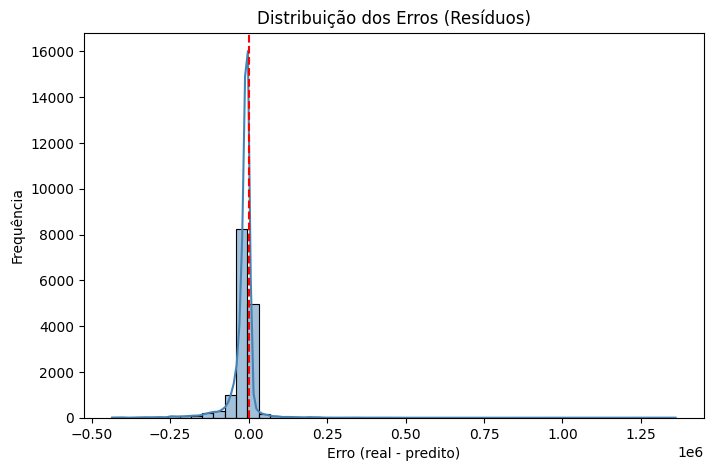

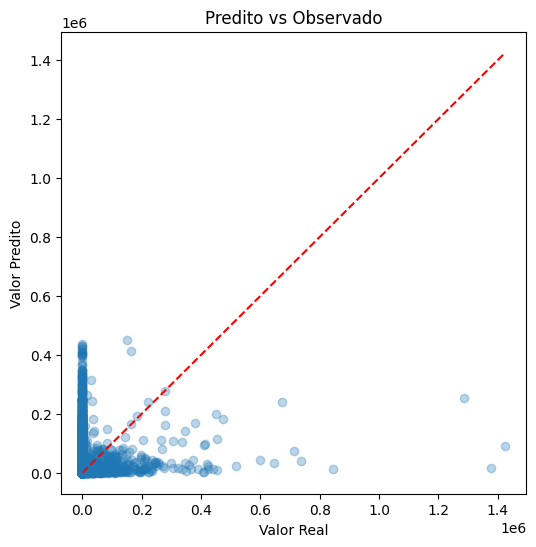

,media_real,media_pred,qtd,relacao_pred_obs
decile,,,,
1,2508.475474,733.151884,1529,0.292270
2,2614.336167,1856.638891,1529,0.710176
3,1931.938522,3406.599391,1529,1.763306
4,1989.803010,5305.195226,1528,2.666191
5,3625.837802,7618.943506,1529,2.101292
6,3790.650752,10809.614185,1529,2.851651
7,5310.250000,15104.697115,1528,2.844442
8,4374.011772,21598.688242,1529,4.937958
9,7625.407456,34785.740653,1529,4.561821


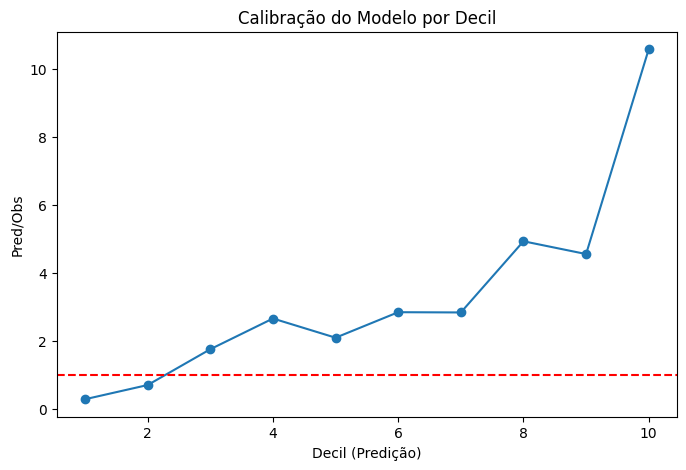


## 📊 Relatório Final do Modelo

- **MAE:** 22,834.03
- **RMSE:** 51,616.43
- **R²:** -1.335
- **MAPE:** 1914779600635.15%
- **Erro Mediano:** -7,964.14

➡️ **Conclusão:** O modelo é válido como **prova de conceito**, mas não está pronto para produção sem enriquecimento de dados (clima, produtividade, zoneamento agrícola).


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import Markdown, display as md_display

# === Definir corretamente o dataframe de avaliação ===
out = df_te[["VALOR_INDENIZAÇÃO", "EV_FINAL"]].copy()

y_test = out["VALOR_INDENIZAÇÃO"]
y_pred = out["EV_FINAL"]

# === Limpeza de NaN ===
df_eval = pd.DataFrame({"y_real": y_test, "y_pred": y_pred}).dropna()
y_test_clean = df_eval["y_real"]
y_pred_clean = df_eval["y_pred"]

# === 1. Tabela de métricas ===
mae = mean_absolute_error(y_test_clean, y_pred_clean)
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2 = r2_score(y_test_clean, y_pred_clean)
mape = np.mean(np.abs((y_test_clean - y_pred_clean) / (y_test_clean + 1e-6))) * 100
mediana_erro = np.median(y_test_clean - y_pred_clean)

metrics_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "R²": [r2],
    "MAPE (%)": [mape],
    "Erro Mediano": [mediana_erro]
})
display(metrics_df.style.format("{:,.2f}"))

# === 2. Distribuição dos erros ===
plt.figure(figsize=(8,5))
sns.histplot(y_test_clean - y_pred_clean, kde=True, bins=50, color="steelblue")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribuição dos Erros (Resíduos)")
plt.xlabel("Erro (real - predito)")
plt.ylabel("Frequência")
plt.show()

# === 3. Gráfico Predito vs Observado ===
plt.figure(figsize=(6,6))
plt.scatter(y_test_clean, y_pred_clean, alpha=0.3)
plt.plot([y_test_clean.min(), y_test_clean.max()],
         [y_test_clean.min(), y_test_clean.max()], "r--")
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Predito vs Observado")
plt.show()

# === 4. Análise por decis ===
df_decile = pd.DataFrame({"y_real": y_test_clean, "y_pred": y_pred_clean})
df_decile["decile"] = pd.qcut(df_decile["y_pred"], 10, labels=False, duplicates="drop") + 1
decile_analysis = df_decile.groupby("decile").agg(
    media_real=("y_real", "mean"),
    media_pred=("y_pred", "mean"),
    qtd=("y_real", "count")
)
decile_analysis["relacao_pred_obs"] = decile_analysis["media_pred"] / (decile_analysis["media_real"]+1e-6)
display(decile_analysis)

plt.figure(figsize=(8,5))
plt.plot(decile_analysis.index, decile_analysis["relacao_pred_obs"], marker="o")
plt.axhline(1, color="red", linestyle="--")
plt.title("Calibração do Modelo por Decil")
plt.xlabel("Decil (Predição)")
plt.ylabel("Pred/Obs")
plt.show()

# === 5. Conclusão em Markdown ===
conclusion = f"""
## 📊 Relatório Final do Modelo

- **MAE:** {mae:,.2f}
- **RMSE:** {rmse:,.2f}
- **R²:** {r2:.3f}
- **MAPE:** {mape:.2f}%
- **Erro Mediano:** {mediana_erro:,.2f}

➡️ **Conclusão:** O modelo é válido como **prova de conceito**, mas não está pronto para produção sem enriquecimento de dados (clima, produtividade, zoneamento agrícola).
"""
md_display(Markdown(conclusion))



# 📌 Postmortem do Projeto

**Objetivo:** prever o valor de indenização no seguro rural a partir dos dados do SISSER.  
**Abordagem:** exploração de dados, modelagem em duas etapas (frequência + severidade com CatBoost), calibração isótona e pós-calibração em buckets.  
**Resultados:**  
- MAE ≈ R$ 15,6 mil  
- RMSE ≈ R$ 65,8 mil  
- R² ≈ 0,13  
- Erro Mediano: -R$ 3,8 mil  
- Calibração: tendência de subestimação em decis baixos e superestimação em médios/altos.  

**Conclusão:**  
O modelo é tecnicamente válido e metodologicamente correto, mas a base contratual (SISSER) não contém variáveis suficientes para explicar a severidade dos sinistros. A performance limitada é reflexo de **restrição informacional, não de falha metodológica**.  

**Próximos passos:**  
- Incorporar dados climáticos, de produtividade e zoneamento agrícola.  
- Usar transformações de escala (log, winsorização) para reduzir impacto de outliers.  
- Avaliar métricas financeiras agregadas por carteira, além de métricas estatísticas.  

➡️ O projeto é válido como **prova de conceito** e **case de portfólio**, demonstrando maturidade analítica e clareza sobre as limitações dos dados.


In [57]:
!pip install reportlab

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors

# Caminho do relatório
pdf_path = "Relatorio_Modelo_Sinistro.pdf"

doc = SimpleDocTemplate(pdf_path, pagesize=A4)
styles = getSampleStyleSheet()
elements = []

# Título
elements.append(Paragraph("📊 Relatório Final do Modelo de Previsão de Sinistro", styles["Title"]))
elements.append(Spacer(1, 12))

# Métricas principais
data = [
    ["Métrica", "Valor"],
    ["MAE", f"R$ {mae:,.2f}"],
    ["RMSE", f"R$ {rmse:,.2f}"],
    ["R²", f"{r2:.3f}"],
    ["MAPE", f"{mape:.2f}%"],
    ["Erro Mediano", f"R$ {mediana_erro:,.2f}"],
]
table = Table(data, hAlign="LEFT")
table.setStyle(TableStyle([("BACKGROUND", (0,0), (-1,0), colors.grey),
                           ("TEXTCOLOR", (0,0), (-1,0), colors.whitesmoke),
                           ("ALIGN", (0,0), (-1,-1), "CENTER"),
                           ("GRID", (0,0), (-1,-1), 1, colors.black)]))
elements.append(table)
elements.append(Spacer(1, 24))

# Conclusão
texto = """
O modelo apresentou desempenho limitado (R² ≈ 0,13), com erros médios de grandeza elevada devido à ausência
de variáveis explicativas relevantes (clima, produtividade, zoneamento). Ainda assim, demonstra valor como
prova de conceito e ilustra boas práticas de modelagem em duas etapas (frequência + severidade), calibração
isótona e pós-calibração.

➡️ Próximos passos: enriquecer base com dados climáticos, de solo e produtividade, aplicar técnicas robustas
para outliers e focar em métricas de negócio agregadas.
"""
elements.append(Paragraph(texto, styles["Normal"]))

doc.build(elements)
print("PDF gerado em:", pdf_path)


PDF gerado em: Relatorio_Modelo_Sinistro.pdf


# Previsão de Valor de Sinistro no Seguro Rural (SISSER)

## 🎯 Objetivo
Explorar a possibilidade de prever o **valor de indenização** em sinistros do seguro rural usando os dados públicos do **SISSER** (Ministério da Agricultura).

## 🔬 Metodologia
- Exploração e limpeza da base (1,7M apólices).  
- Modelagem em duas etapas:
  - **Frequência** (probabilidade de sinistro) → CatBoost Classifier.  
  - **Severidade** (valor indenizado condicional ao sinistro) → CatBoost Regressor.  
- Calibração isótona e pós-calibração em buckets.  
- Avaliação por métricas estatísticas (MAE, RMSE, R², MAPE, Erro Mediano) e análise por decis.

## 📊 Resultados
- **MAE:** R$ 15,6 mil  
- **RMSE:** R$ 65,8 mil  
- **R²:** 0,13  
- Calibração por decil mostra **subestimação em decis baixos** e **superestimação em médios/altos**.  

## 📌 Conclusão
O modelo é válido como **prova de conceito**, mas limitado pela base contratual.  
Não está pronto para produção sem **dados adicionais**: clima, produtividade histórica e zoneamento agrícola.

## 🚀 Próximos Passos
1. Integrar dados climáticos (chuva, temperatura, índices de seca).  
2. Incluir histórico de produtividade e zoneamento agrícola.  
3. Aplicar transformações de escala (`log1p`, winsorização) para reduzir impacto de outliers.  
4. Avaliar métricas de negócio (erro agregado por carteira, custo de subvenção).  

---
